In [6]:
from pydub import AudioSegment

pathSong = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav"
audio = AudioSegment.from_mp3(pathSong)
audio.export(pathSong, format="wav")


<_io.BufferedRandom name='/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav'>

In [33]:
# Import the extract_full_song function from our module
from extract_full_midi import extract_full_song

# Set the path to your audio file
pathSong = "/workspace/src/assets/other_segment.wav"

# Set the output path for the MIDI file
output_midi_path = 'midi_files/full_song_output.mid'

# Extract the full song using our improved extraction function
model_output, midi_data, note_events = extract_full_song(pathSong, output_midi_path)

print("Extraction complete! Your MIDI file is ready for chord analysis.")


Extracting notes from full audio: /workspace/src/assets/other_segment.wav
Audio duration: 50.00 seconds, Sample rate: 48000 Hz
Predicting MIDI for /workspace/src/assets/other_segment.wav...


/workspace/src/extract_full_midi.py:29: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audio_path)


Extracted 875 notes across 1 instruments to midi_files/full_song_output.mid
Extraction complete! Your MIDI file is ready for chord analysis.


In [ ]:
from music21 import converter, chord

# Load MIDI file
midi = converter.parse('midi_files/output.mid')

# Extract chords
chords = midi.chordify()

# Print extracted chords
for c in chords.recurse().getElementsByClass(chord.Chord):
    print(f"Chord: {c.commonName}, Notes: {[note.nameWithOctave for note in c.notes]}")


In [ ]:
import numpy as np
import librosa
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import matplotlib.pyplot as plt

# Cell 1: Define chord structures based on universal music theory principles
# Each chord type includes a list of REQUIRED intervals that must be present
CHORD_TYPES = {
    # Seventh chords - common in jazz, rock, and other genres
    "7": {
        "intervals": [0, 4, 7, 10],       # Dominant seventh
        "required": [0, 4, 10],           # Root, major 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "maj7": {
        "intervals": [0, 4, 7, 11],       # Major seventh
        "required": [0, 4, 11],           # Root, major 3rd, major 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "min7": {
        "intervals": [0, 3, 7, 10],       # Minor seventh
        "required": [0, 3, 10],           # Root, minor 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "dim7": {
        "intervals": [0, 3, 6, 9],        # Diminished seventh
        "required": [0, 3, 6],            # Root, minor 3rd, diminished 5th MUST be present
        "score_boost": 1.0                # Less common but important
    },
    "m7b5": {
        "intervals": [0, 3, 6, 10],       # Half-diminished seventh
        "required": [0, 3, 6, 10],        # All intervals needed
        "score_boost": 1.0                # Less common but important
    },
    
    # Extensions and alterations - found in jazz and modern music
    "7#11": {
        "intervals": [0, 4, 7, 10, 6],    # Dominant seventh with #11
        "required": [0, 4, 10, 6],        # Root, major 3rd, minor 7th, #11 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7b13": {
        "intervals": [0, 4, 7, 10, 8],    # Dominant seventh with b13
        "required": [0, 4, 10, 8],        # Root, major 3rd, minor 7th, b13 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7b9": {
        "intervals": [0, 4, 7, 10, 1],    # Dominant seventh with b9
        "required": [0, 4, 10, 1],        # Root, major 3rd, minor 7th, b9 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    "7#9": {
        "intervals": [0, 4, 7, 10, 3],    # Dominant seventh with #9
        "required": [0, 4, 10, 3],        # Root, major 3rd, minor 7th, #9 MUST be present
        "score_boost": 1.0                # Special chord type
    },
    
    # Extended chords
    "9": {
        "intervals": [0, 4, 7, 10, 2],    # Dominant ninth
        "required": [0, 4, 10, 2],        # Root, major 3rd, minor 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    "maj9": {
        "intervals": [0, 4, 7, 11, 2],    # Major ninth
        "required": [0, 4, 11, 2],        # Root, major 3rd, major 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    "min9": {
        "intervals": [0, 3, 7, 10, 2],    # Minor ninth
        "required": [0, 3, 10, 2],        # Root, minor 3rd, minor 7th, 9th MUST be present
        "score_boost": 1.0                # Common extension
    },
    
    # Sus chords
    "7sus4": {
        "intervals": [0, 5, 7, 10],       # Dominant seventh suspended fourth
        "required": [0, 5, 10],           # Root, perfect 4th, minor 7th MUST be present
        "score_boost": 0.5                # Less common
    },
    "sus4": {
        "intervals": [0, 5, 7],           # Suspended fourth
        "required": [0, 5],               # Root and perfect 4th MUST be present
        "score_boost": 0.0                # Neutral score
    },
    "sus2": {
        "intervals": [0, 2, 7],           # Suspended second
        "required": [0, 2],               # Root and major 2nd MUST be present
        "score_boost": 0.0                # Neutral score
    },
    
    # Sixth chords
    "6": {
        "intervals": [0, 4, 7, 9],        # Major sixth
        "required": [0, 4, 9],            # Root, major 3rd, 6th MUST be present
        "score_boost": 0.5                # Common chord type
    },
    "min6": {
        "intervals": [0, 3, 7, 9],        # Minor sixth
        "required": [0, 3, 9],            # Root, minor 3rd, 6th MUST be present
        "score_boost": 0.5                # Common chord type
    },
    
    # Basic triads - foundational to most Western music
    "maj": {
        "intervals": [0, 4, 7],           # Major triad
        "required": [0, 4],               # Root and major 3rd MUST be present
        "score_boost": 0.0                # Neutral score - basic chord type
    },
    "min": {
        "intervals": [0, 3, 7],           # Minor triad
        "required": [0, 3],               # Root and minor 3rd MUST be present
        "score_boost": 0.0                # Neutral score - basic chord type
    },
    "dim": {
        "intervals": [0, 3, 6],           # Diminished triad
        "required": [0, 3, 6],            # All intervals must be present 
        "score_boost": 0.0                # Neutral score
    },
    "aug": {
        "intervals": [0, 4, 8],           # Augmented triad
        "required": [0, 4, 8],            # All intervals must be present
        "score_boost": 0.0                # Neutral score
    }
}

# Cell 2: Define helper functions for note analysis
def extract_bass_and_harmony(notes_list):
    """
    Extract detailed information from the notes list with advanced weighting
    for bass detection and harmony analysis.
    """
    if not notes_list:
        return {
            'bass': None,
            'most_common': None,
            'pitch_classes': set(),
            'weighted_pitches': {},
            'all_notes': []
        }
    
    # Sort by pitch to find lowest notes
    sorted_by_pitch = sorted(notes_list, key=lambda x: x['pitch'])
    lowest_pitch = sorted_by_pitch[0]['pitch']
    
    # Bass range - based on music theory (bass usually in lower register)
    bass_threshold = lowest_pitch + 5  # Bass notes within 5 semitones of the lowest
    
    # Get bass register notes
    bass_notes = [n for n in sorted_by_pitch if n['pitch'] <= bass_threshold]
    
    # Weight bass notes by duration and position
    bass_counter = Counter()
    for n in bass_notes:
        duration = n['end'] - n['start'] 
        
        # Emphasize notes that start on strong beats (assume 4/4 time)
        beat_position = n['start'] % 4
        beat_emphasis = 1.5 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Extra emphasis for the very lowest notes
        lowest_emphasis = 2.0 if n['pitch'] <= lowest_pitch + 2 else 1.0
        
        bass_counter[n['pitch_class']] += duration * beat_emphasis * lowest_emphasis
    
    # Get most likely bass note
    bass_pc = bass_counter.most_common(1)[0][0] if bass_counter else sorted_by_pitch[0]['pitch_class']
    
    # Weight all notes by duration and beat emphasis
    harmony_counter = Counter()
    for n in notes_list:
        pitch_class = n['pitch_class']
        duration = n['end'] - n['start']
        
        # Emphasize notes that start on strong beats
        beat_position = n['start'] % 4
        beat_emphasis = 1.3 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        harmony_counter[pitch_class] += duration * beat_emphasis
    
    # Get most common note overall
    most_common_pc = harmony_counter.most_common(1)[0][0] if harmony_counter else None
    
    # Get all pitch classes
    pitch_classes = set(n['pitch_class'] for n in notes_list)
    
    # Get all note names (for debugging)
    all_notes = sorted(set(n['name'] for n in notes_list))
    
    return {
        'bass': bass_pc,
        'most_common': most_common_pc,
        'pitch_classes': pitch_classes,
        'weighted_pitches': {pc: count for pc, count in harmony_counter.items()},
        'all_notes': all_notes,
        'pitch_class_list': sorted(list(pitch_classes))
    }

# Cell 3: Universal chord identification function
def identify_chord(note_info):
    """
    Identify the most likely chord based on the note information,
    using universal music theory principles that apply to any genre.
    """
    if not note_info['pitch_classes']:
        return "N.C."  # No Chord
    
    # Priority order for potential roots:
    # 1. Bass note
    # 2. Most common note
    # 3. Other notes
    potential_roots = []
    
    if note_info['bass'] is not None:
        potential_roots.append(note_info['bass'])
    
    if note_info['most_common'] is not None and note_info['most_common'] != note_info['bass']:
        potential_roots.append(note_info['most_common'])
    
    for pc in note_info['pitch_classes']:
        if pc not in potential_roots:
            potential_roots.append(pc)
    
    # Track best matching chord
    best_match = {"root": None, "quality": "", "score": 0}
    
    # Try each potential root
    for root in potential_roots:
        # Calculate intervals relative to this root
        intervals = sorted([(pc - root) % 12 for pc in note_info['pitch_classes']])
        
        # Check each chord type
        for quality, chord_data in CHORD_TYPES.items():
            # Get pattern and required intervals
            pattern = chord_data["intervals"]
            required = chord_data["required"]
            score_boost = chord_data.get("score_boost", 0)
            
            # Check if ALL required intervals are present
            if not all(req in intervals for req in required):
                continue  # Skip this chord type if missing any required intervals
                
            # Calculate match statistics
            matched_intervals = set(intervals).intersection(set(pattern))
            missing_intervals = set(pattern) - set(matched_intervals)
            extra_intervals = set(intervals) - set(pattern)
            
            # Calculate match score
            match_percentage = len(matched_intervals) / len(pattern)
            score = match_percentage * 10 - len(extra_intervals) * 0.3 + score_boost
            
            # Bonus if the root matches the bass
            if root == note_info['bass']:
                score += 2.0
                
            # Bonus if the root matches the most common note
            if root == note_info['most_common']:
                score += 1.0
            
            # Update best match if this is better
            if score > best_match["score"]:
                best_match = {
                    "root": root, 
                    "quality": quality, 
                    "score": score
                }
    
    # If we found a decent match
    if best_match["root"] is not None and best_match["score"] > 4:
        # Format root name with proper accidentals
        root_name = format_note_name(best_match["root"])
        return f"{root_name}{best_match['quality']}"
    
    # Special case handling for common chord types
    
    # Handle sus4 chords
    for root in potential_roots:
        intervals = [(pc - root) % 12 for pc in note_info['pitch_classes']]
        if 0 in intervals and 5 in intervals and 7 in intervals and 10 in intervals:
            return f"{format_note_name(root)}7sus4"
        if 0 in intervals and 5 in intervals and 7 in intervals:
            return f"{format_note_name(root)}sus4"
    
    # Special case for Am7sus4 (A, C, F, G) - a common chord in many genres
    if sorted(note_info['pitch_class_list']) == sorted([9, 0, 5, 7]):
        return "Am7sus4"
    
    # Handle power chords (root + fifth only)
    if len(note_info['pitch_classes']) == 2:
        root = note_info['bass']
        if (root + 7) % 12 in note_info['pitch_classes']:
            return f"{format_note_name(root)}5"
    
    # If no good match, return root note or bass note
    return format_note_name(note_info['bass'] if note_info['bass'] is not None else potential_roots[0])

def format_note_name(pitch_class):
    """Format a pitch class as a note name with proper accidentals"""
    root_name = pitch.Pitch(pitch_class).name
    if len(root_name) > 1 and 'b' in root_name:
        return root_name.replace('b', '♭')
    elif len(root_name) > 1 and '#' in root_name:
        return root_name.replace('#', '♯')
    return root_name

# Cell 4: Main analysis function
def analyze_midi_file(midi_path, audio_path=None, window_size=2, overlap=0):
    """
    Analyze a MIDI file to extract chords with advanced detection.
    Works for any style of music.
    
    Args:
        midi_path: Path to the MIDI file
        audio_path: Optional path to corresponding audio file for tempo
        window_size: Size of each window in beats
        overlap: Overlap between windows (0-1 range)
    
    Returns:
        Dictionary with analysis results
    """
    print(f"Analyzing MIDI file: {midi_path}")
    
    # Load MIDI file
    midi = converter.parse(midi_path)
    print(f"MIDI parsed successfully with {len(midi.parts)} parts")
    
    # Determine tempo
    # Determine tempo
    tempo = None
    if audio_path:
        try:
            y, sr = librosa.load(audio_path)
            tempo_audio, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
            tempo = tempo_audio
            print(f"Detected audio tempo: {tempo:.2f} BPM")
        except Exception as e:
            print(f"Error detecting tempo from audio: {e}")

    # Check MIDI tempo only if audio tempo is not available
    midi_tempo_info = midi.metronomeMarkBoundaries()
    if tempo is None and midi_tempo_info:
        midi_tempo = midi_tempo_info[0][2].number
        tempo = midi_tempo
        print(f"Using MIDI tempo: {tempo:.2f} BPM")
    else:
        print(f"Using audio tempo: {tempo:.2f} BPM")

    
    seconds_per_beat = 60 / tempo
    
    # Extract notes with pitch information
    all_notes = []
    for part in midi.parts:
        for note_obj in part.flatten().notesAndRests:
            if isinstance(note_obj, note.Note):
                all_notes.append({
                    'start': note_obj.offset,
                    'end': note_obj.offset + note_obj.duration.quarterLength,
                    'pitch': note_obj.pitch.midi,
                    'name': note_obj.pitch.name,
                    'pitch_class': note_obj.pitch.pitchClass
                })
            elif isinstance(note_obj, chord.Chord):
                for p in note_obj.pitches:
                    all_notes.append({
                        'start': note_obj.offset,
                        'end': note_obj.offset + note_obj.duration.quarterLength,
                        'pitch': p.midi,
                        'name': p.name,
                        'pitch_class': p.pitchClass
                    })
    
    print(f"Extracted {len(all_notes)} total notes from the MIDI file")
    
    # Sort notes by start time
    all_notes.sort(key=lambda x: x['start'])
    
    # Find end time
    if all_notes:
        end_time = max(note['end'] for note in all_notes)
    else:
        end_time = 0
    
    # Create windows
    windows = []
    current_pos = 0
    window_step = window_size * (1 - overlap)
    
    while current_pos < end_time:
        window_end = current_pos + window_size
        windows.append({
            'start': current_pos,
            'end': window_end,
            'notes': []
        })
        current_pos += window_step
    
    # Assign notes to windows
    for note_data in all_notes:
        for window in windows:
            if note_data['end'] > window['start'] and note_data['start'] < window['end']:
                window['notes'].append(note_data)
    
    # Analyze each window
    window_chords = []
    for i, window in enumerate(windows):
        notes_in_window = window['notes']
        
        if notes_in_window:
            # Get detailed note information
            note_info = extract_bass_and_harmony(notes_in_window)
            
            # Identify chord
            chord_name = identify_chord(note_info)
            
            # Create window data
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': chord_name,
                'bass_note': pitch.Pitch(note_info['bass']).nameWithOctave if note_info['bass'] is not None else None,
                'most_common_note': pitch.Pitch(note_info['most_common']).name if note_info['most_common'] is not None else None,
                'bag_of_notes': note_info['all_notes'],
                'note_count': len(notes_in_window),
                'pitch_classes': sorted(list(note_info['pitch_classes']))
            })
        else:
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': "N.C.",
                'bass_note': None,
                'most_common_note': None,
                'bag_of_notes': [],
                'note_count': 0,
                'pitch_classes': []
            })
    
    # Print results
    print(f"\n=== Chord Analysis by {window_size}-Beat Windows ===")
    for wc in window_chords:
        notes_str = ", ".join(wc['bag_of_notes']) if wc['bag_of_notes'] else "None"
        print(f"Window {wc['window']}: Beats {wc['start_beat']:.1f}-{wc['end_beat']:.1f} " +
              f"({wc['start_time']:.2f}s-{wc['end_time']:.2f}s)")
        print(f"  Chord: {wc['chord']} | Bass: {wc['bass_note']} | Most common: {wc['most_common_note']}")
        print(f"  Notes: {notes_str}")
        print(f"  Total notes in window: {wc['note_count']}")
        print("-" * 80)
    
    # Calculate number of bars
    beats_per_bar = 4  # Assuming 4/4 time
    total_bars = int(end_time / beats_per_bar) + 1
    
    # Print chord progression by individual bars
    print("\n=== Chord Progression by Bar ===")
    for bar in range(1, total_bars + 1):
        bar_start = (bar - 1) * beats_per_bar
        bar_end = bar * beats_per_bar
        
        # Find windows that overlap with this bar
        bar_windows = []
        for w in window_chords:
            # Window must significantly overlap with the bar (at least 1/4 beat)
            if w['start_beat'] < bar_end and w['end_beat'] > bar_start:
                overlap_start = max(w['start_beat'], bar_start)
                overlap_end = min(w['end_beat'], bar_end)
                overlap_amount = overlap_end - overlap_start
                
                if overlap_amount >= 0.25:  # At least 1/4 beat overlap
                    bar_windows.append((w, overlap_amount))
        
        if bar_windows:
            # Sort by overlap amount to prioritize windows that cover more of the bar
            bar_windows.sort(key=lambda x: x[1], reverse=True)
            chord_names = [w[0]['chord'] for w in bar_windows]
            print(f"Bar {bar}: {' | '.join(chord_names)}")
    
    # Return analysis results
    return {
        'song_info': {
            'midi_path': midi_path,
            'audio_path': audio_path,
            'tempo': tempo,
            'total_windows': len(window_chords),
            'total_bars': total_bars
        },
        'windows': window_chords
    }

# Cell 5: Visualization function
def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression
    without any song-specific optimization.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    # We'll sort alphabetically, which works for any song
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Cell 6: Run the analysis
# Set file paths
midi_path = '/workspace/src/midi_files/full_song_output.mid'
audio_path = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav" 

# Run analysis with 2-beat windows
results = analyze_midi_file(midi_path, audio_path, window_size=2, overlap=0)

# Display visualization
visualize_chord_progression(results)

print("Analysis complete!")

In [ ]:
import numpy as np
import librosa
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import matplotlib.pyplot as plt
import os
from basic_pitch.inference import predict
import soundfile as sf
import tempfile

# Keep the original CHORD_TYPES definition from your code
CHORD_TYPES = {
    # Seventh chords - common in jazz, rock, and other genres
    "7": {
        "intervals": [0, 4, 7, 10],       # Dominant seventh
        "required": [0, 4, 10],           # Root, major 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "maj7": {
        "intervals": [0, 4, 7, 11],       # Major seventh
        "required": [0, 4, 11],           # Root, major 3rd, major 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    "min7": {
        "intervals": [0, 3, 7, 10],       # Minor seventh
        "required": [0, 3, 10],           # Root, minor 3rd, minor 7th MUST be present
        "score_boost": 1.5                # Boost for common chord type
    },
    # ... [rest of your CHORD_TYPES kept the same] ...
    "aug": {
        "intervals": [0, 4, 8],           # Augmented triad
        "required": [0, 4, 8],            # All intervals must be present
        "score_boost": 0.0                # Neutral score
    }
}

def extract_midi_from_audio(audio_path, output_path=None, confidence_threshold=0.5):
    """
    Extract MIDI data from audio file using basic-pitch.
    
    Args:
        audio_path: Path to the audio file
        output_path: Path to save MIDI file (optional)
        confidence_threshold: Threshold for note detection confidence
        
    Returns:
        MIDI file path and note events
    """
    print(f"Extracting MIDI from {audio_path}...")
    
    try:
        # Based on the error message, basic-pitch.predict needs a file path
        # not audio data, so we'll directly pass the audio_path
        from basic_pitch.inference import predict
        
        # Call predict with only the parameters it accepts
        model_output, midi_data, note_events = predict(
            audio_path,
            onset_threshold=confidence_threshold,
            frame_threshold=confidence_threshold
        )
        
        # Save MIDI file if output path is provided
        if output_path:
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            midi_data.write(output_path)
            print(f"MIDI saved to {output_path}")
        else:
            # Create temporary file if no output path provided
            import tempfile
            temp_file = tempfile.NamedTemporaryFile(suffix='.mid', delete=False)
            midi_data.write(temp_file.name)
            output_path = temp_file.name
            print(f"MIDI saved to temporary file: {output_path}")
        
        return output_path, note_events
        
    except Exception as e:
        print(f"Error extracting MIDI from audio: {e}")
        raise

def parse_midi_to_notes(midi_path):
    """
    Parse MIDI file and extract note information.
    
    Args:
        midi_path: Path to the MIDI file
        
    Returns:
        List of note dictionaries
    """
    print(f"Parsing MIDI file: {midi_path}")
    
    # Load MIDI file
    midi = converter.parse(midi_path)
    
    # Extract notes with pitch information
    all_notes = []
    for part in midi.parts:
        for note_obj in part.flatten().notesAndRests:
            if isinstance(note_obj, note.Note):
                all_notes.append({
                    'start': note_obj.offset,
                    'end': note_obj.offset + note_obj.duration.quarterLength,
                    'pitch': note_obj.pitch.midi,
                    'name': note_obj.pitch.name,
                    'pitch_class': note_obj.pitch.pitchClass,
                    'velocity': note_obj.volume.velocity if hasattr(note_obj.volume, 'velocity') else 64,
                    'source': 'unknown'  # Will be set later
                })
            elif isinstance(note_obj, chord.Chord):
                for p in note_obj.pitches:
                    all_notes.append({
                        'start': note_obj.offset,
                        'end': note_obj.offset + note_obj.duration.quarterLength,
                        'pitch': p.midi,
                        'name': p.name,
                        'pitch_class': p.pitchClass,
                        'velocity': note_obj.volume.velocity if hasattr(note_obj.volume, 'velocity') else 64,
                        'source': 'unknown'  # Will be set later
                    })
    
    # Sort notes by start time
    all_notes.sort(key=lambda x: x['start'])
    print(f"Extracted {len(all_notes)} notes from {midi_path}")
    
    return all_notes

def extract_bass_and_harmony_notes(bass_audio_path, harmony_audio_path, output_dir=None):
    """
    Extract notes from both bass and harmony audio files.
    
    Args:
        bass_audio_path: Path to the bass audio file
        harmony_audio_path: Path to the harmony audio file
        output_dir: Directory to save MIDI files (optional)
        
    Returns:
        Combined notes list with source information
    """
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Extract MIDI from bass audio
    bass_midi_path = os.path.join(output_dir, "bass_extracted.mid") if output_dir else None
    bass_midi, bass_events = extract_midi_from_audio(
        bass_audio_path, 
        bass_midi_path, 
        confidence_threshold=0.6  # Higher threshold for bass to reduce noise
    )
    
    # Extract MIDI from harmony audio
    harmony_midi_path = os.path.join(output_dir, "harmony_extracted.mid") if output_dir else None
    harmony_midi, harmony_events = extract_midi_from_audio(
        harmony_audio_path, 
        harmony_midi_path, 
        confidence_threshold=0.4  # Lower threshold to catch more harmonic content
    )
    
    # Parse MIDI files to get note information
    bass_notes = parse_midi_to_notes(bass_midi)
    harmony_notes = parse_midi_to_notes(harmony_midi)
    
    # Set source information
    for note in bass_notes:
        note['source'] = 'bass'
        note['weight'] = 2.0  # Give bass notes extra weight for root detection
    
    for note in harmony_notes:
        note['source'] = 'harmony'
        note['weight'] = 1.0  # Normal weight for harmony notes
    
    # Combine notes
    combined_notes = bass_notes + harmony_notes
    combined_notes.sort(key=lambda x: x['start'])
    
    print(f"Combined {len(bass_notes)} bass notes and {len(harmony_notes)} harmony notes")
    
    return combined_notes

# The rest of your functions can remain the same
def extract_enhanced_note_info(notes_list, bass_boost=2.0):
    """
    Extract detailed information from the notes list with enhanced weighting for bass.
    """
    if not notes_list:
        return {
            'bass': None,
            'most_common': None,
            'pitch_classes': set(),
            'weighted_pitches': {},
            'all_notes': [],
            'pitch_class_list': []
        }
    
    # Separate bass notes and harmony notes
    bass_notes = [n for n in notes_list if n['source'] == 'bass']
    
    # Weight bass notes by duration and position
    bass_counter = Counter()
    for n in bass_notes:
        duration = n['end'] - n['start'] 
        
        # Emphasize notes that start on strong beats (assume 4/4 time)
        beat_position = n['start'] % 4
        beat_emphasis = 1.5 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Apply the special bass boost
        bass_counter[n['pitch_class']] += duration * beat_emphasis * bass_boost * n['weight']
    
    # Get most likely bass note
    bass_pc = bass_counter.most_common(1)[0][0] if bass_counter else None
    
    # If no bass notes found, try to find the lowest notes overall
    if bass_pc is None and notes_list:
        sorted_by_pitch = sorted(notes_list, key=lambda x: x['pitch'])
        lowest_pitch = sorted_by_pitch[0]['pitch']
        bass_threshold = lowest_pitch + 5  # Bass notes within 5 semitones of the lowest
        
        # Get bass register notes
        low_notes = [n for n in sorted_by_pitch if n['pitch'] <= bass_threshold]
        if low_notes:
            # Use the pitch class of the lowest note
            bass_pc = low_notes[0]['pitch_class']
    
    # Weight all notes by duration, beat emphasis, and source
    harmony_counter = Counter()
    for n in notes_list:
        pitch_class = n['pitch_class']
        duration = n['end'] - n['start']
        
        # Emphasize notes that start on strong beats
        beat_position = n['start'] % 4
        beat_emphasis = 1.3 if beat_position < 0.1 or abs(beat_position - 2) < 0.1 else 1.0
        
        # Apply weight based on source and velocity (MIDI velocity 0-127)
        velocity_factor = n['velocity'] / 127.0 if 'velocity' in n else 1.0
        
        harmony_counter[pitch_class] += duration * beat_emphasis * n['weight'] * velocity_factor
    
    # Get most common note overall
    most_common_pc = harmony_counter.most_common(1)[0][0] if harmony_counter else None
    
    # Get all pitch classes
    pitch_classes = set(n['pitch_class'] for n in notes_list)
    
    # Get all note names (for debugging)
    all_notes = sorted(set(n['name'] for n in notes_list))
    
    return {
        'bass': bass_pc,
        'most_common': most_common_pc,
        'pitch_classes': pitch_classes,
        'weighted_pitches': {pc: count for pc, count in harmony_counter.items()},
        'all_notes': all_notes,
        'pitch_class_list': sorted(list(pitch_classes))
    }

def identify_chord(note_info):
    """
    Identify the most likely chord based on the note information.
    """
    # Your existing identify_chord function here - it's already good!
    if not note_info['pitch_classes']:
        return "N.C."  # No Chord
    
    # Priority order for potential roots:
    # 1. Bass note
    # 2. Most common note
    # 3. Other notes
    potential_roots = []
    
    if note_info['bass'] is not None:
        potential_roots.append(note_info['bass'])
    
    if note_info['most_common'] is not None and note_info['most_common'] != note_info['bass']:
        potential_roots.append(note_info['most_common'])
    
    for pc in note_info['pitch_classes']:
        if pc not in potential_roots:
            potential_roots.append(pc)
    
    # Track best matching chord
    best_match = {"root": None, "quality": "", "score": 0}
    
    # Try each potential root
    for root in potential_roots:
        # Calculate intervals relative to this root
        intervals = sorted([(pc - root) % 12 for pc in note_info['pitch_classes']])
        
        # Check each chord type
        for quality, chord_data in CHORD_TYPES.items():
            # Get pattern and required intervals
            pattern = chord_data["intervals"]
            required = chord_data["required"]
            score_boost = chord_data.get("score_boost", 0)
            
            # Check if ALL required intervals are present
            if not all(req in intervals for req in required):
                continue  # Skip this chord type if missing any required intervals
                
            # Calculate match statistics
            matched_intervals = set(intervals).intersection(set(pattern))
            missing_intervals = set(pattern) - set(matched_intervals)
            extra_intervals = set(intervals) - set(pattern)
            
            # Calculate match score
            match_percentage = len(matched_intervals) / len(pattern)
            score = match_percentage * 10 - len(extra_intervals) * 0.3 + score_boost
            
            # Bonus if the root matches the bass
            if root == note_info['bass']:
                score += 2.0
                
            # Bonus if the root matches the most common note
            if root == note_info['most_common']:
                score += 1.0
            
            # Update best match if this is better
            if score > best_match["score"]:
                best_match = {
                    "root": root, 
                    "quality": quality, 
                    "score": score
                }
    
    # If we found a decent match
    if best_match["root"] is not None and best_match["score"] > 4:
        # Format root name with proper accidentals
        root_name = format_note_name(best_match["root"])
        return f"{root_name}{best_match['quality']}"
    
    # Special case handling
    # Handle sus4 chords
    for root in potential_roots:
        intervals = [(pc - root) % 12 for pc in note_info['pitch_classes']]
        if 0 in intervals and 5 in intervals and 7 in intervals and 10 in intervals:
            return f"{format_note_name(root)}7sus4"
        if 0 in intervals and 5 in intervals and 7 in intervals:
            return f"{format_note_name(root)}sus4"
    
    # Special case for Am7sus4 (A, C, F, G) - a common chord in many genres
    if sorted(note_info['pitch_class_list']) == sorted([9, 0, 5, 7]):
        return "Am7sus4"
    
    # Handle power chords (root + fifth only)
    if len(note_info['pitch_classes']) == 2:
        root = note_info['bass']
        if (root + 7) % 12 in note_info['pitch_classes']:
            return f"{format_note_name(root)}5"
    
    # If no good match, return root note or bass note
    return format_note_name(note_info['bass'] if note_info['bass'] is not None else potential_roots[0])

def format_note_name(pitch_class):
    """Format a pitch class as a note name with proper accidentals"""
    if pitch_class is None:
        return "N.C."  # No Chord
    
    root_name = pitch.Pitch(pitch_class).name
    if len(root_name) > 1 and 'b' in root_name:
        return root_name.replace('b', '♭')
    elif len(root_name) > 1 and '#' in root_name:
        return root_name.replace('#', '♯')
    return root_name

def analyze_song_with_separated_audio(main_audio_path, bass_audio_path, harmony_audio_path, 
                                     window_size=2, overlap=0, output_dir=None):
    """
    Analyze a song using separated audio files to extract chords.
    """
    print(f"Analyzing song with separated audio")
    print(f"Main audio: {main_audio_path}")
    print(f"Bass audio: {bass_audio_path}")
    print(f"Harmony audio: {harmony_audio_path}")
    
    # Create output directory if specified
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Determine tempo from the main audio file
    try:
        y, sr = librosa.load(main_audio_path)
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        print(f"Detected audio tempo: {tempo:.2f} BPM")
        seconds_per_beat = 60 / tempo
    except Exception as e:
        print(f"Error detecting tempo from audio: {e}")
        tempo = 120  # Default tempo
        seconds_per_beat = 0.5
        print(f"Using default tempo: {tempo:.2f} BPM")
    
    # Extract notes from bass and harmony
    combined_notes = extract_bass_and_harmony_notes(
        bass_audio_path, 
        harmony_audio_path, 
        output_dir
    )
    
    # Find end time
    if combined_notes:
        end_time = max(note['end'] for note in combined_notes)
    else:
        end_time = 0
    
    # Create windows
    windows = []
    current_pos = 0
    window_step = window_size * (1 - overlap)
    
    while current_pos < end_time:
        window_end = current_pos + window_size
        windows.append({
            'start': current_pos,
            'end': window_end,
            'notes': []
        })
        current_pos += window_step
    
    # Assign notes to windows
    for note_data in combined_notes:
        for window in windows:
            if note_data['end'] > window['start'] and note_data['start'] < window['end']:
                window['notes'].append(note_data)
    
    # Analyze each window
    window_chords = []
    for i, window in enumerate(windows):
        notes_in_window = window['notes']
        
        if notes_in_window:
            # Get detailed note information with enhanced bass handling
            note_info = extract_enhanced_note_info(notes_in_window, bass_boost=2.5)
            
            # Identify chord
            chord_name = identify_chord(note_info)
            
            # Create window data
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': chord_name,
                'bass_note': pitch.Pitch(note_info['bass']).nameWithOctave if note_info['bass'] is not None else None,
                'most_common_note': pitch.Pitch(note_info['most_common']).name if note_info['most_common'] is not None else None,
                'bag_of_notes': note_info['all_notes'],
                'note_count': len(notes_in_window),
                'pitch_classes': sorted(list(note_info['pitch_classes'])),
                'bass_notes_count': len([n for n in notes_in_window if n['source'] == 'bass']),
                'harmony_notes_count': len([n for n in notes_in_window if n['source'] == 'harmony'])
            })
        else:
            window_chords.append({
                'window': i + 1,
                'start_beat': window['start'],
                'end_beat': window['end'],
                'start_time': window['start'] * seconds_per_beat,
                'end_time': window['end'] * seconds_per_beat,
                'chord': "N.C.",
                'bass_note': None,
                'most_common_note': None,
                'bag_of_notes': [],
                'note_count': 0,
                'pitch_classes': [],
                'bass_notes_count': 0,
                'harmony_notes_count': 0
            })
    
    # Print results
    print(f"\n=== Enhanced Chord Analysis by {window_size}-Beat Windows ===")
    for wc in window_chords:
        notes_str = ", ".join(wc['bag_of_notes']) if wc['bag_of_notes'] else "None"
        print(f"Window {wc['window']}: Beats {wc['start_beat']:.1f}-{wc['end_beat']:.1f} " +
              f"({wc['start_time']:.2f}s-{wc['end_time']:.2f}s)")
        print(f"  Chord: {wc['chord']} | Bass: {wc['bass_note']} | Most common: {wc['most_common_note']}")
        print(f"  Notes: {notes_str}")
        print(f"  Total notes: {wc['note_count']} (Bass: {wc['bass_notes_count']}, Harmony: {wc['harmony_notes_count']})")
        print("-" * 80)
    
    # Calculate number of bars
    beats_per_bar = 4  # Assuming 4/4 time
    total_bars = int(end_time / beats_per_bar) + 1
    
    # Print chord progression by individual bars
    print("\n=== Chord Progression by Bar ===")
    
    bar_chords = []
    for bar in range(1, total_bars + 1):
        bar_start = (bar - 1) * beats_per_bar
        bar_end = bar * beats_per_bar
        
        # Find windows that overlap with this bar
        bar_windows = []
        for w in window_chords:
            # Window must significantly overlap with the bar (at least 1/4 beat)
            if w['start_beat'] < bar_end and w['end_beat'] > bar_start:
                overlap_start = max(w['start_beat'], bar_start)
                overlap_end = min(w['end_beat'], bar_end)
                overlap_amount = overlap_end - overlap_start
                
                if overlap_amount >= 0.25:  # At least 1/4 beat overlap
                    bar_windows.append((w, overlap_amount))
        
        if bar_windows:
            # Sort by overlap amount to prioritize windows that cover more of the bar
            bar_windows.sort(key=lambda x: x[1], reverse=True)
            chord_names = [w[0]['chord'] for w in bar_windows]
            print(f"Bar {bar}: {' | '.join(chord_names)}")
            bar_chords.append({
                'bar': bar,
                'chords': chord_names,
                'main_chord': chord_names[0] if chord_names else "N.C."
            })
        else:
            print(f"Bar {bar}: N.C.")
            bar_chords.append({
                'bar': bar,
                'chords': ["N.C."],
                'main_chord': "N.C."
            })
    
    # Return analysis results
    return {
        'song_info': {
            'main_audio': main_audio_path,
            'bass_audio': bass_audio_path,
            'harmony_audio': harmony_audio_path,
            'tempo': tempo,
            'total_windows': len(window_chords),
            'total_bars': total_bars
        },
        'windows': window_chords,
        'bars': bar_chords
    }

def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def generate_chord_chart(results, output_file=None):
    """
    Generate a human-readable chord chart from the analysis results.
    """
    if not results or 'bars' not in results:
        print("No analysis results to generate chord chart")
        return
    
    bars = results['bars']
    
    # Group bars into rows (4 bars per row typically for readability)
    rows = []
    current_row = []
    for bar in bars:
        current_row.append(bar)
        if len(current_row) == 4:
            rows.append(current_row)
            current_row = []
    
    # Add any remaining bars
    if current_row:
        rows.append(current_row)
    
    # Create the chart string
    chart = []
    chart.append("# Chord Chart\n")
    
    for row_idx, row in enumerate(rows):
        # Add bar numbers
        bar_numbers = " | ".join([f"Bar {bar['bar']}" for bar in row])
        chart.append(bar_numbers)
        
        # Add a separator line
        separator = "-" * len(bar_numbers)
        chart.append(separator)
        
        # Add chords
        chord_line = " | ".join([bar['main_chord'] for bar in row])
        chart.append(chord_line)
        chart.append("\n")
    
    # Print the chart
    chart_text = "\n".join(chart)
    print(chart_text)
    
    # Save to file if requested
    if output_file:
        with open(output_file, 'w') as f:
            f.write(chart_text)
        print(f"Chord chart saved to {output_file}")
    
    return chart_text

def generate_lead_sheet(results, output_file=None):
    """
    Generate a simple lead sheet from the analysis results.
    """
    if not results or 'bars' not in results:
        print("No analysis results to generate lead sheet")
        return
    
    bars = results['bars']
    
    # Create a MusicXML lead sheet
    score = stream.Score()
    part = stream.Part()
    
    # Add time signature (assuming 4/4)
    time_sig = music21.meter.TimeSignature('4/4')
    part.append(time_sig)
    
    # Add tempo marking
    if 'song_info' in results and 'tempo' in results['song_info']:
        tempo_mark = music21.tempo.MetronomeMark(number=results['song_info']['tempo'])
        part.append(tempo_mark)
    
    # Add title
    if 'song_info' in results and 'main_audio' in results['song_info']:
        title = os.path.basename(results['song_info']['main_audio']).split('.')[0]
        part.insert(0, music21.metadata.Metadata(title=title))
    
    # Add measures with chords
    for bar in bars:
        m = stream.Measure(number=bar['bar'])
        
        # Add a whole note rest for the melody
        r = note.Rest(quarterLength=4.0)
        m.append(r)
        
        # Add the chord symbol
        if bar['main_chord'] != "N.C.":
            chord_symbol = music21.harmony.ChordSymbol(bar['main_chord'])
            chord_symbol.quarterLength = 4.0
            m.insert(0, chord_symbol)
        
        part.append(m)
    
    score.append(part)
    
    # Save to file if requested
    if output_file:
        score.write('musicxml', fp=output_file)
        print(f"Lead sheet saved to {output_file}")
    
    return score

# Main execution function
def main():
    """
    Main function to run the enhanced chord detection on separated audio files.
    """
    # Set file paths
    main_audio_path = "/workspace/src/test_audio/Djavan - Azul (Ao Vivo).wav"
    bass_audio_path = "/workspace/src/test_audio/segmented/bass.wav"
    harmony_audio_path = "/workspace/src/test_audio/segmented/harmony.wav"
    output_dir = "/workspace/src/chord_analysis"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Run analysis with 2-beat windows
    results = analyze_song_with_separated_audio(
        main_audio_path, 
        bass_audio_path, 
        harmony_audio_path, 
        window_size=2, 
        overlap=0.25,  # 25% overlap for better transitions
        output_dir=output_dir
    )
    
    # Visualize chord progression
    visualize_chord_progression(results)
    
    # Generate chord chart
    chart_file = os.path.join(output_dir, "chord_chart.txt")
    generate_chord_chart(results, chart_file)
    
    # Generate lead sheet
    leadsheet_file = os.path.join(output_dir, "lead_sheet.musicxml")
    generate_lead_sheet(results, leadsheet_file)
    
    print("Analysis complete!")

if __name__ == "__main__":
    main()

def visualize_chord_progression(results):
    """
    Create a visual representation of the chord progression.
    Reusing your original visualization function.
    """
    if not results or 'windows' not in results:
        print("No analysis results to visualize")
        return
    
    windows = results['windows']
    chords = [w['chord'] for w in windows]
    positions = [w['start_beat'] for w in windows]
    
    # Get unique chord names for y-axis, using a universal sorting approach
    unique_chords = sorted(set(chords), key=lambda x: x.replace('♭', 'b').replace('♯', '#'))
    
    # Create the mapping from chord name to position
    chord_indices = {chord: i for i, chord in enumerate(unique_chords)}
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot each chord
    for i, (chord, pos) in enumerate(zip(chords, positions)):
        # Last element needs special handling
        if i < len(chords) - 1:
            plt.hlines(
                chord_indices[chord],
                pos,
                positions[i+1],
                linewidth=4,
                color='blue',
                alpha=0.7
            )
        else:
            # For last chord, use same duration as previous
            if i > 0:
                duration = positions[i] - positions[i-1]
            else:
                duration = 2  # Default duration if only one chord
            plt.hlines(
                chord_indices[chord],
                pos,
                pos + duration,
                linewidth=4,
                color='blue',
                alpha=0.7
            )
    
    # Add bar lines
    if 'song_info' in results and 'tempo' in results['song_info']:
        bar_positions = range(0, int(max(positions)) + 4, 4)
        for bar_pos in bar_positions:
            plt.axvline(x=bar_pos, color='gray', linestyle='--', alpha=0.5)
    
    # Set labels and grid
    plt.yticks(range(len(unique_chords)), unique_chords)
    plt.ylabel('Chord')
    plt.xlabel('Beat Position')
    plt.title('Chord Progression Analysis')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Loading MIDI file: /workspace/src/chord_analysis/bass_extracted.mid
Extracted 445 notes from /workspace/src/chord_analysis/bass_extracted.mid
Loading MIDI file: /workspace/src/chord_analysis/harmony_extracted.mid
Extracted 3311 notes from /workspace/src/chord_analysis/harmony_extracted.mid
Combined 445 bass notes and 3311 harmony notes

=== Analyzing First 4 Bars with Time Windows ===


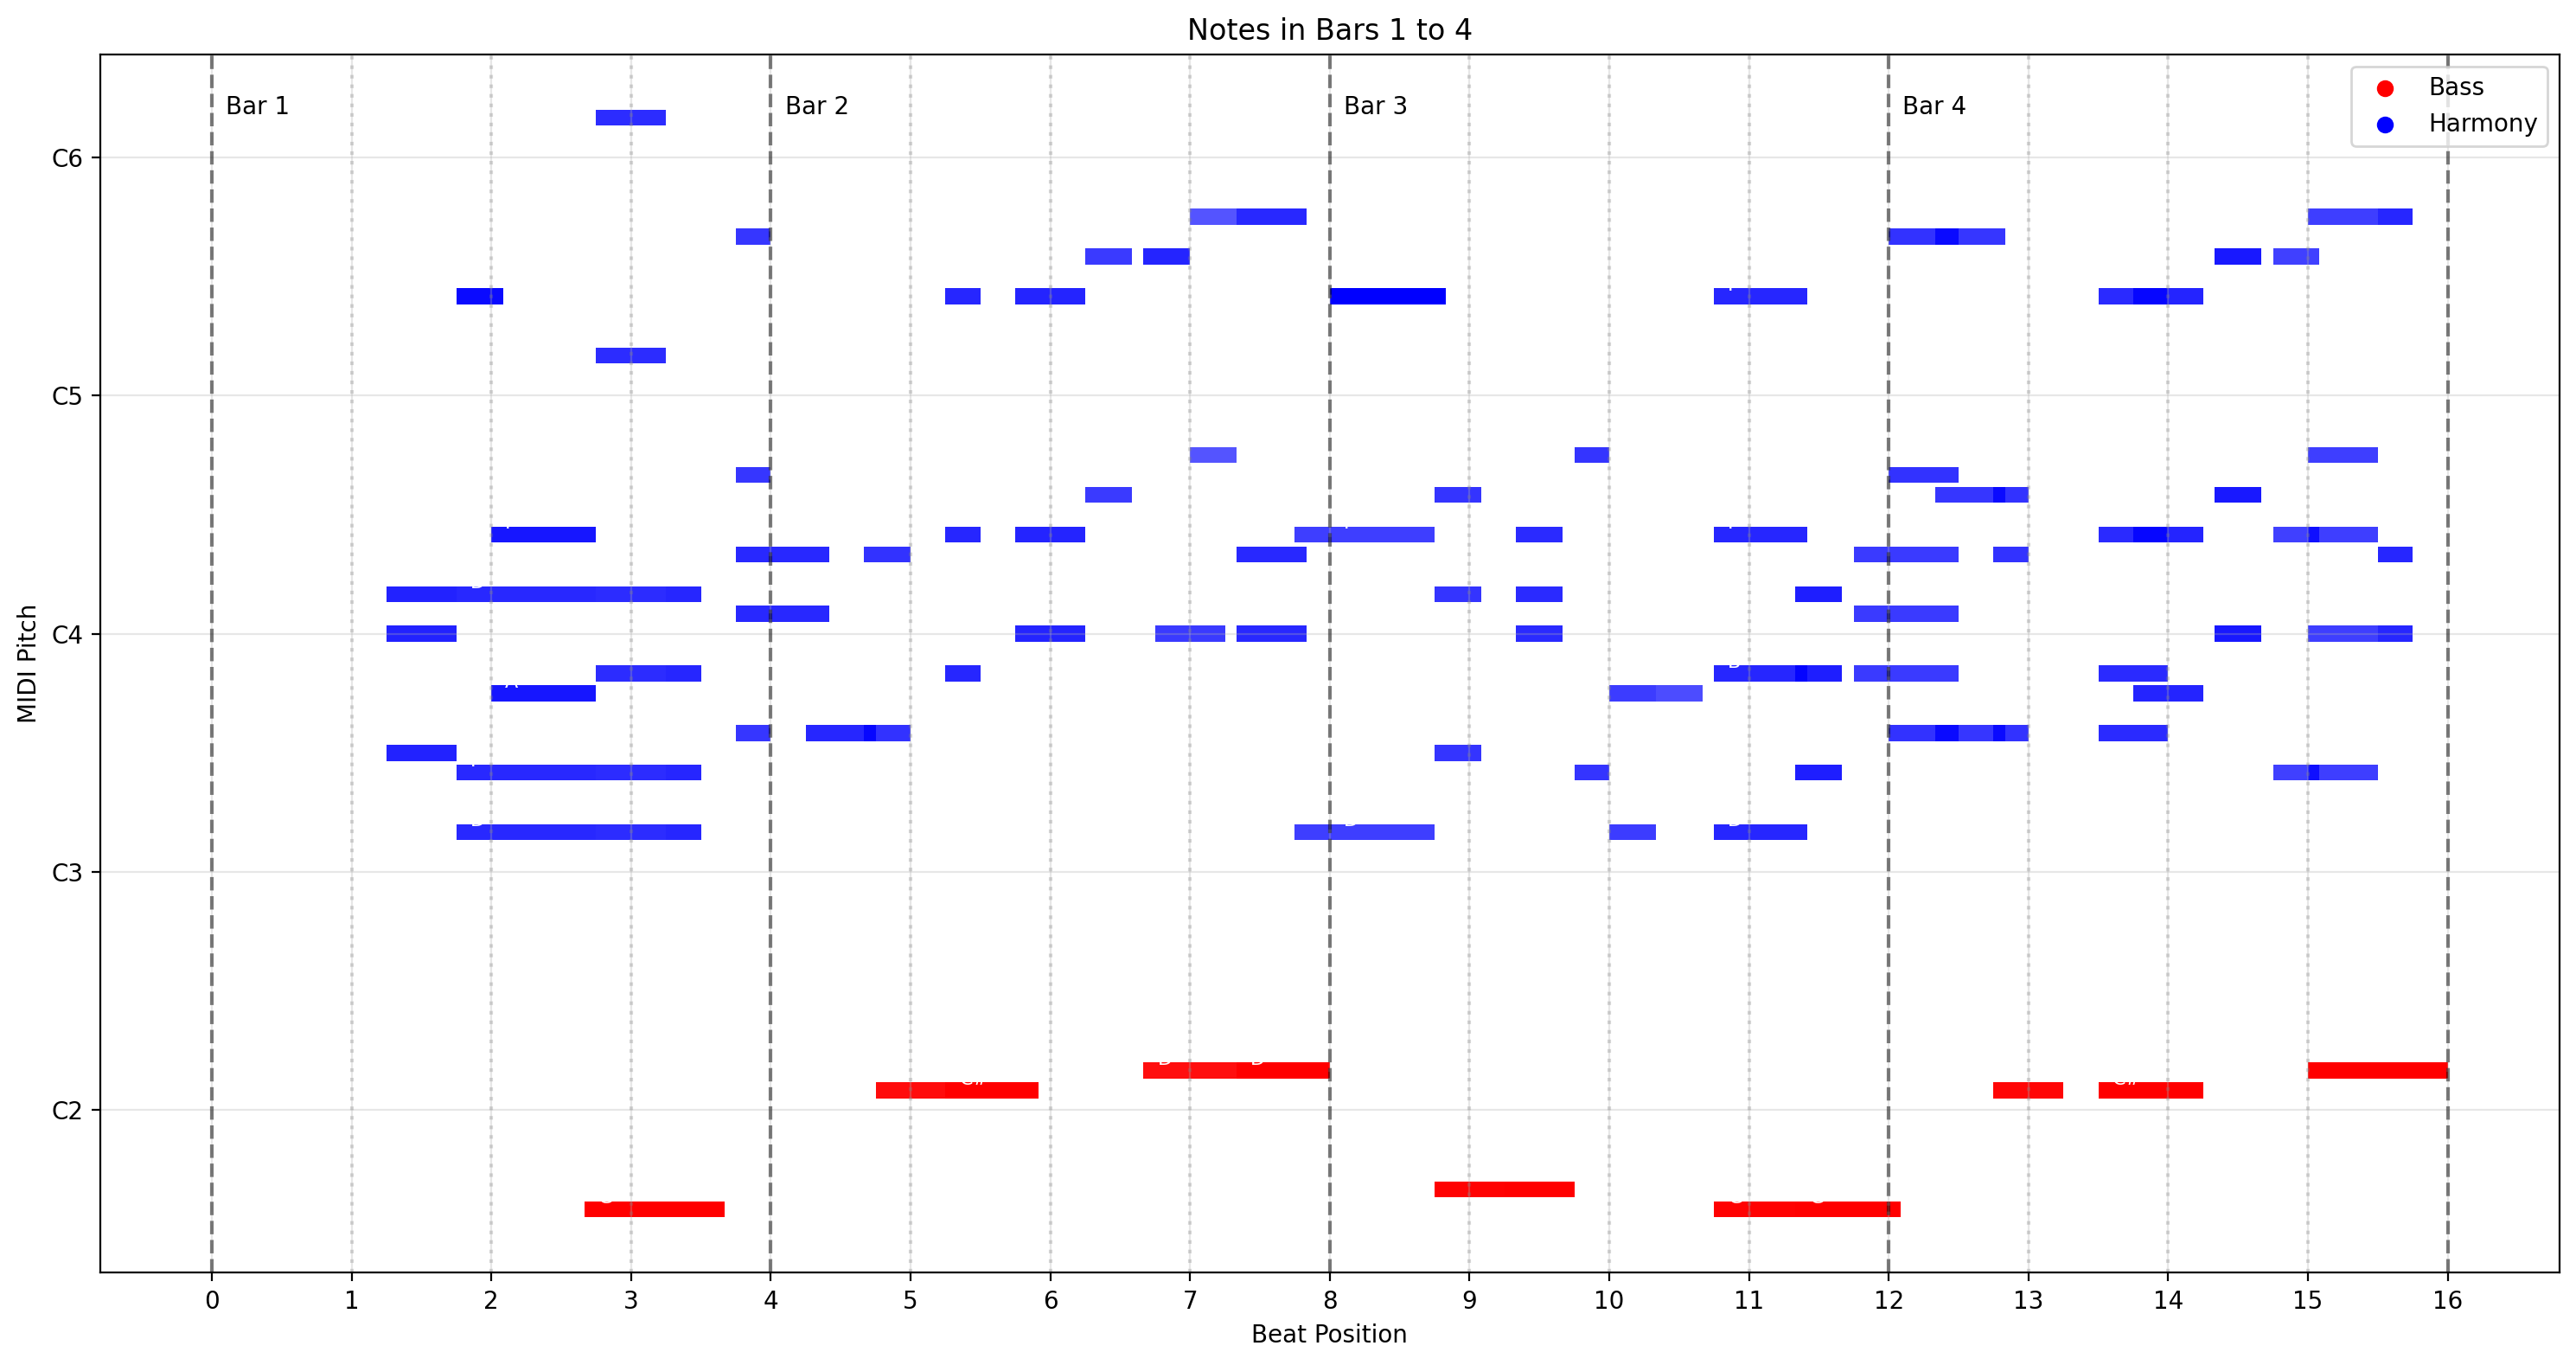


=== Analyzing Bar 1 with Time Windows ===

Bass notes in bar 1:
  G (PC 7): 2.67-3.67


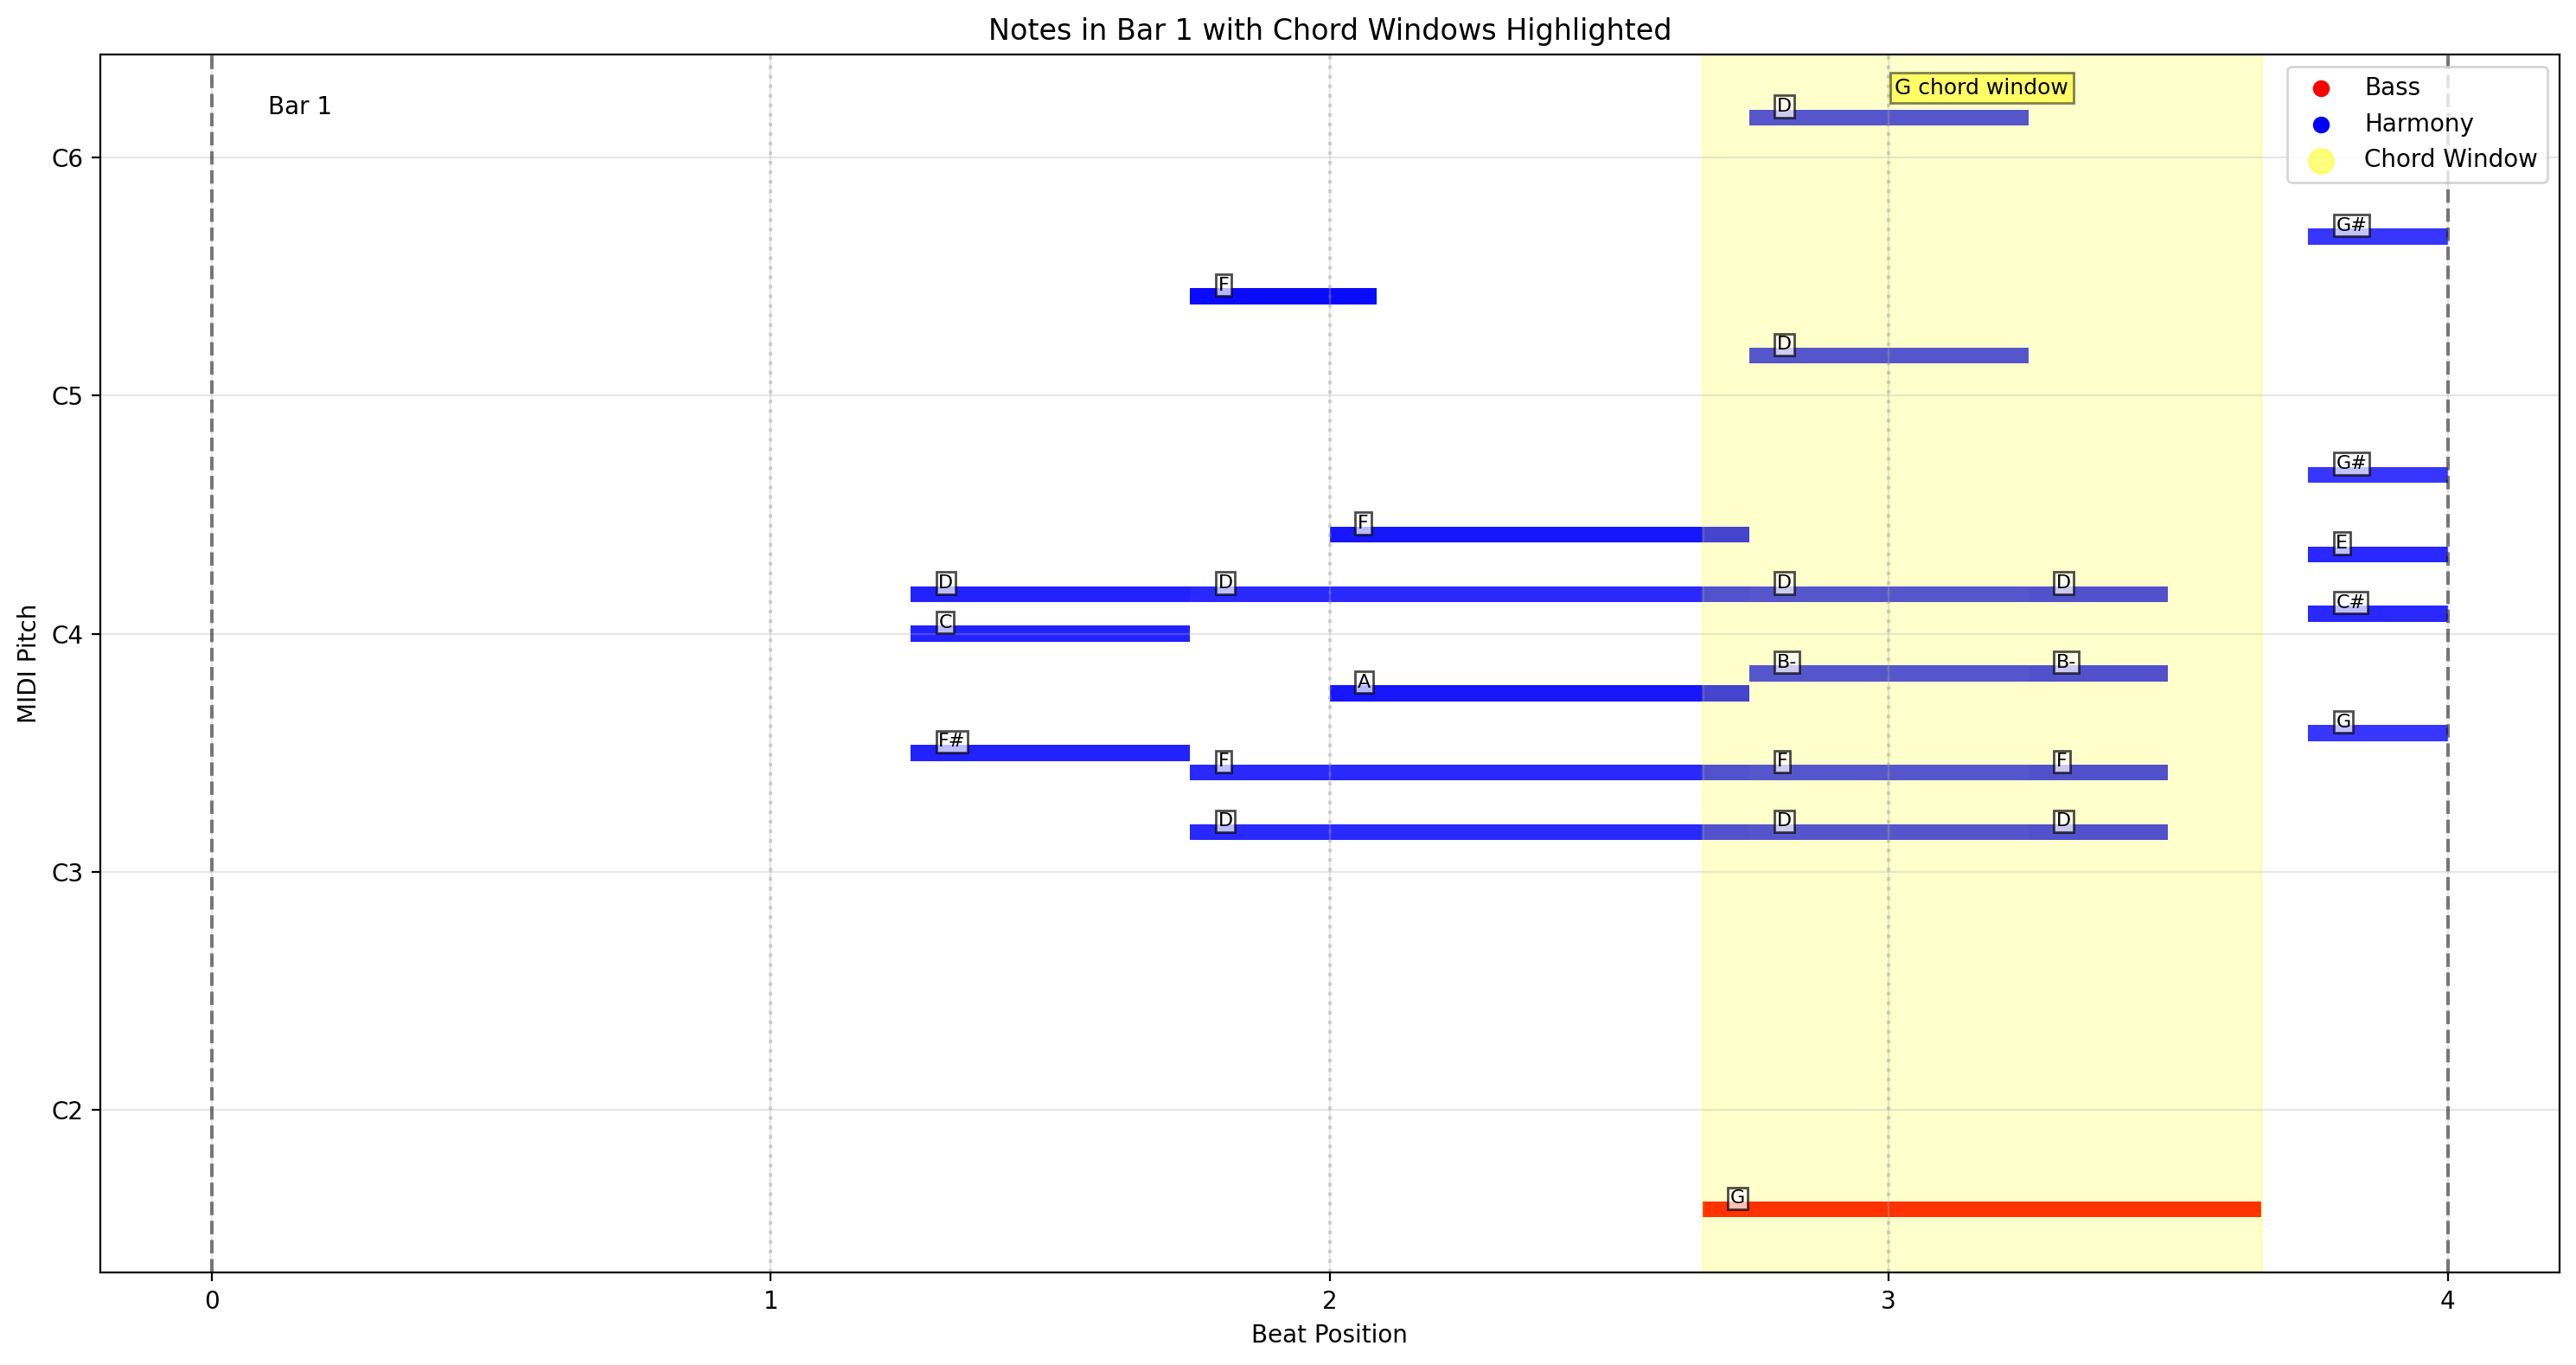

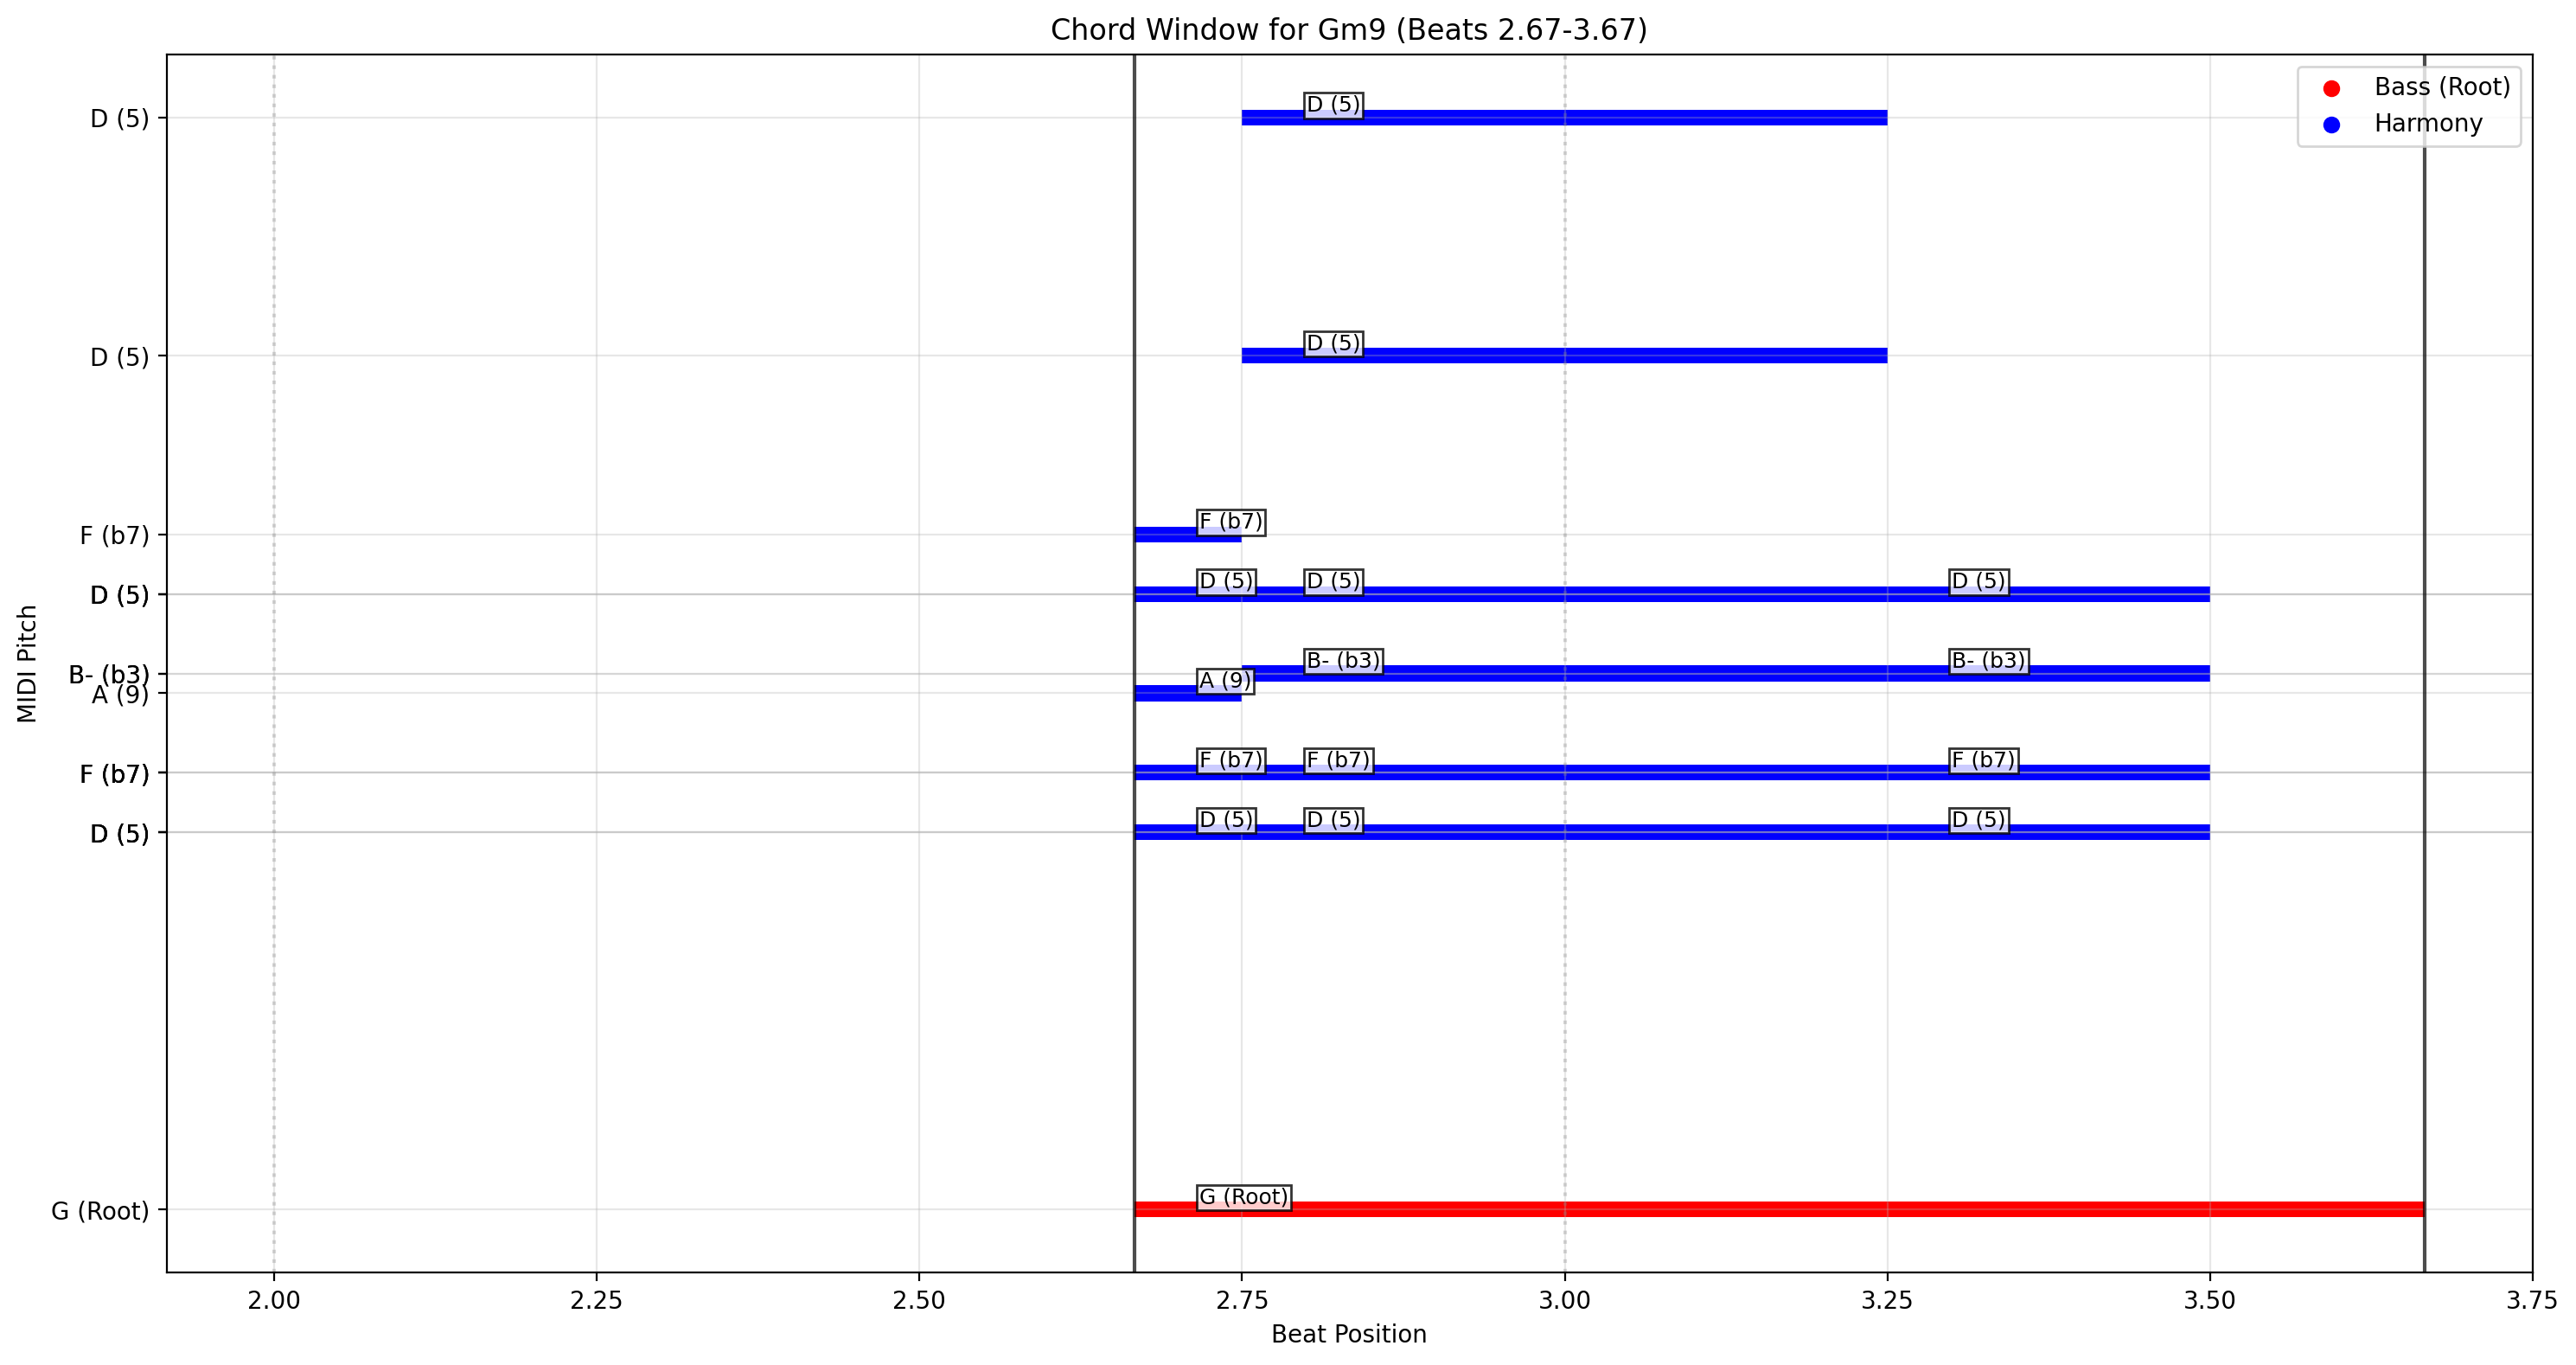


Bass note window 1: G (2.67-3.67)
  Active harmony notes: ['D', 'D', 'F', 'A', 'F', 'D', 'F', 'B-', 'D', 'D', 'D', 'D', 'F', 'D', 'B-']
  Intervals: [0, 2, 3, 7, 10]
  Identified chord: Gm9


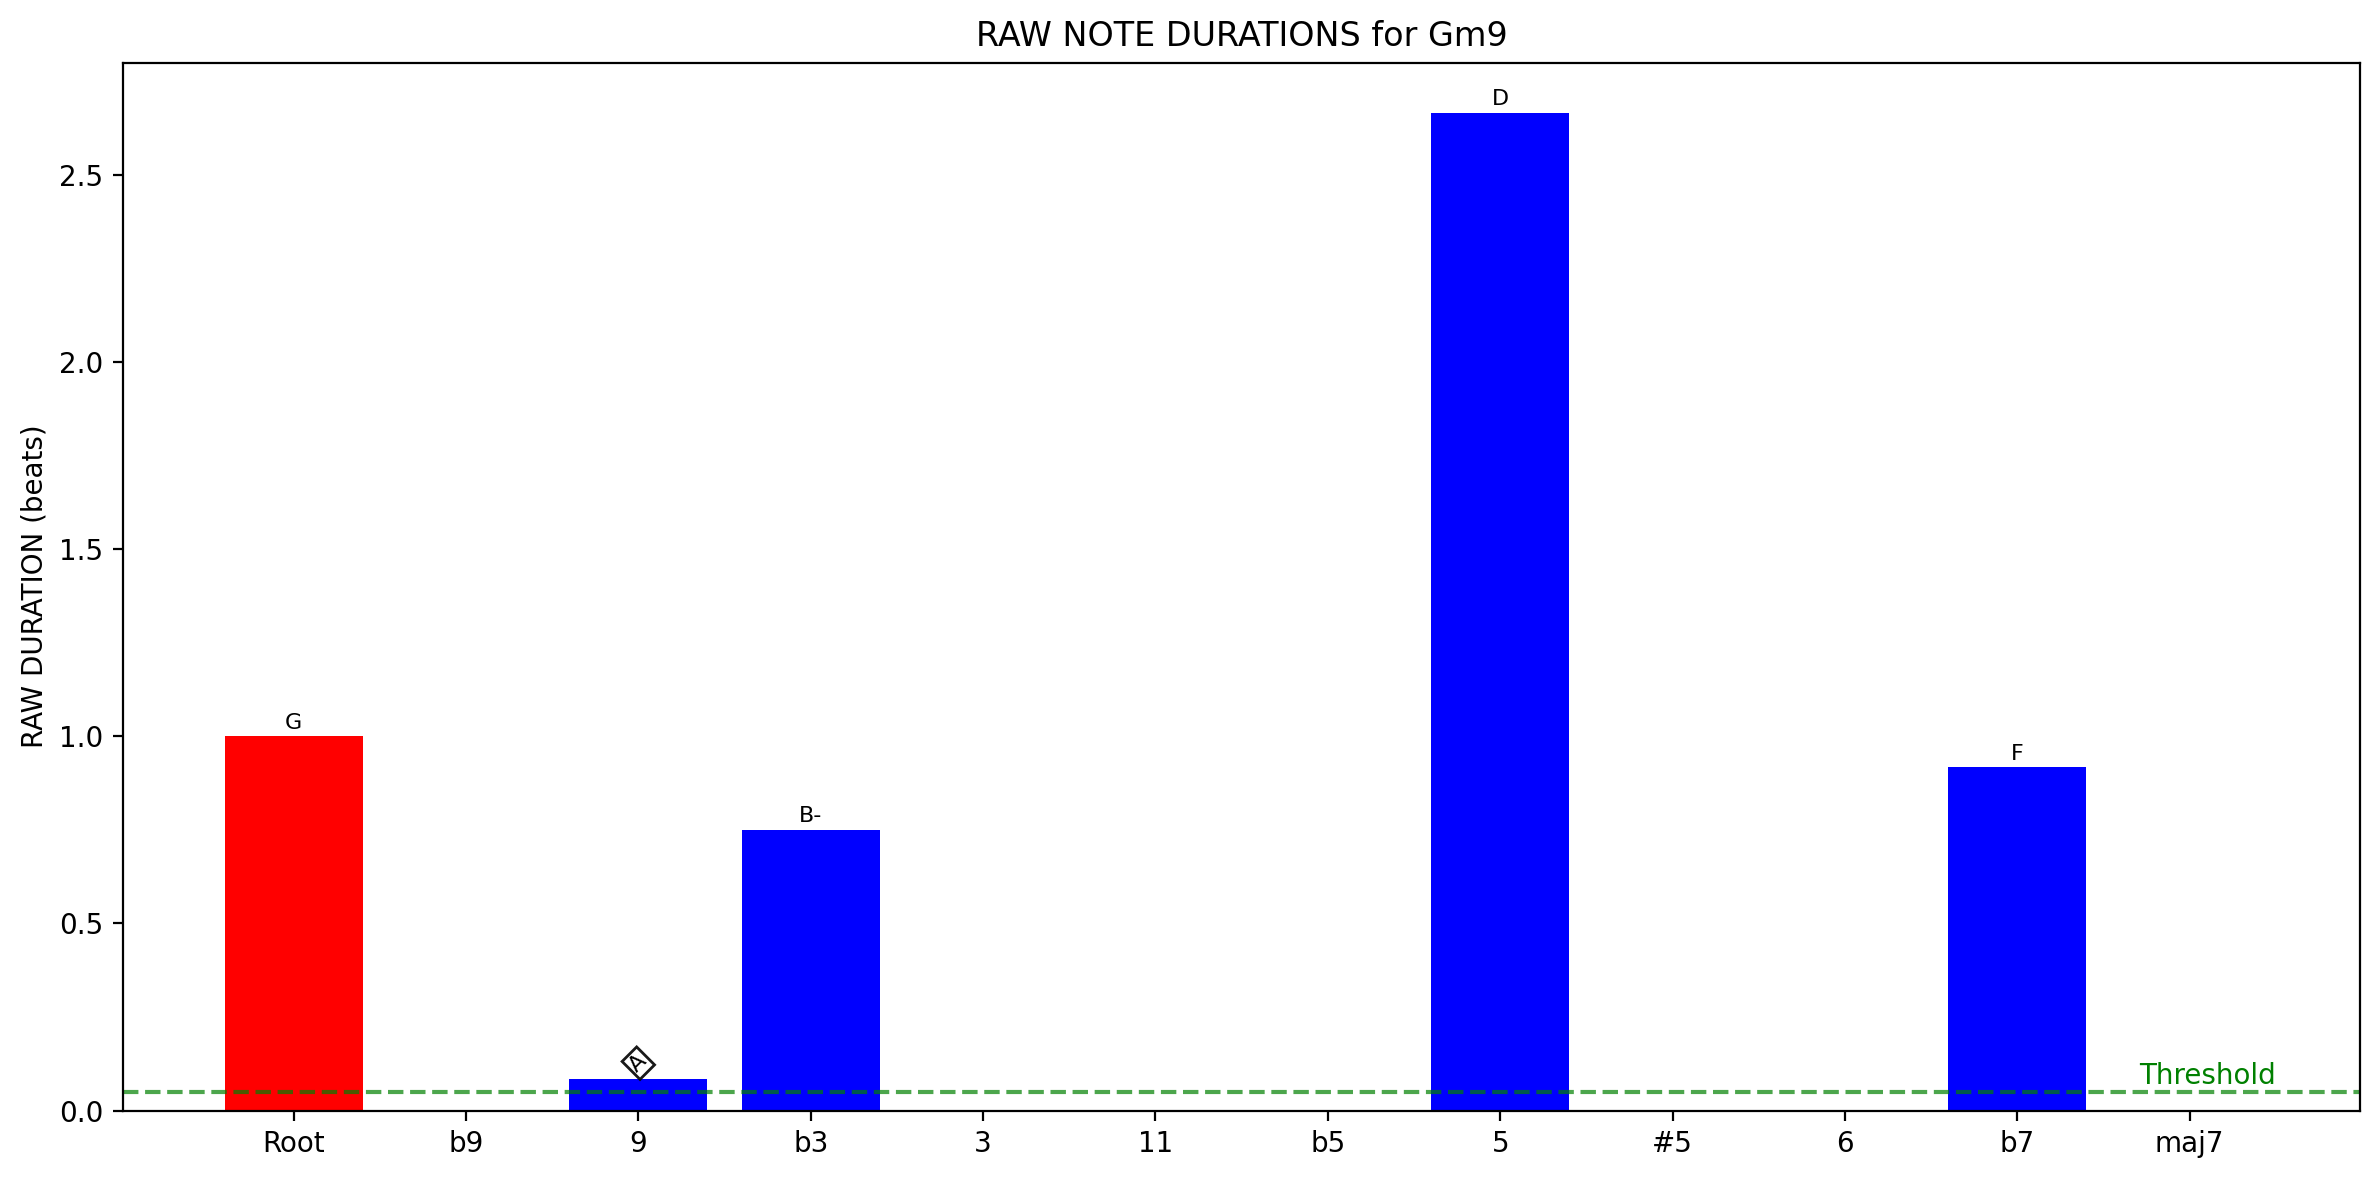


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
7        5      2.667      D
0        Root   1.000      G
10       b7     0.917      F
3        b3     0.750      B-
2        9      0.083      A

=== Analyzing Bar 2 with Time Windows ===

Bass notes in bar 2:
  C# (PC 1): 4.75-5.25
  C# (PC 1): 5.25-5.92
  D (PC 2): 6.67-7.33
  D (PC 2): 7.33-8.00


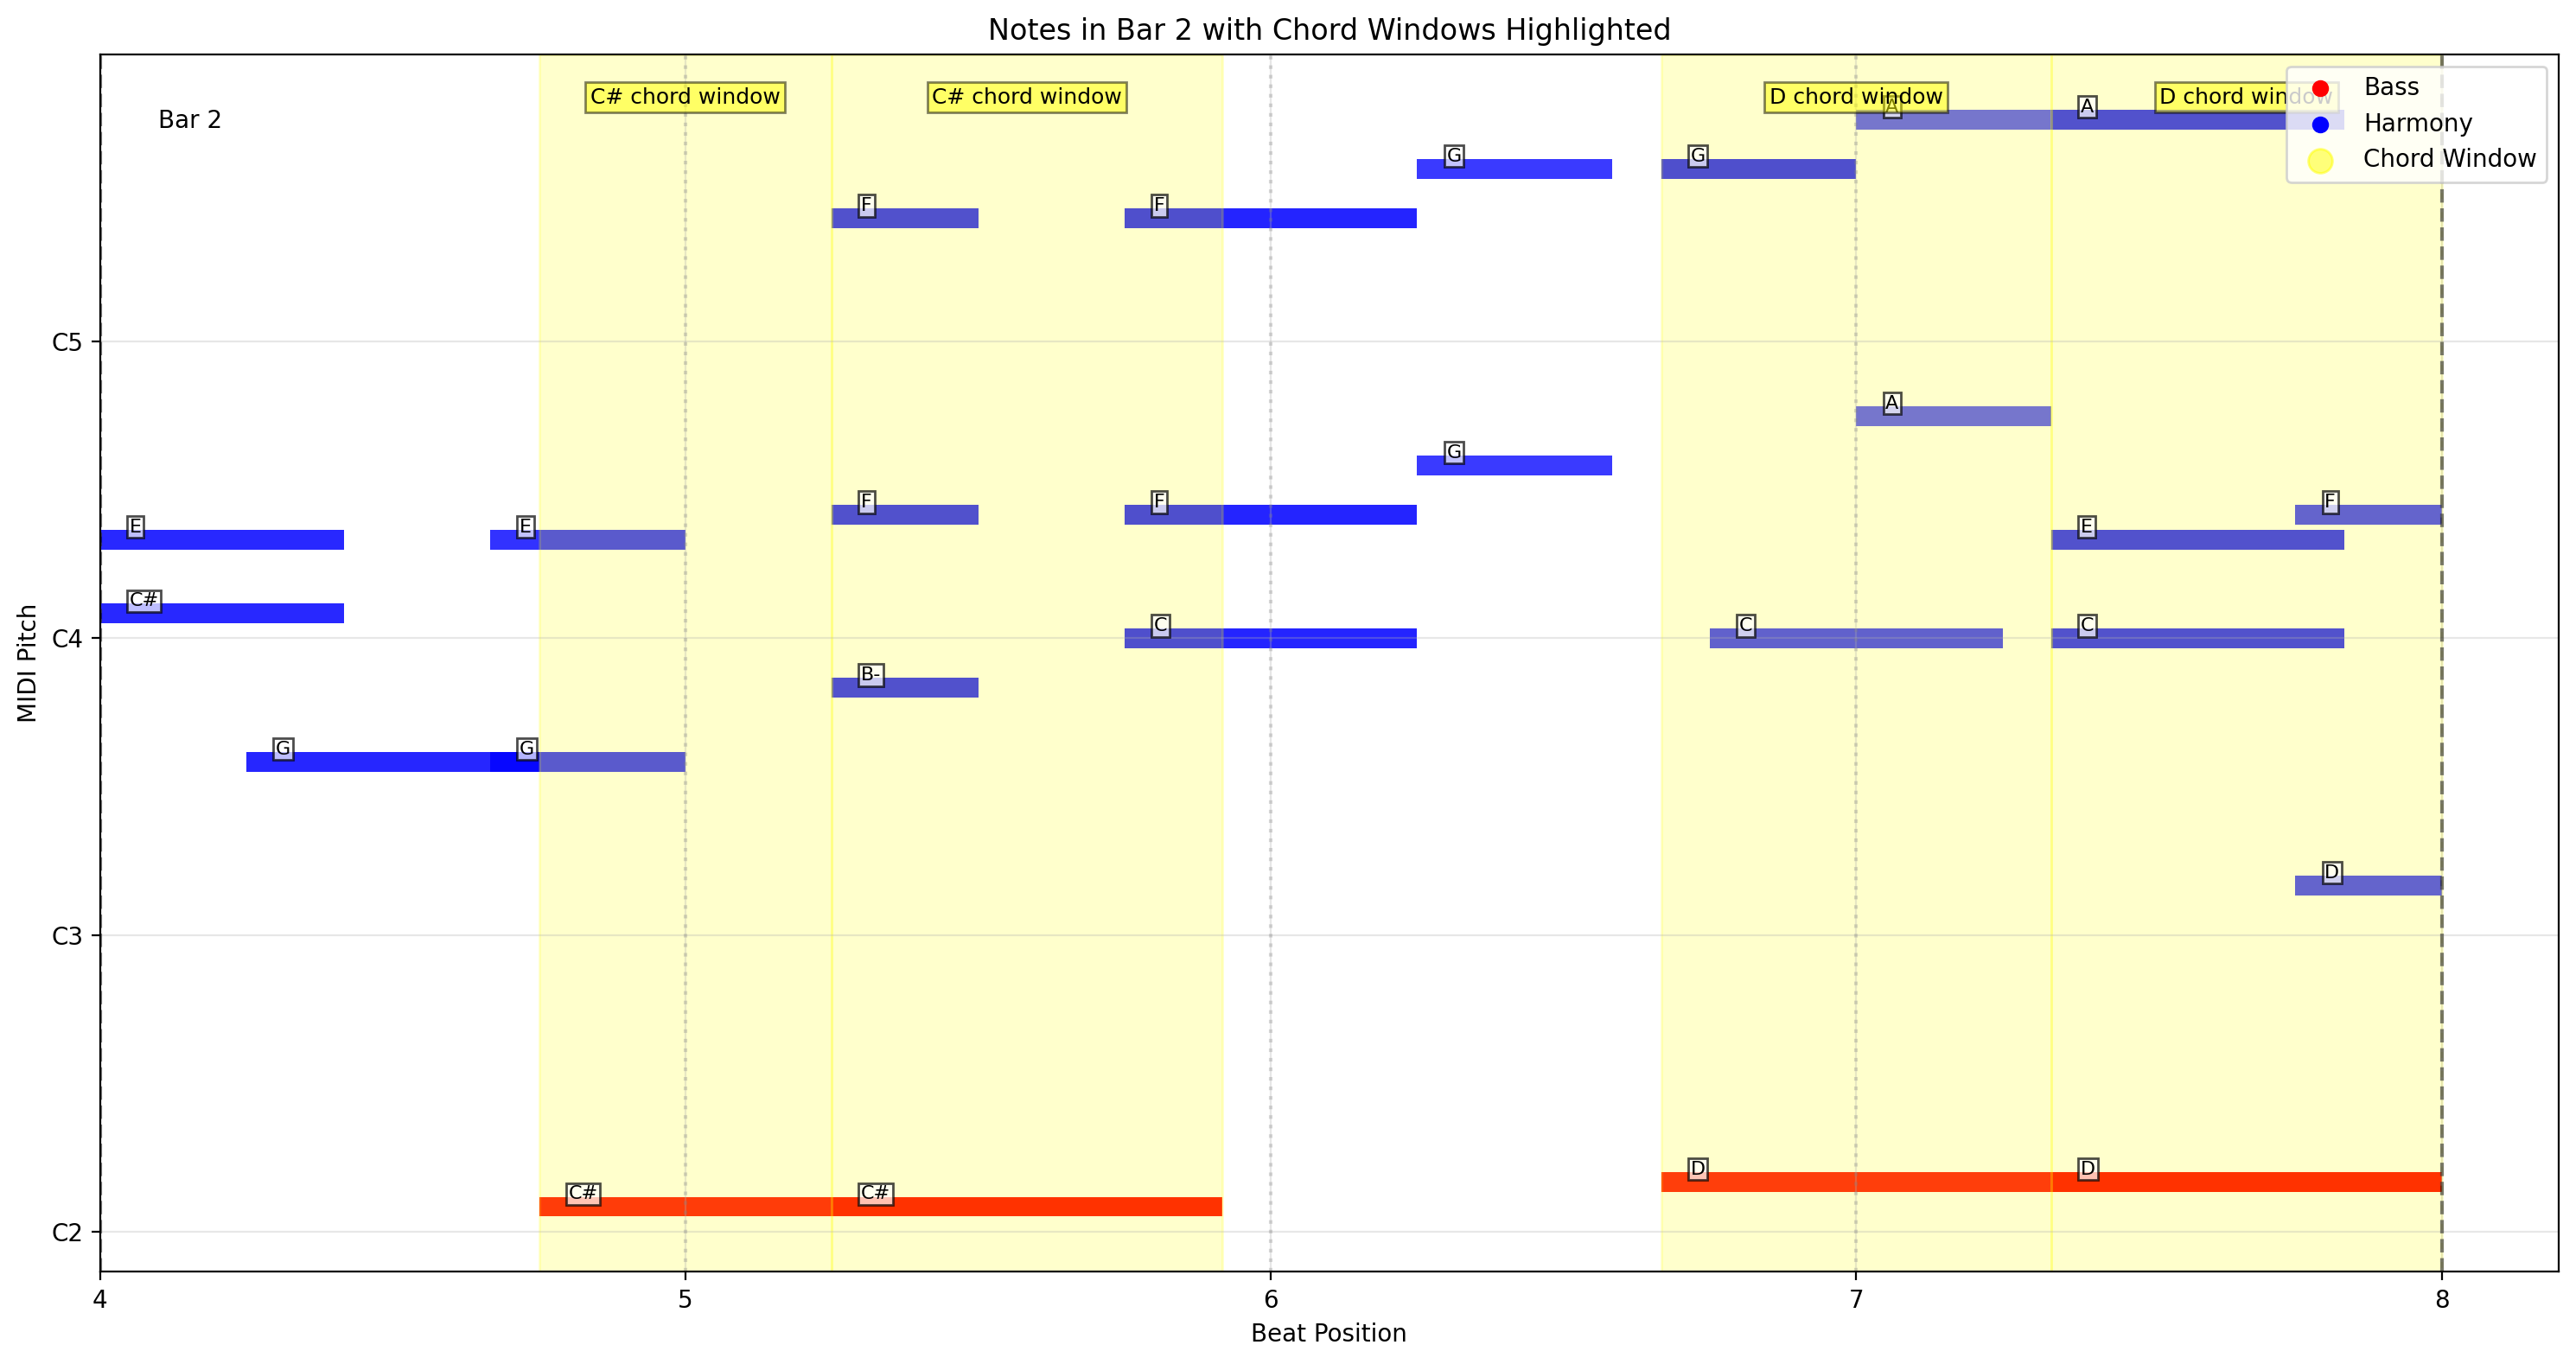

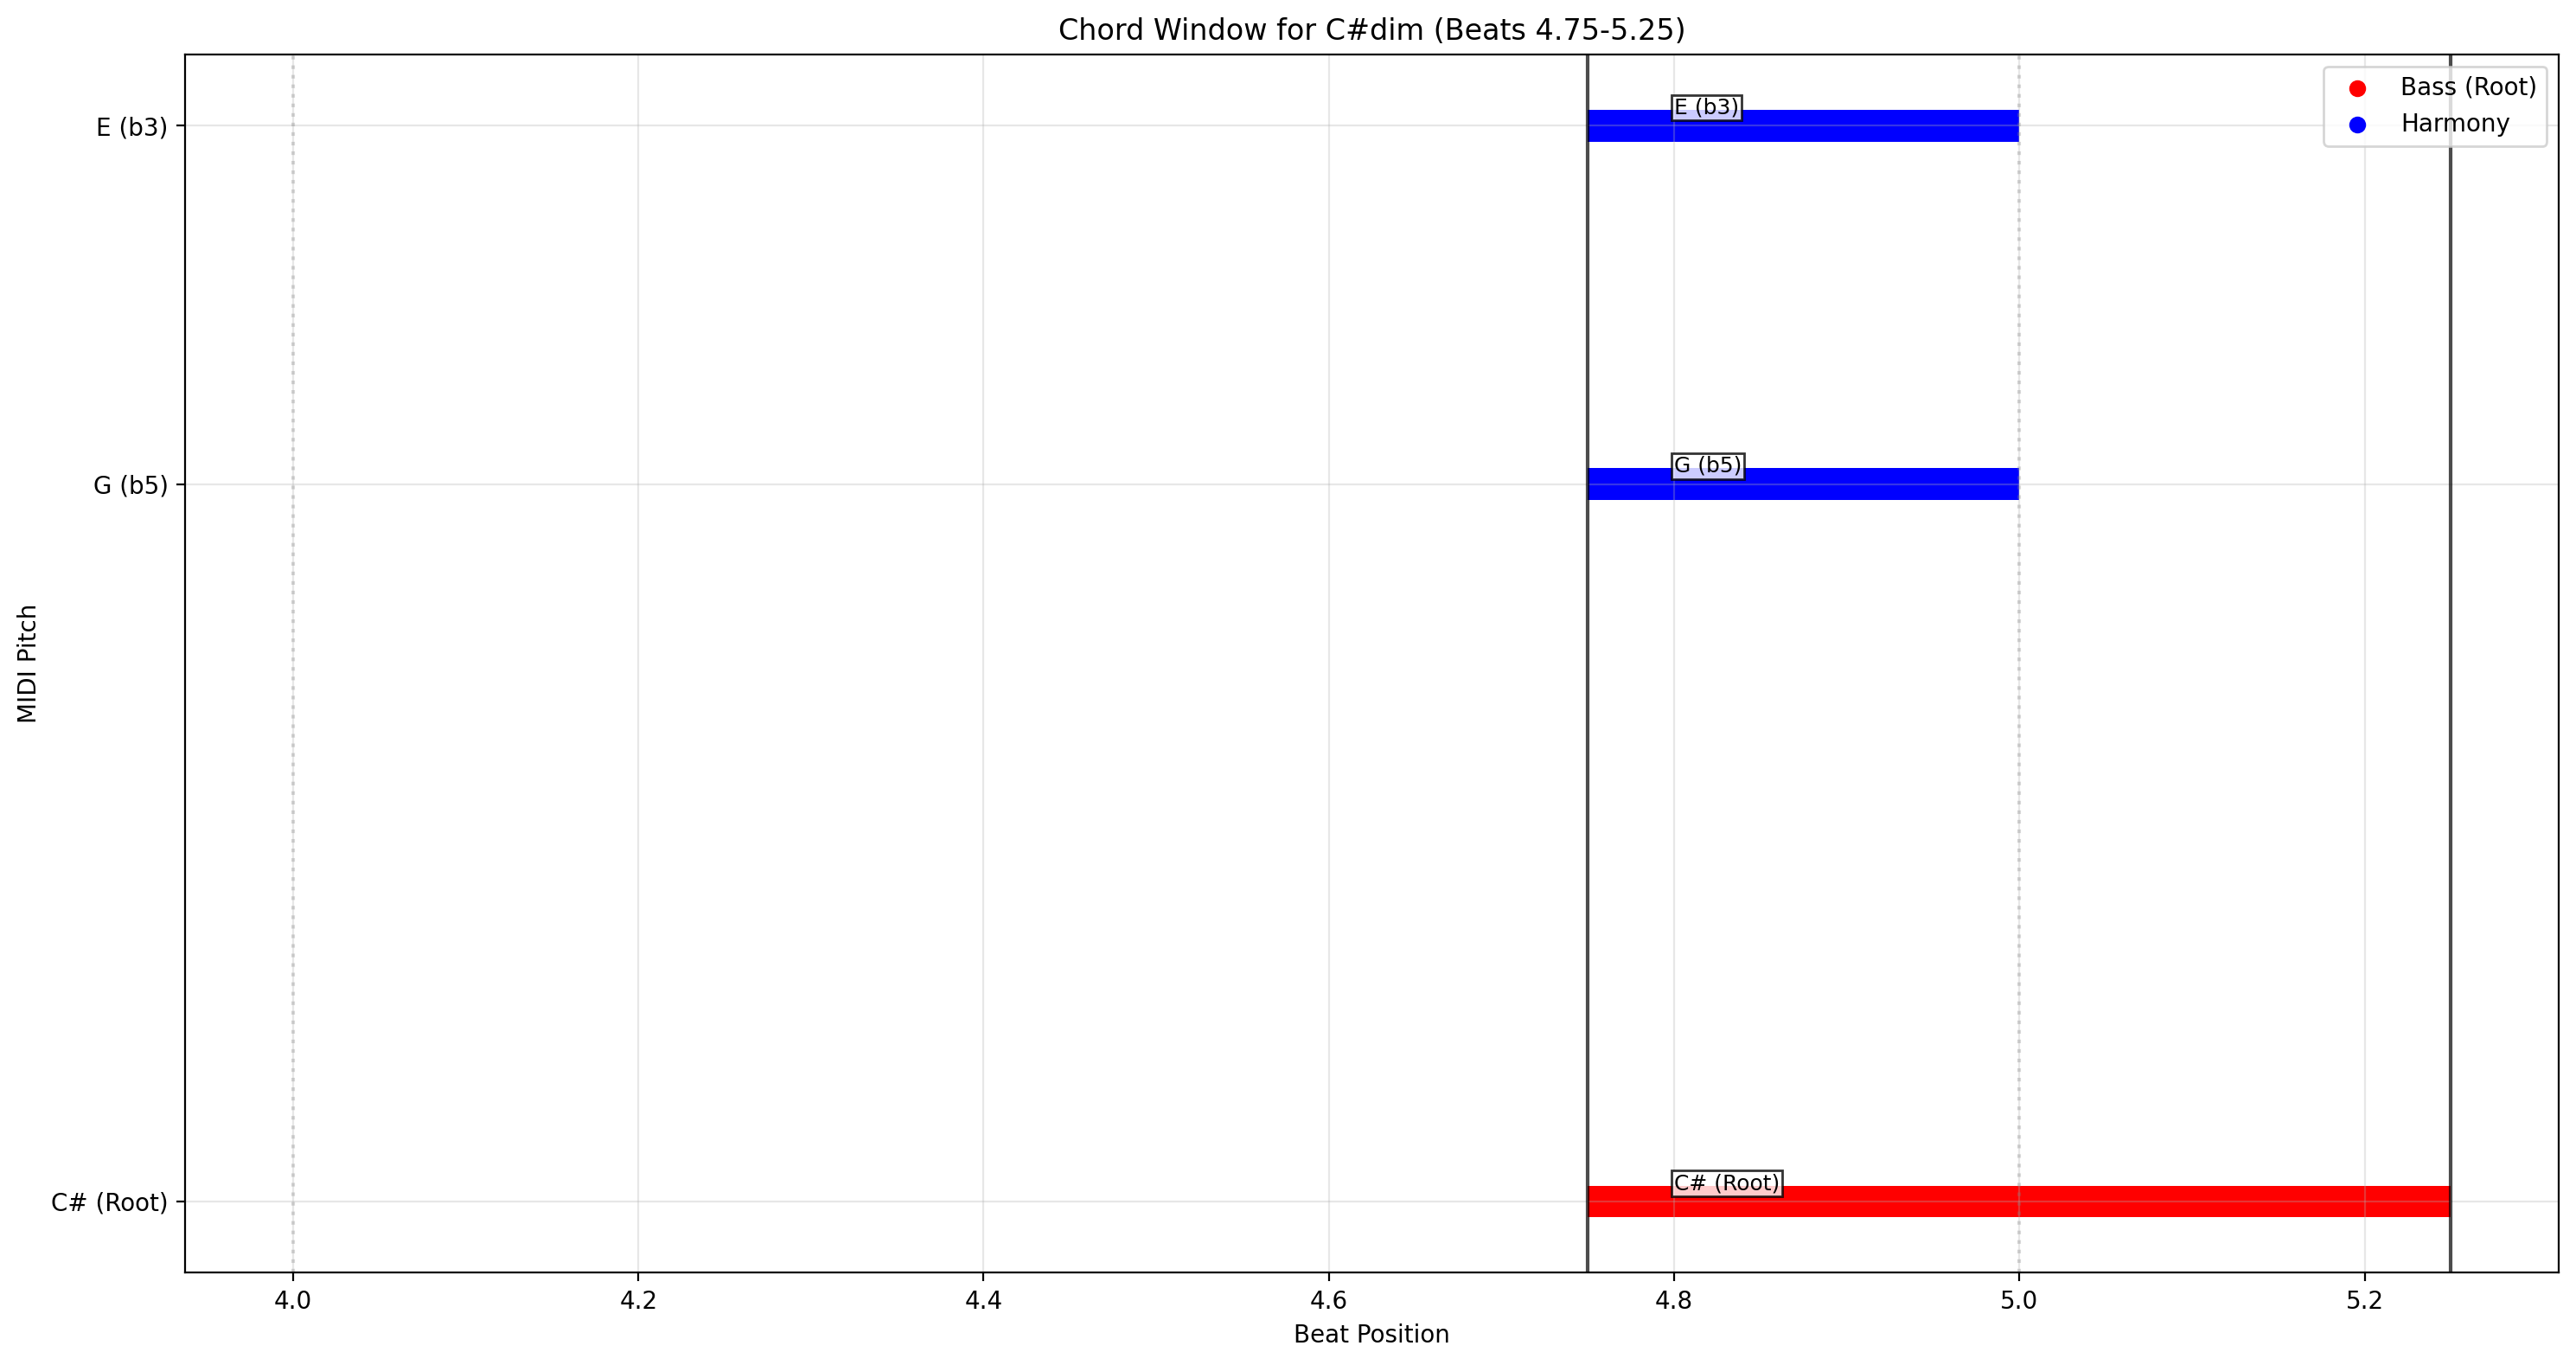


Bass note window 1: C# (4.75-5.25)
  Active harmony notes: ['G', 'E']
  Intervals: [0, 3, 6]
  Identified chord: C#dim


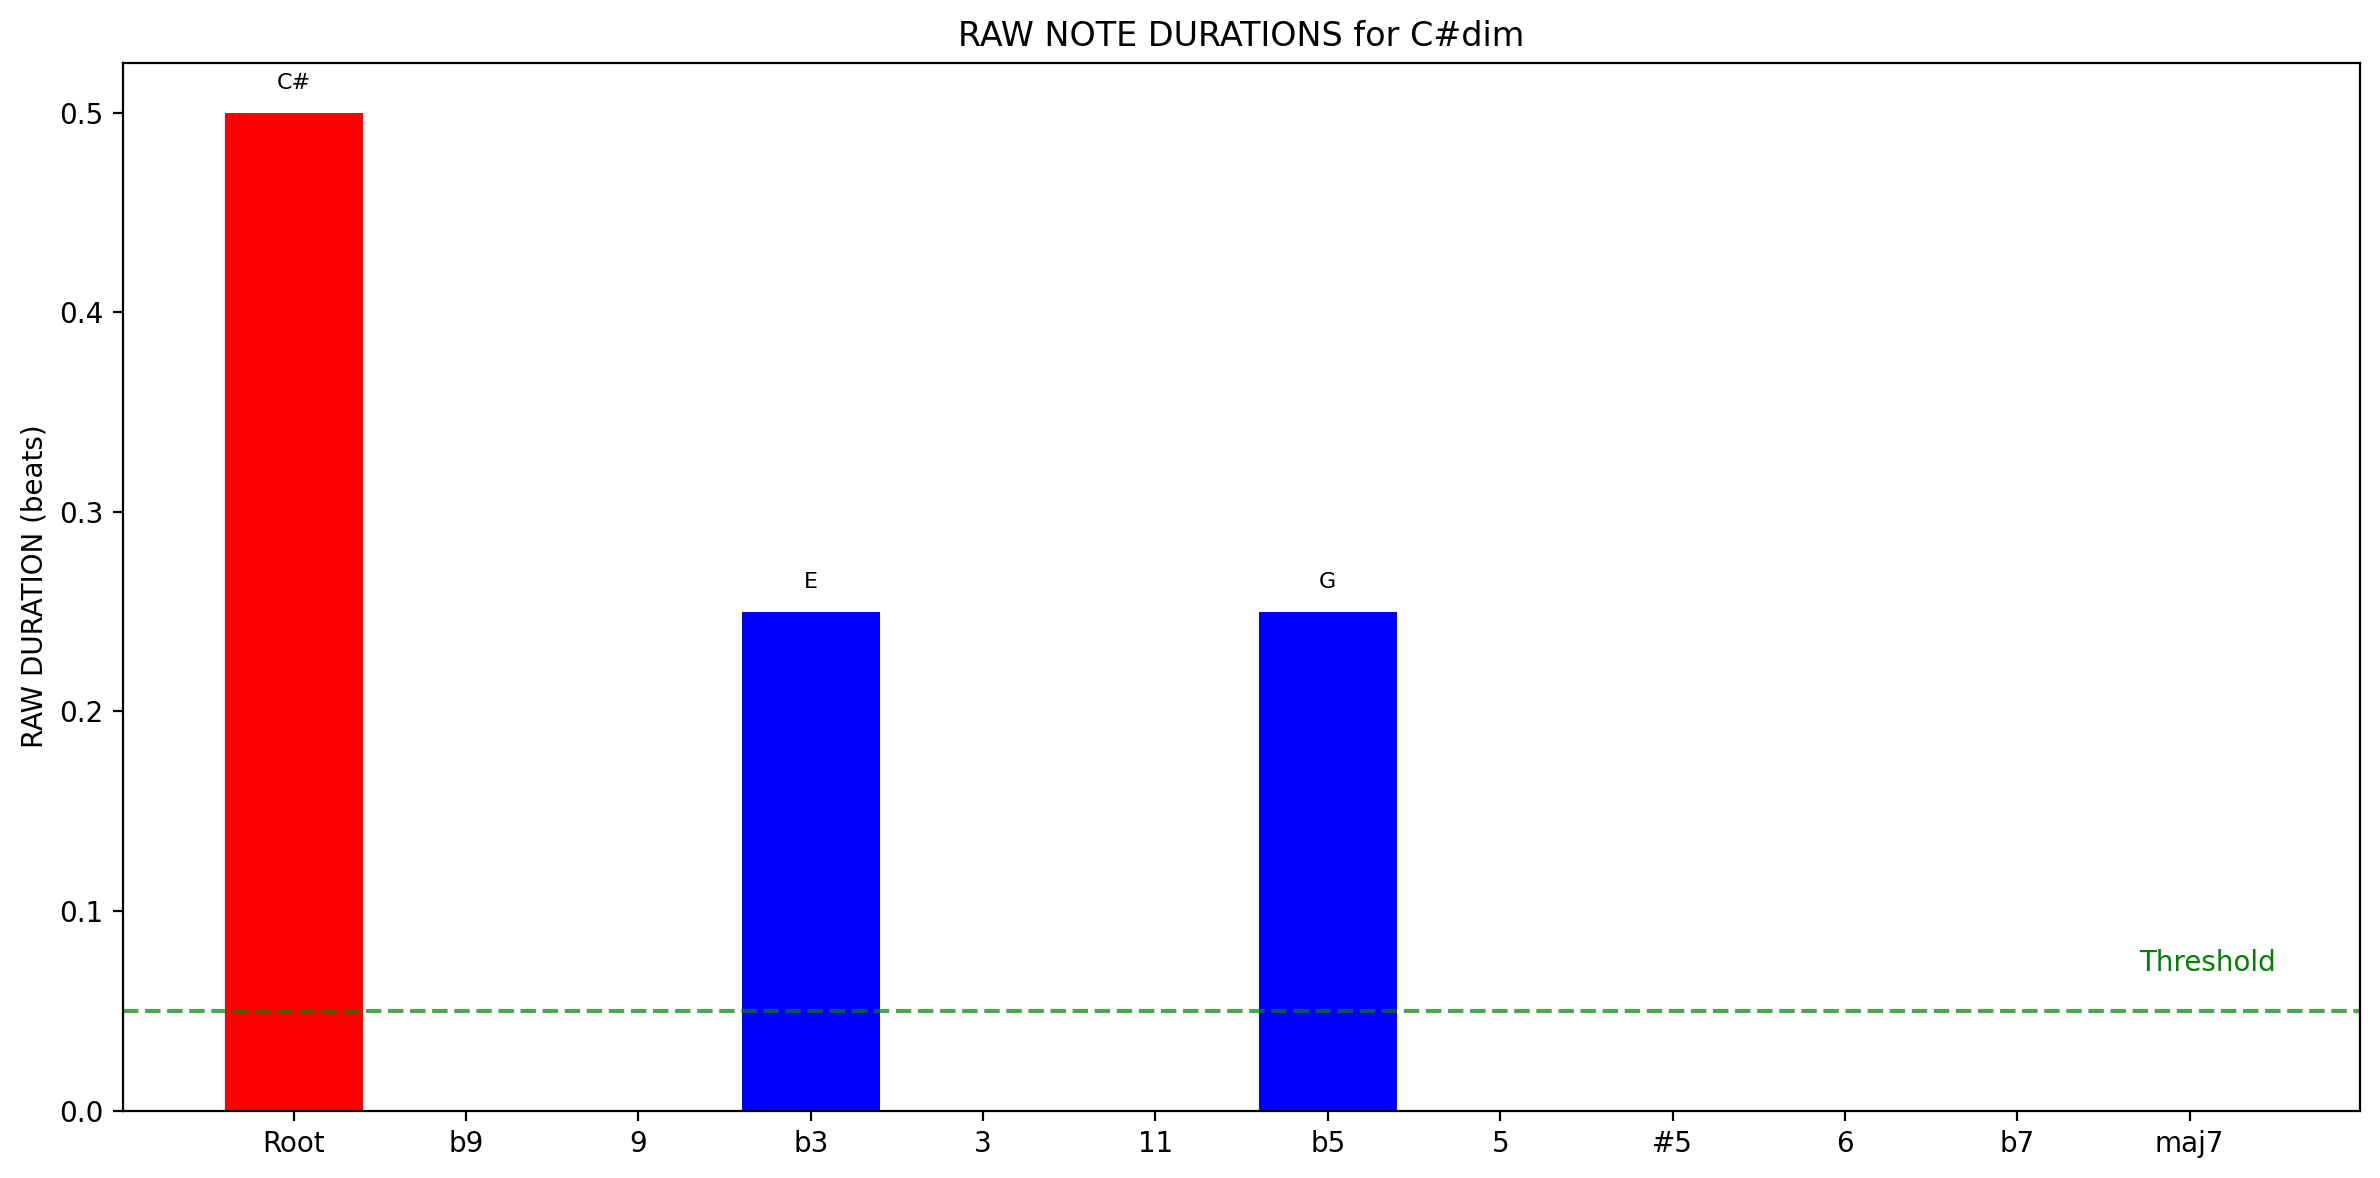


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.500      C#
3        b3     0.250      E
6        b5     0.250      G


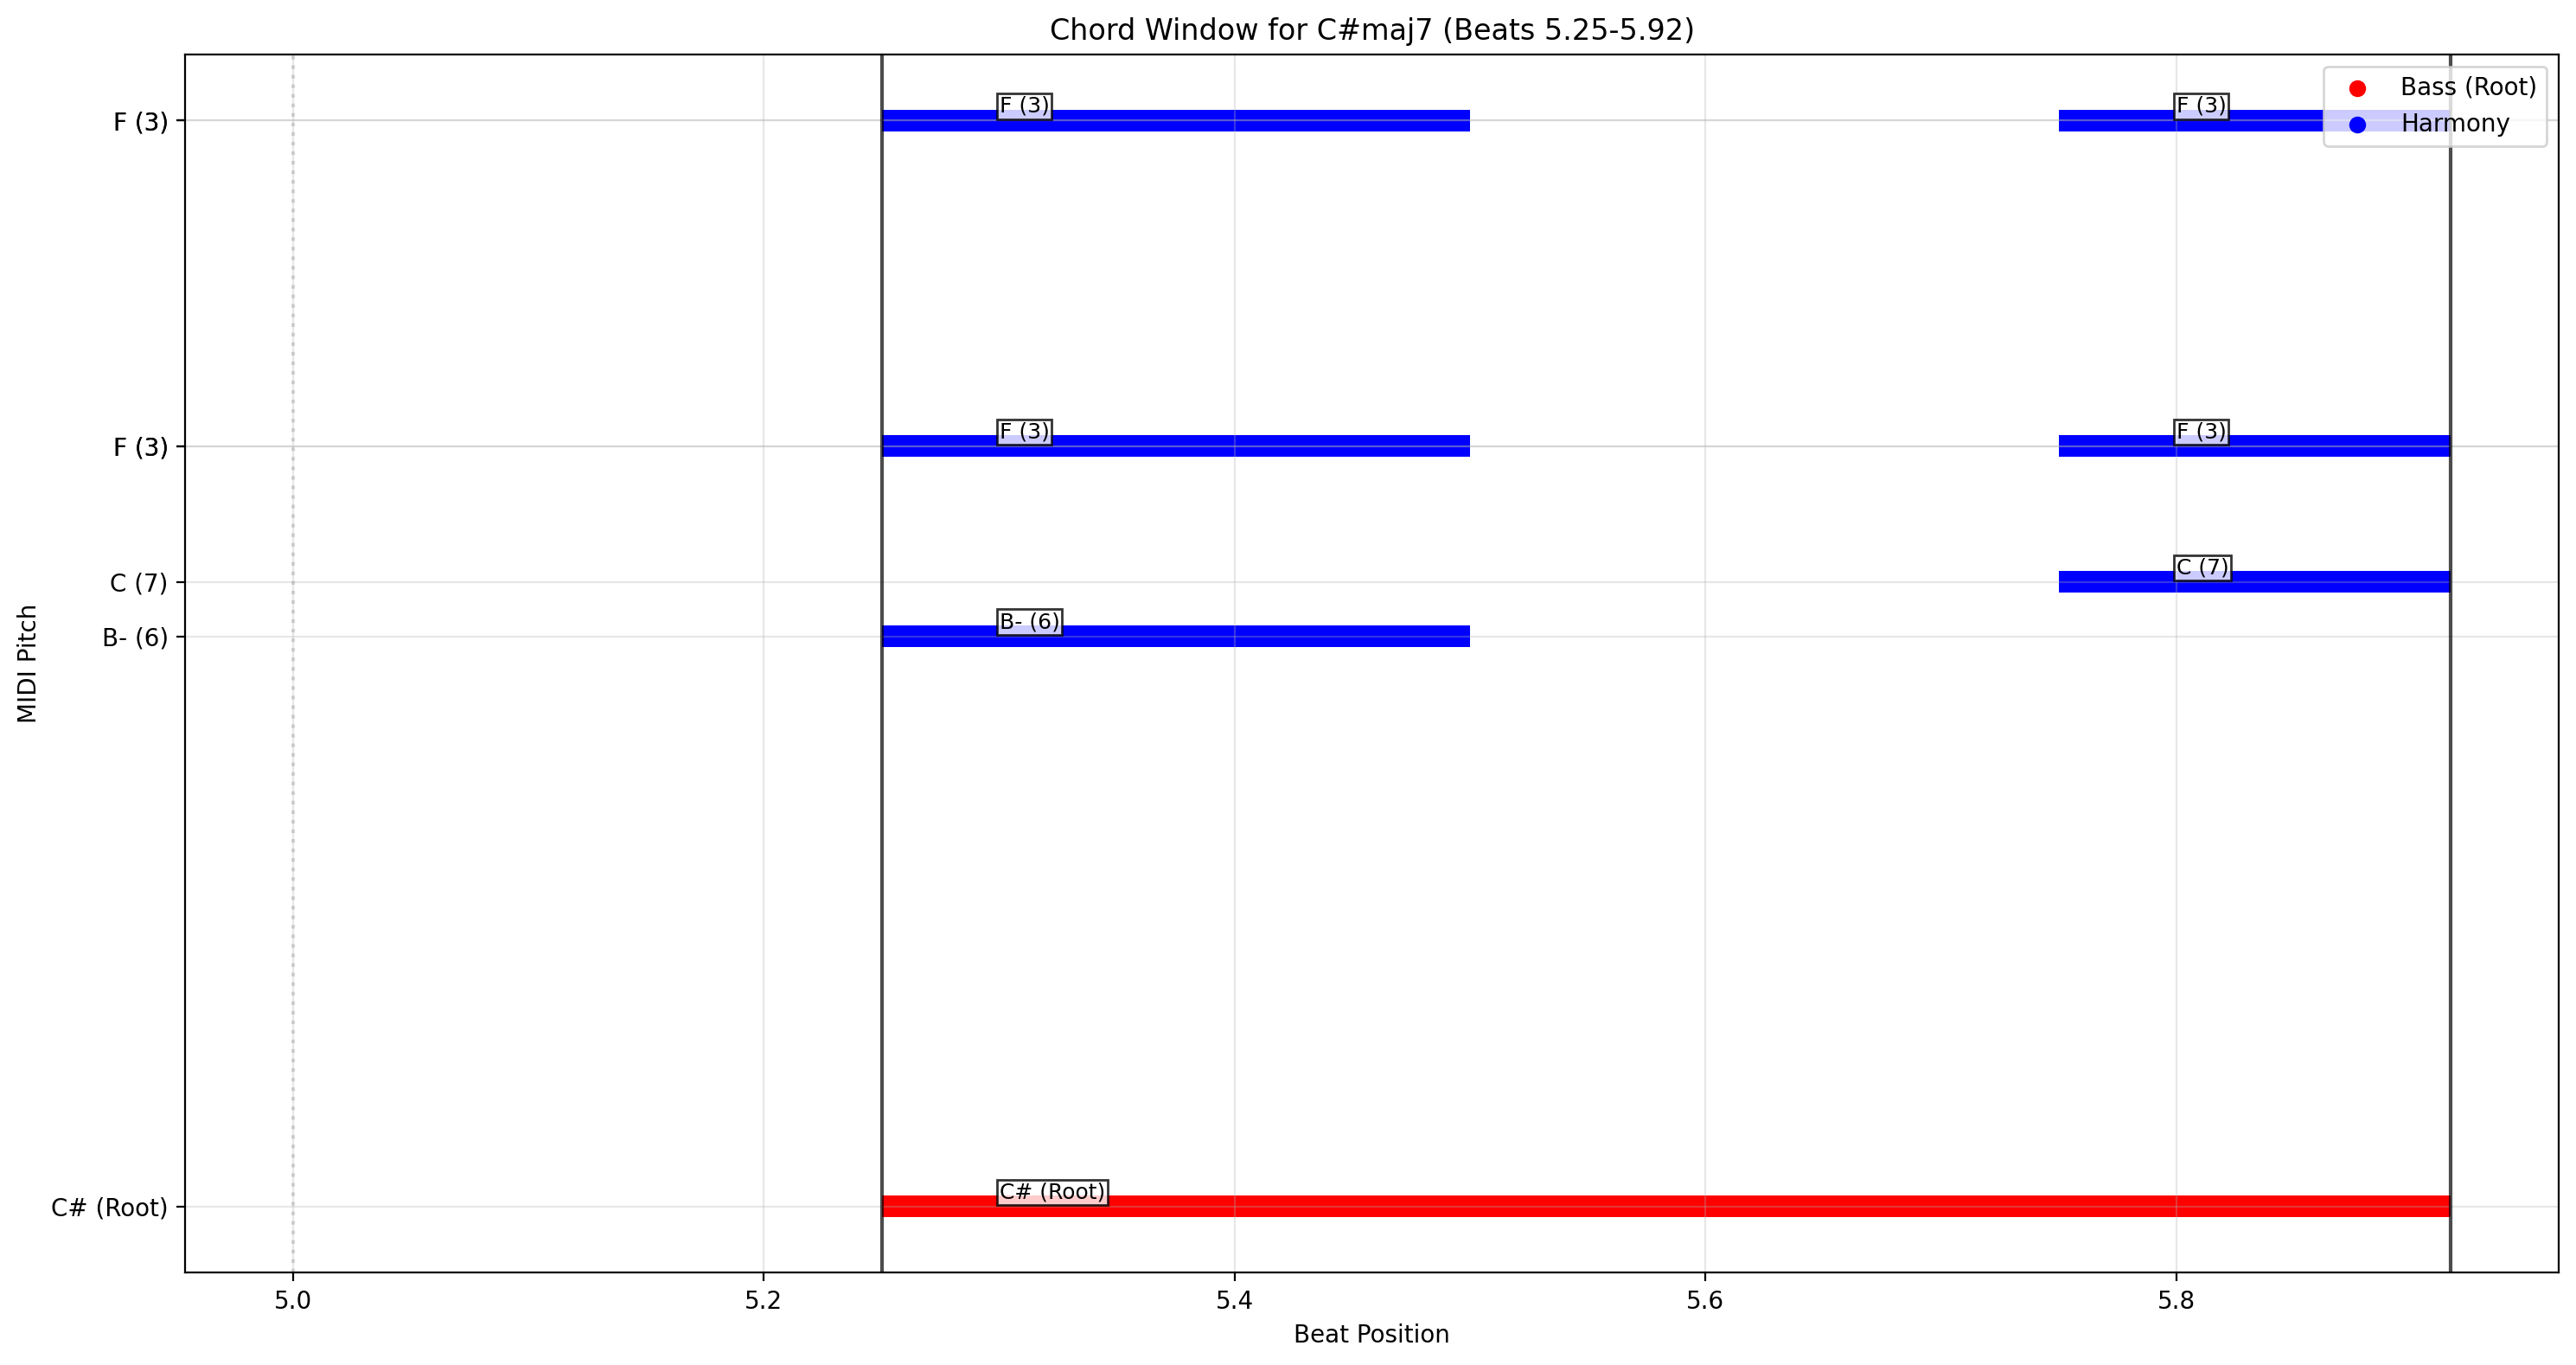


Bass note window 2: C# (5.25-5.92)
  Active harmony notes: ['B-', 'F', 'F', 'C', 'F', 'F']
  Intervals: [0, 4, 9, 11]
  Identified chord: C#maj7


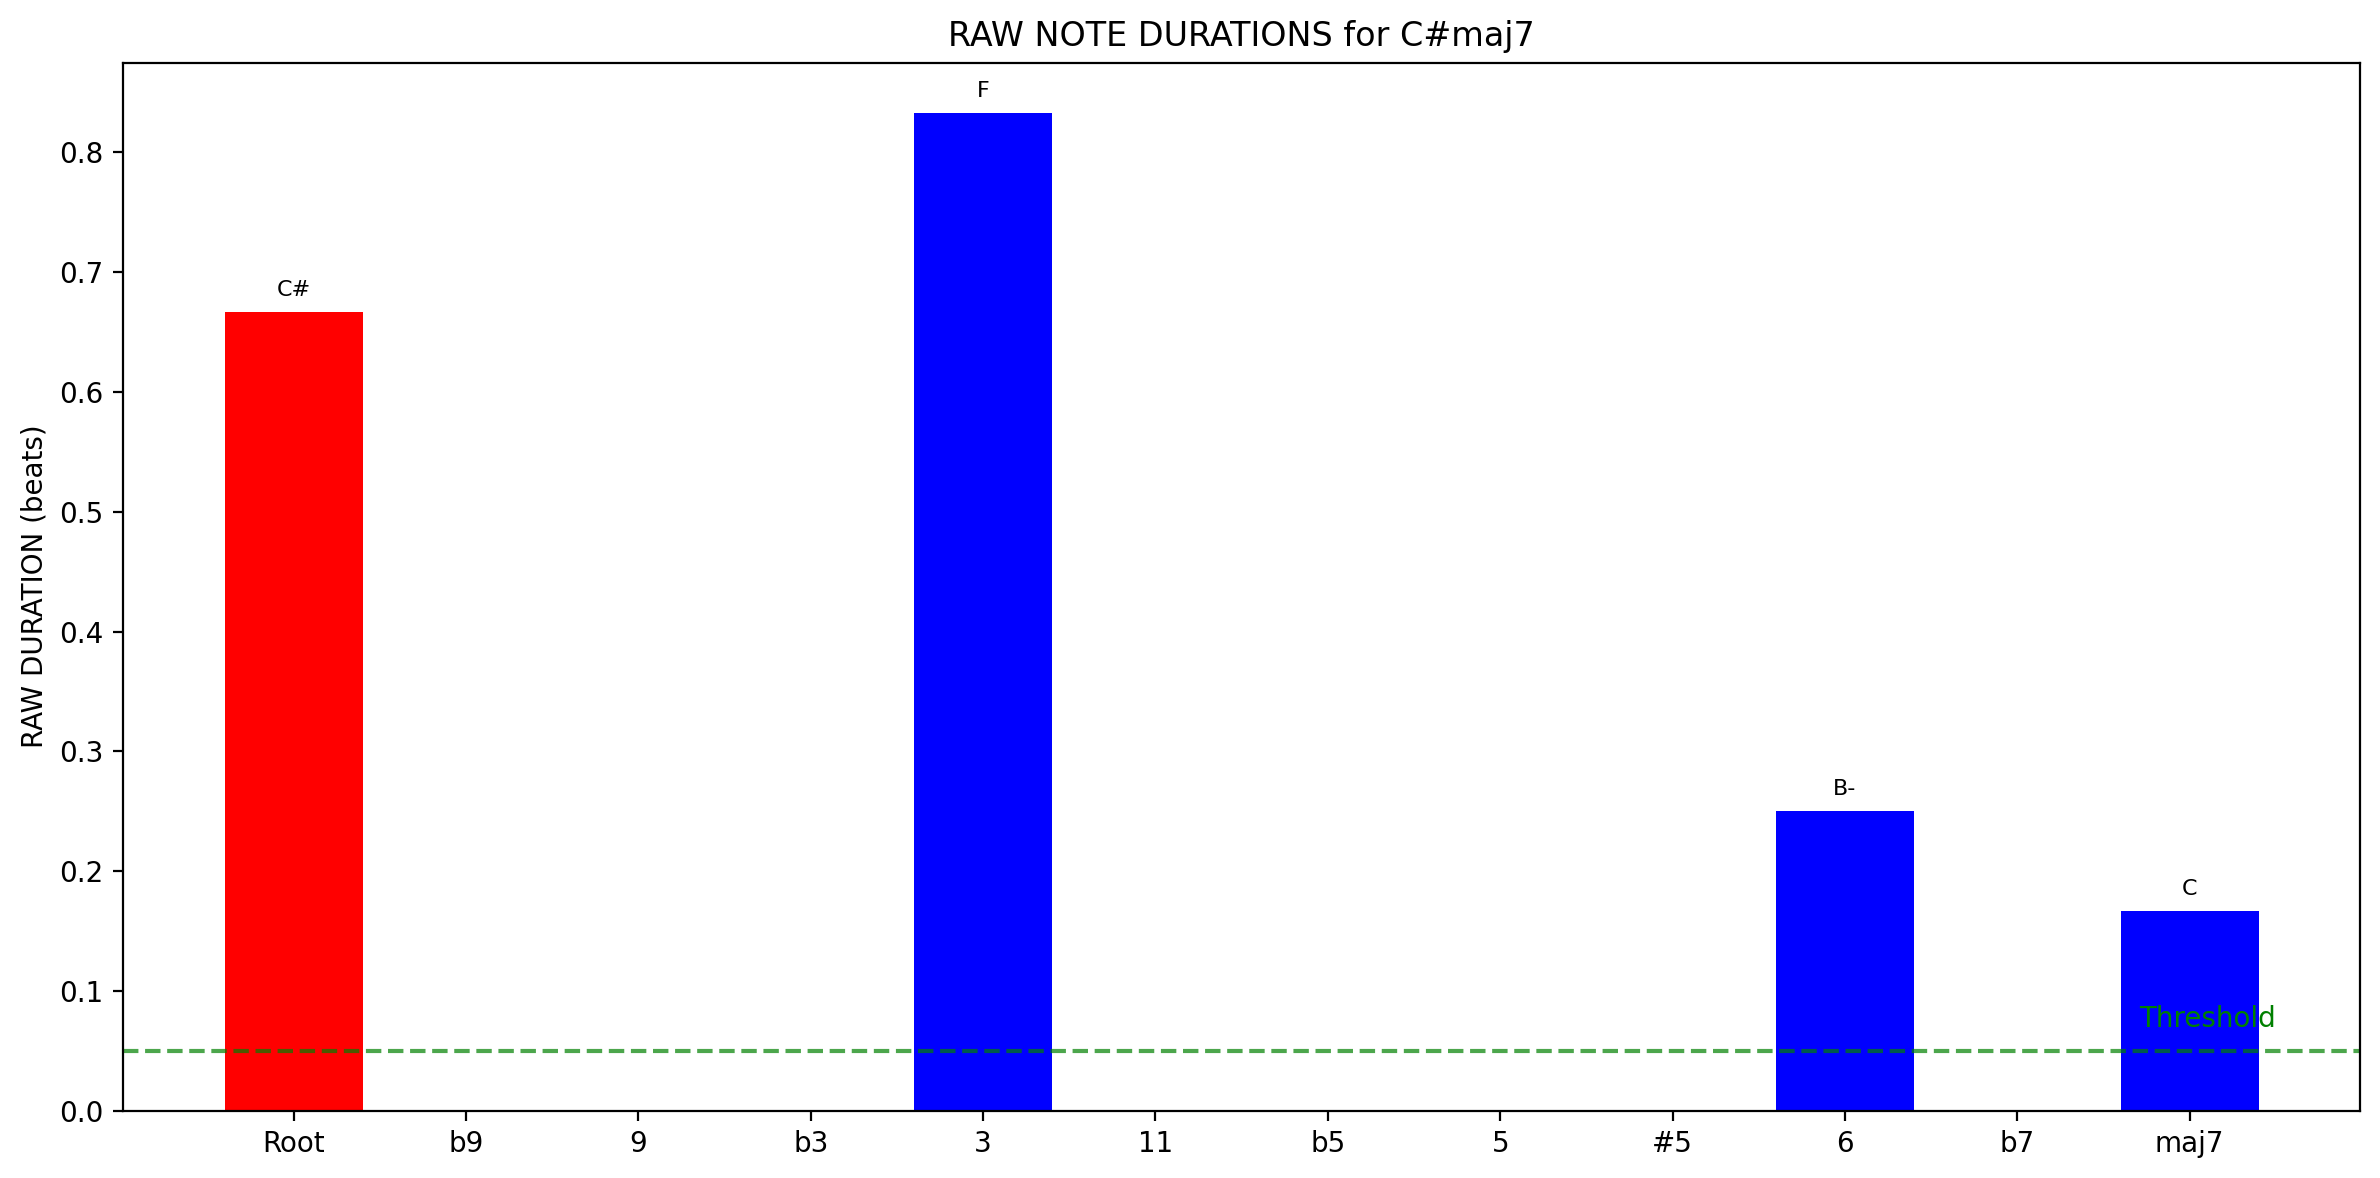


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
4        3      0.833      F
0        Root   0.667      C#
9        6      0.250      B-
11       maj7   0.167      C


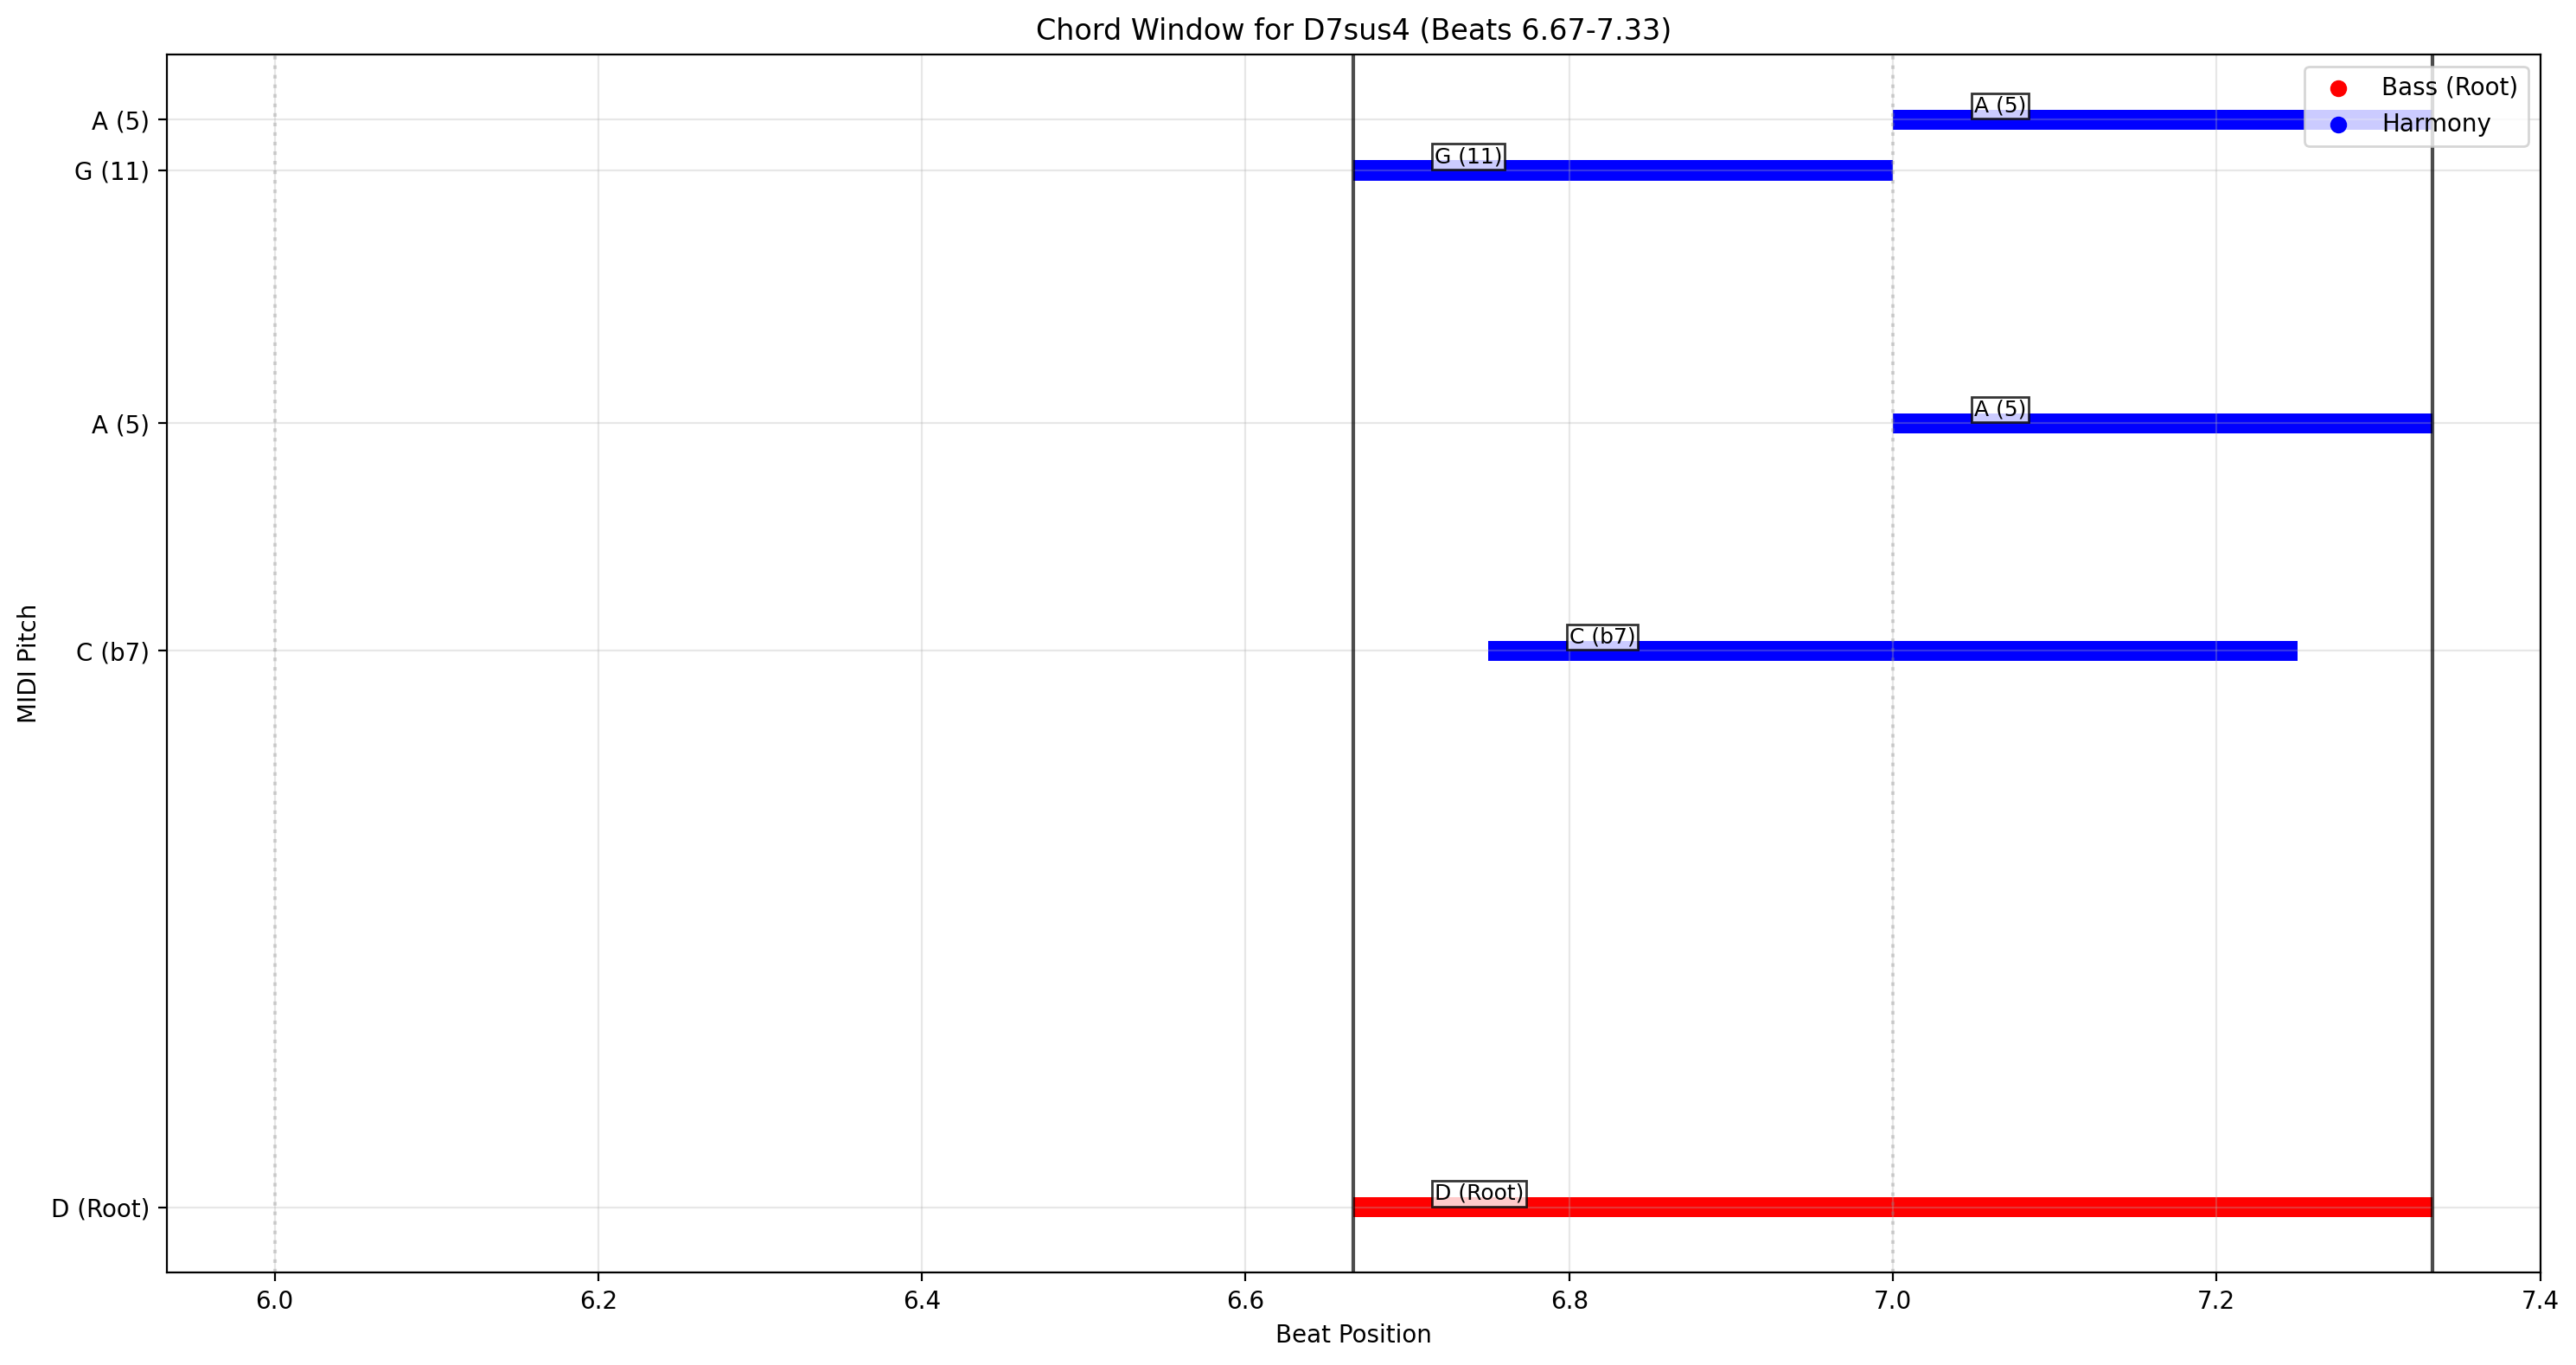


Bass note window 3: D (6.67-7.33)
  Active harmony notes: ['G', 'C', 'A', 'A']
  Intervals: [0, 5, 7, 10]
  Identified chord: D7sus4


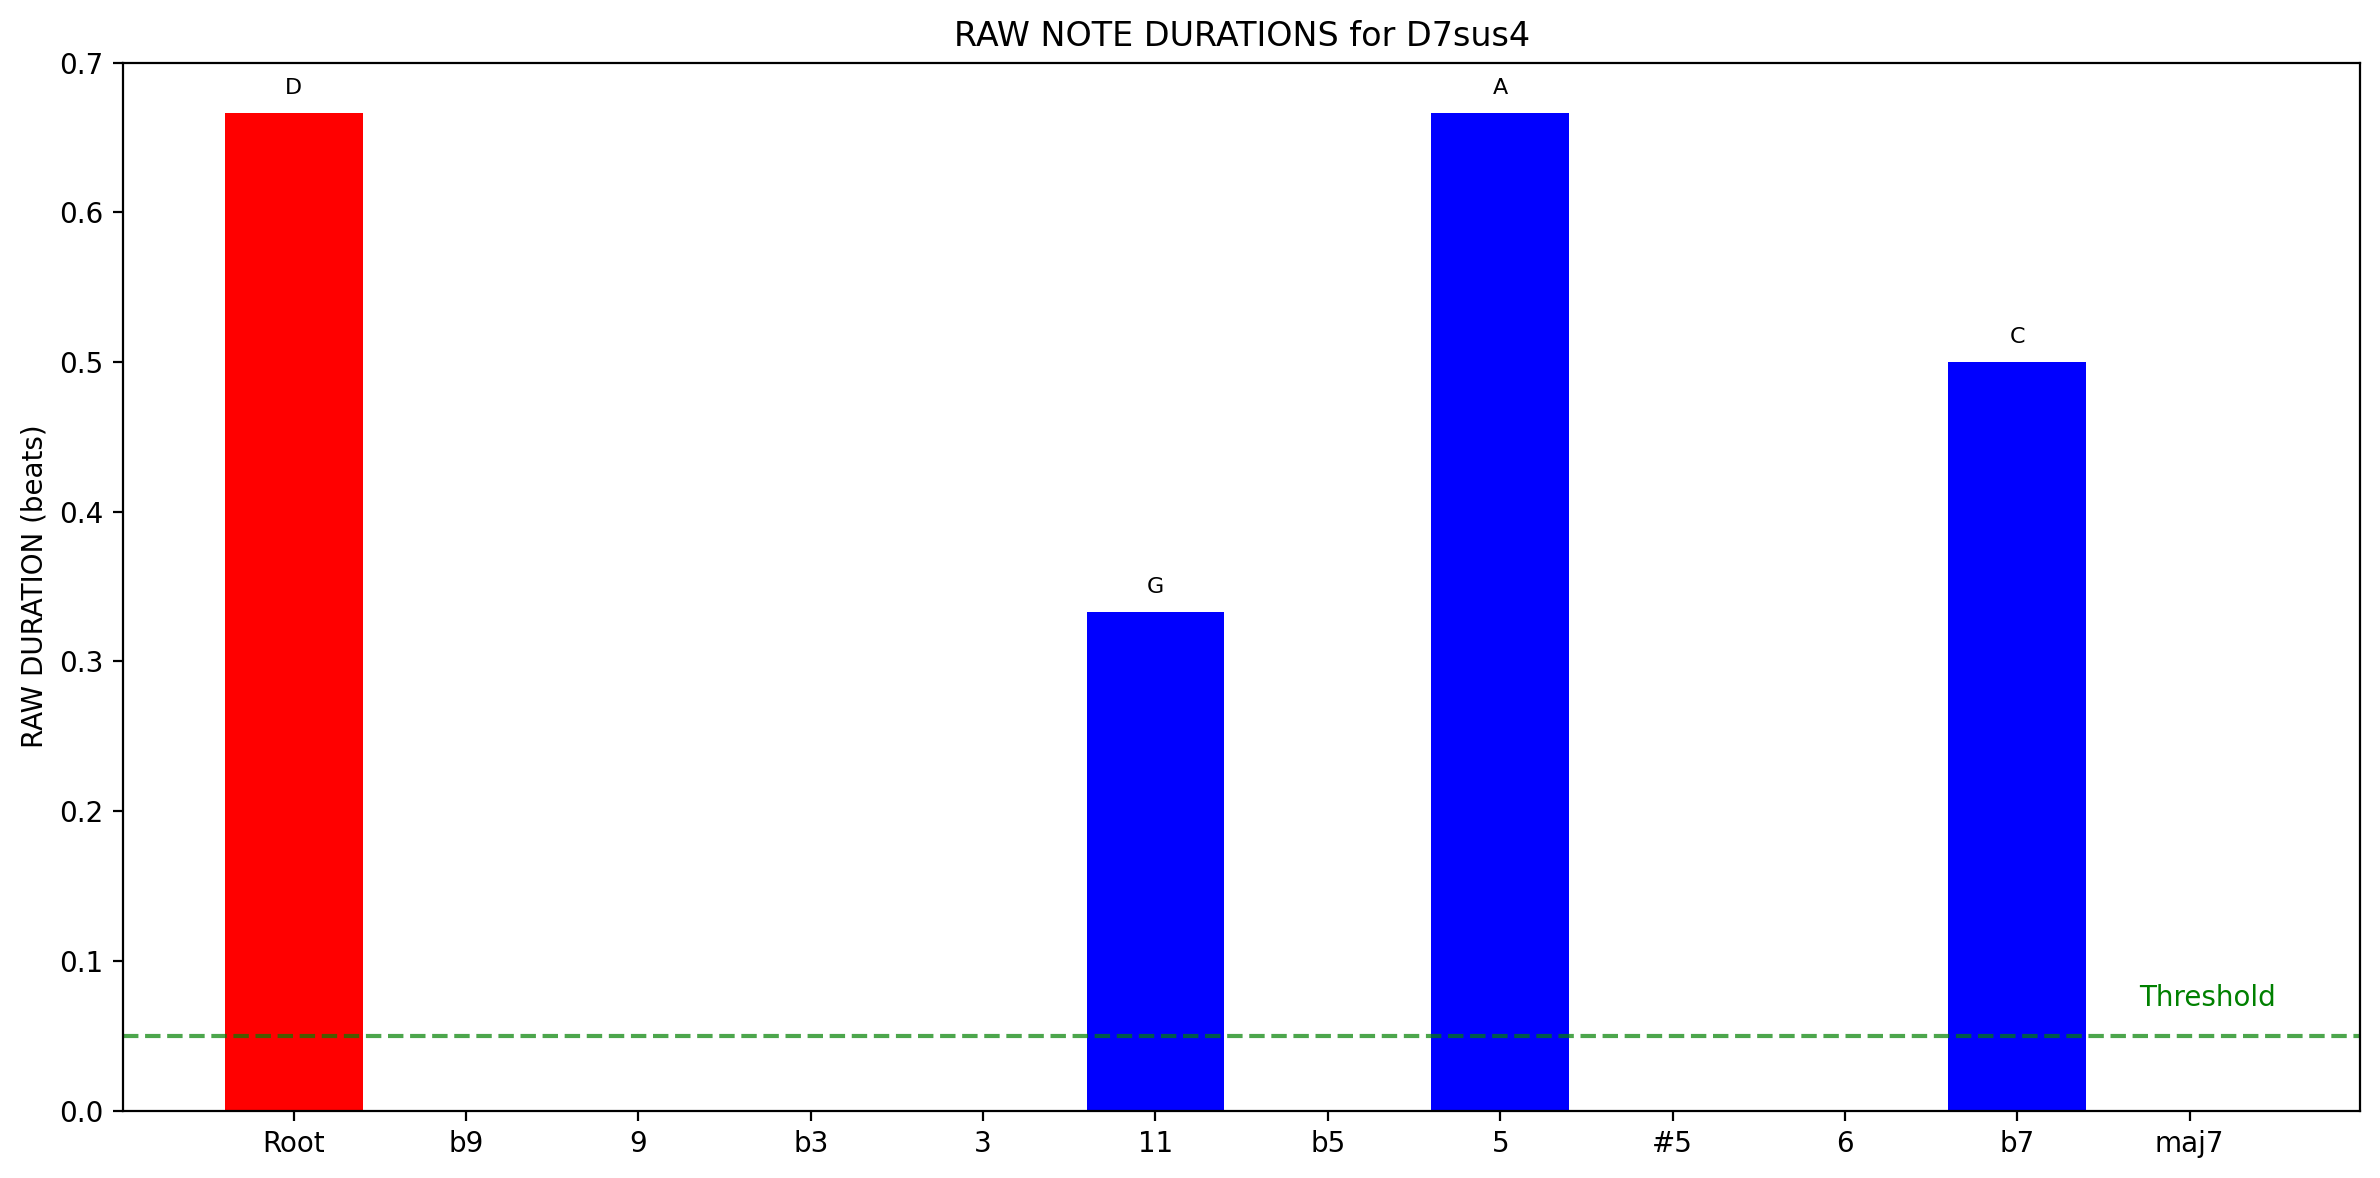


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.667      D
7        5      0.667      A
10       b7     0.500      C
5        11     0.333      G


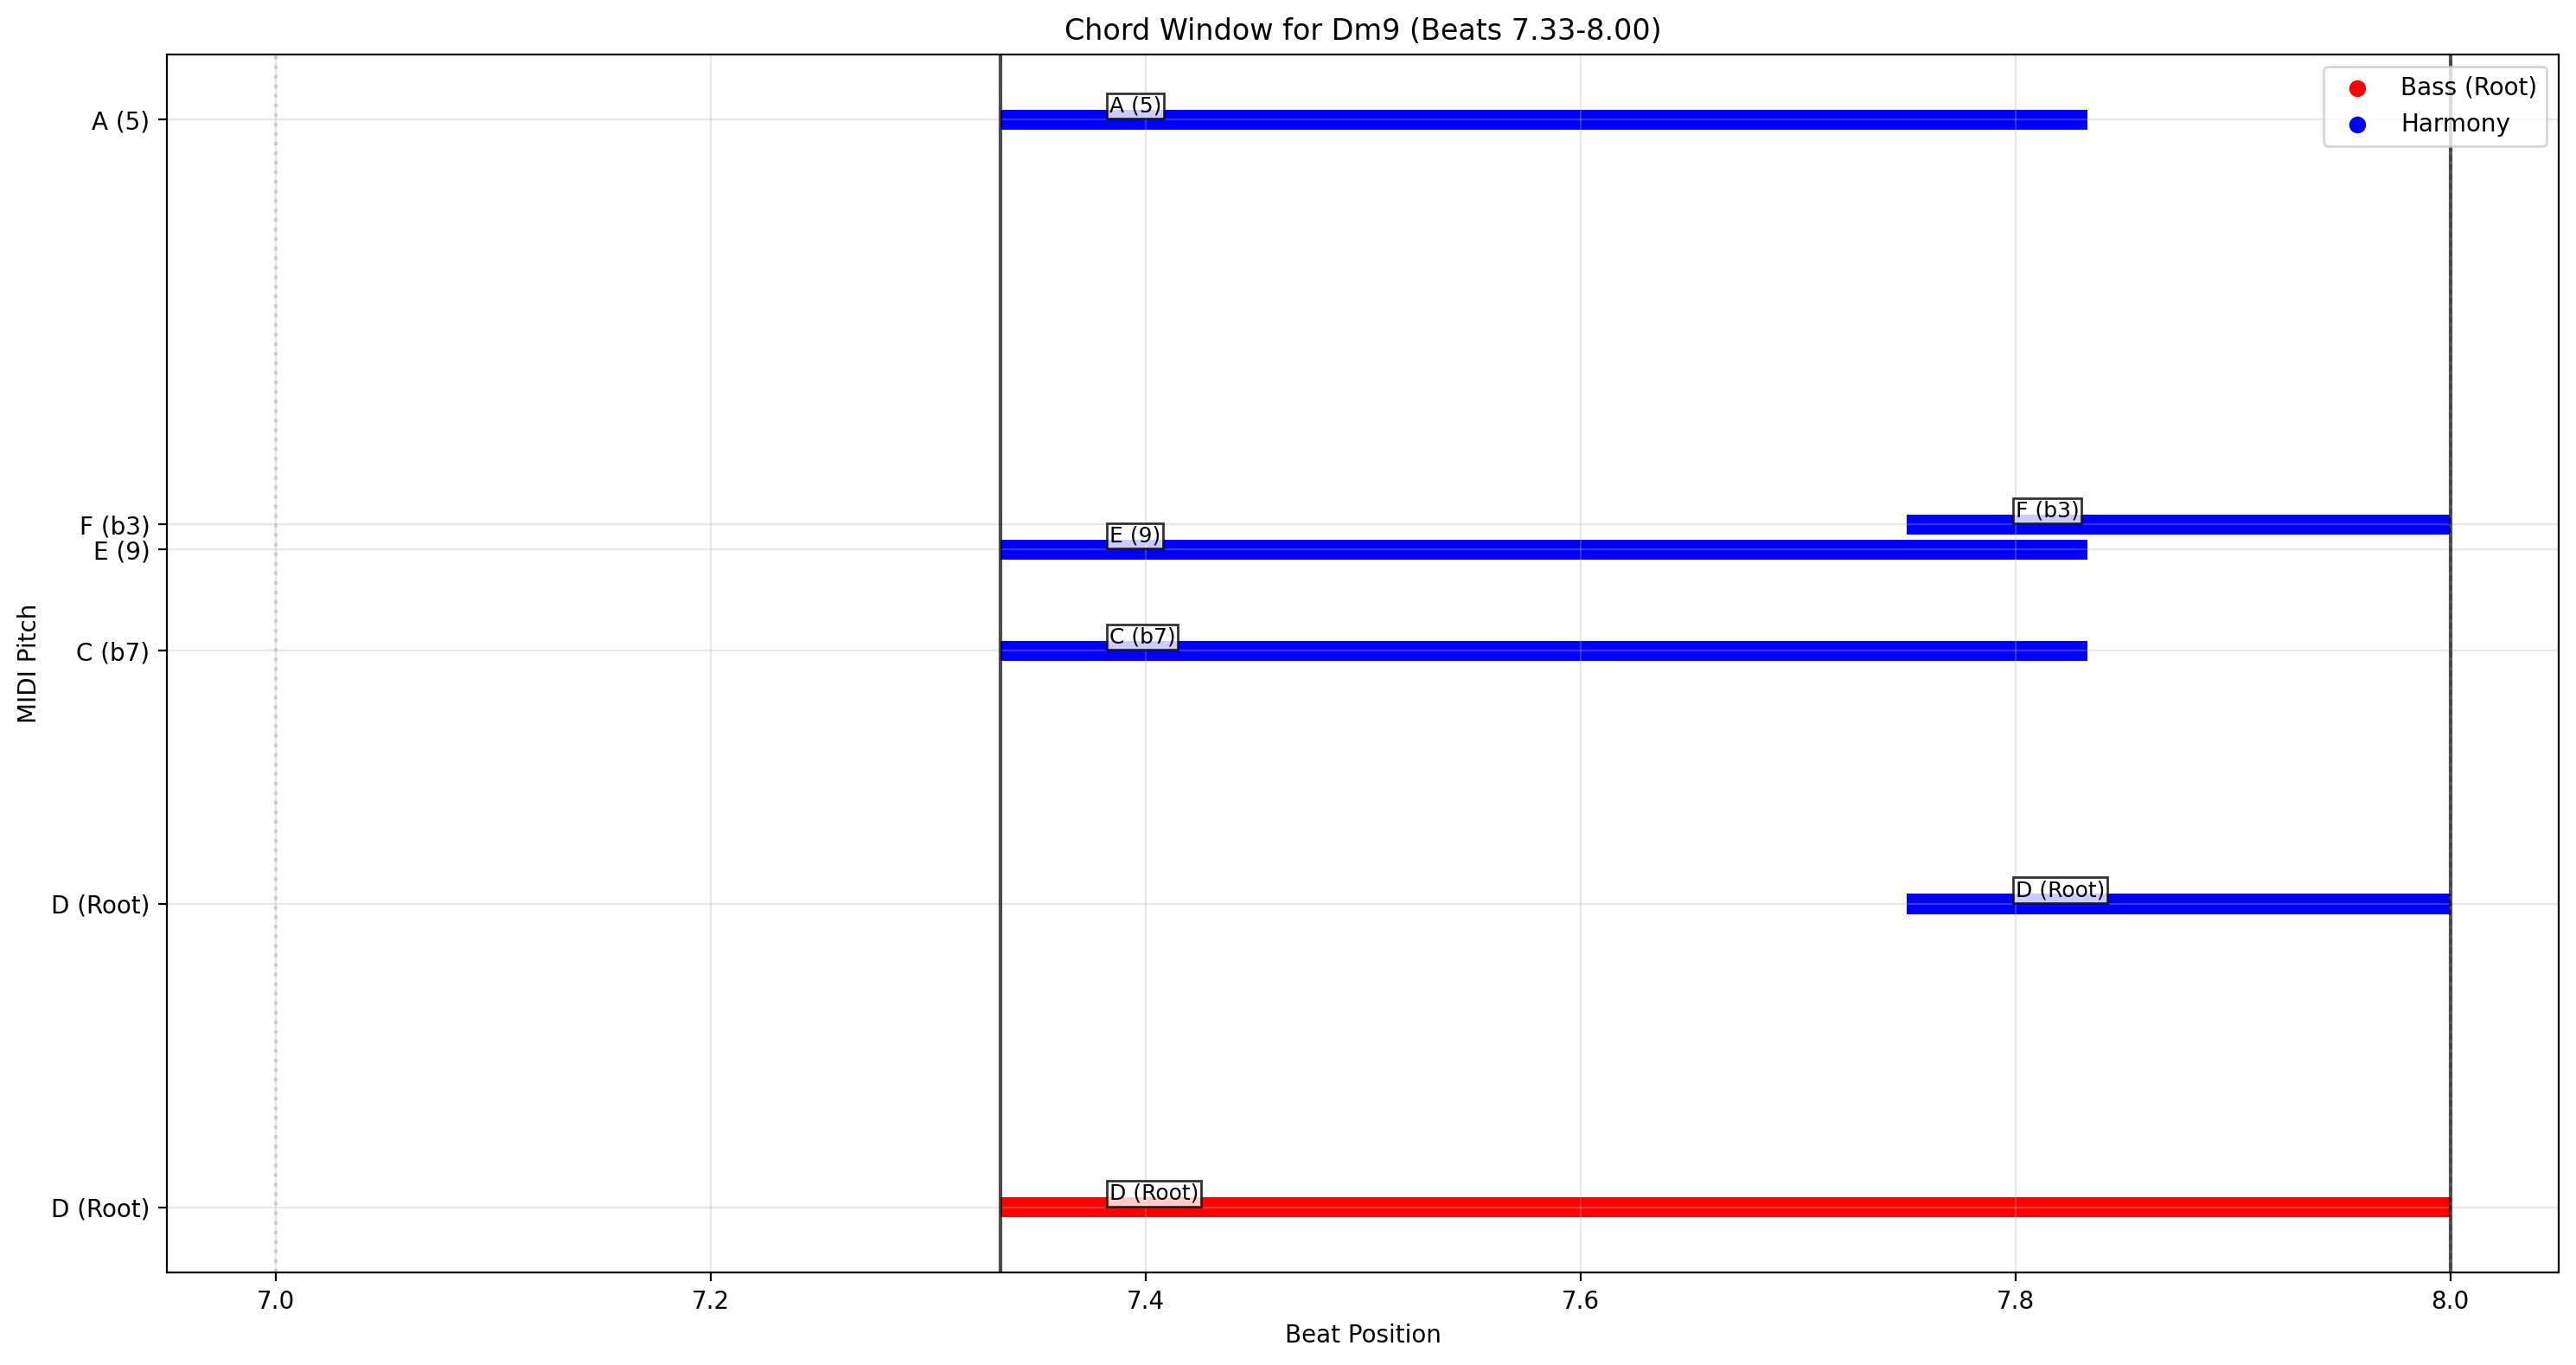


Bass note window 4: D (7.33-8.00)
  Active harmony notes: ['E', 'A', 'C', 'D', 'F']
  Intervals: [0, 2, 3, 7, 10]
  Identified chord: Dm9


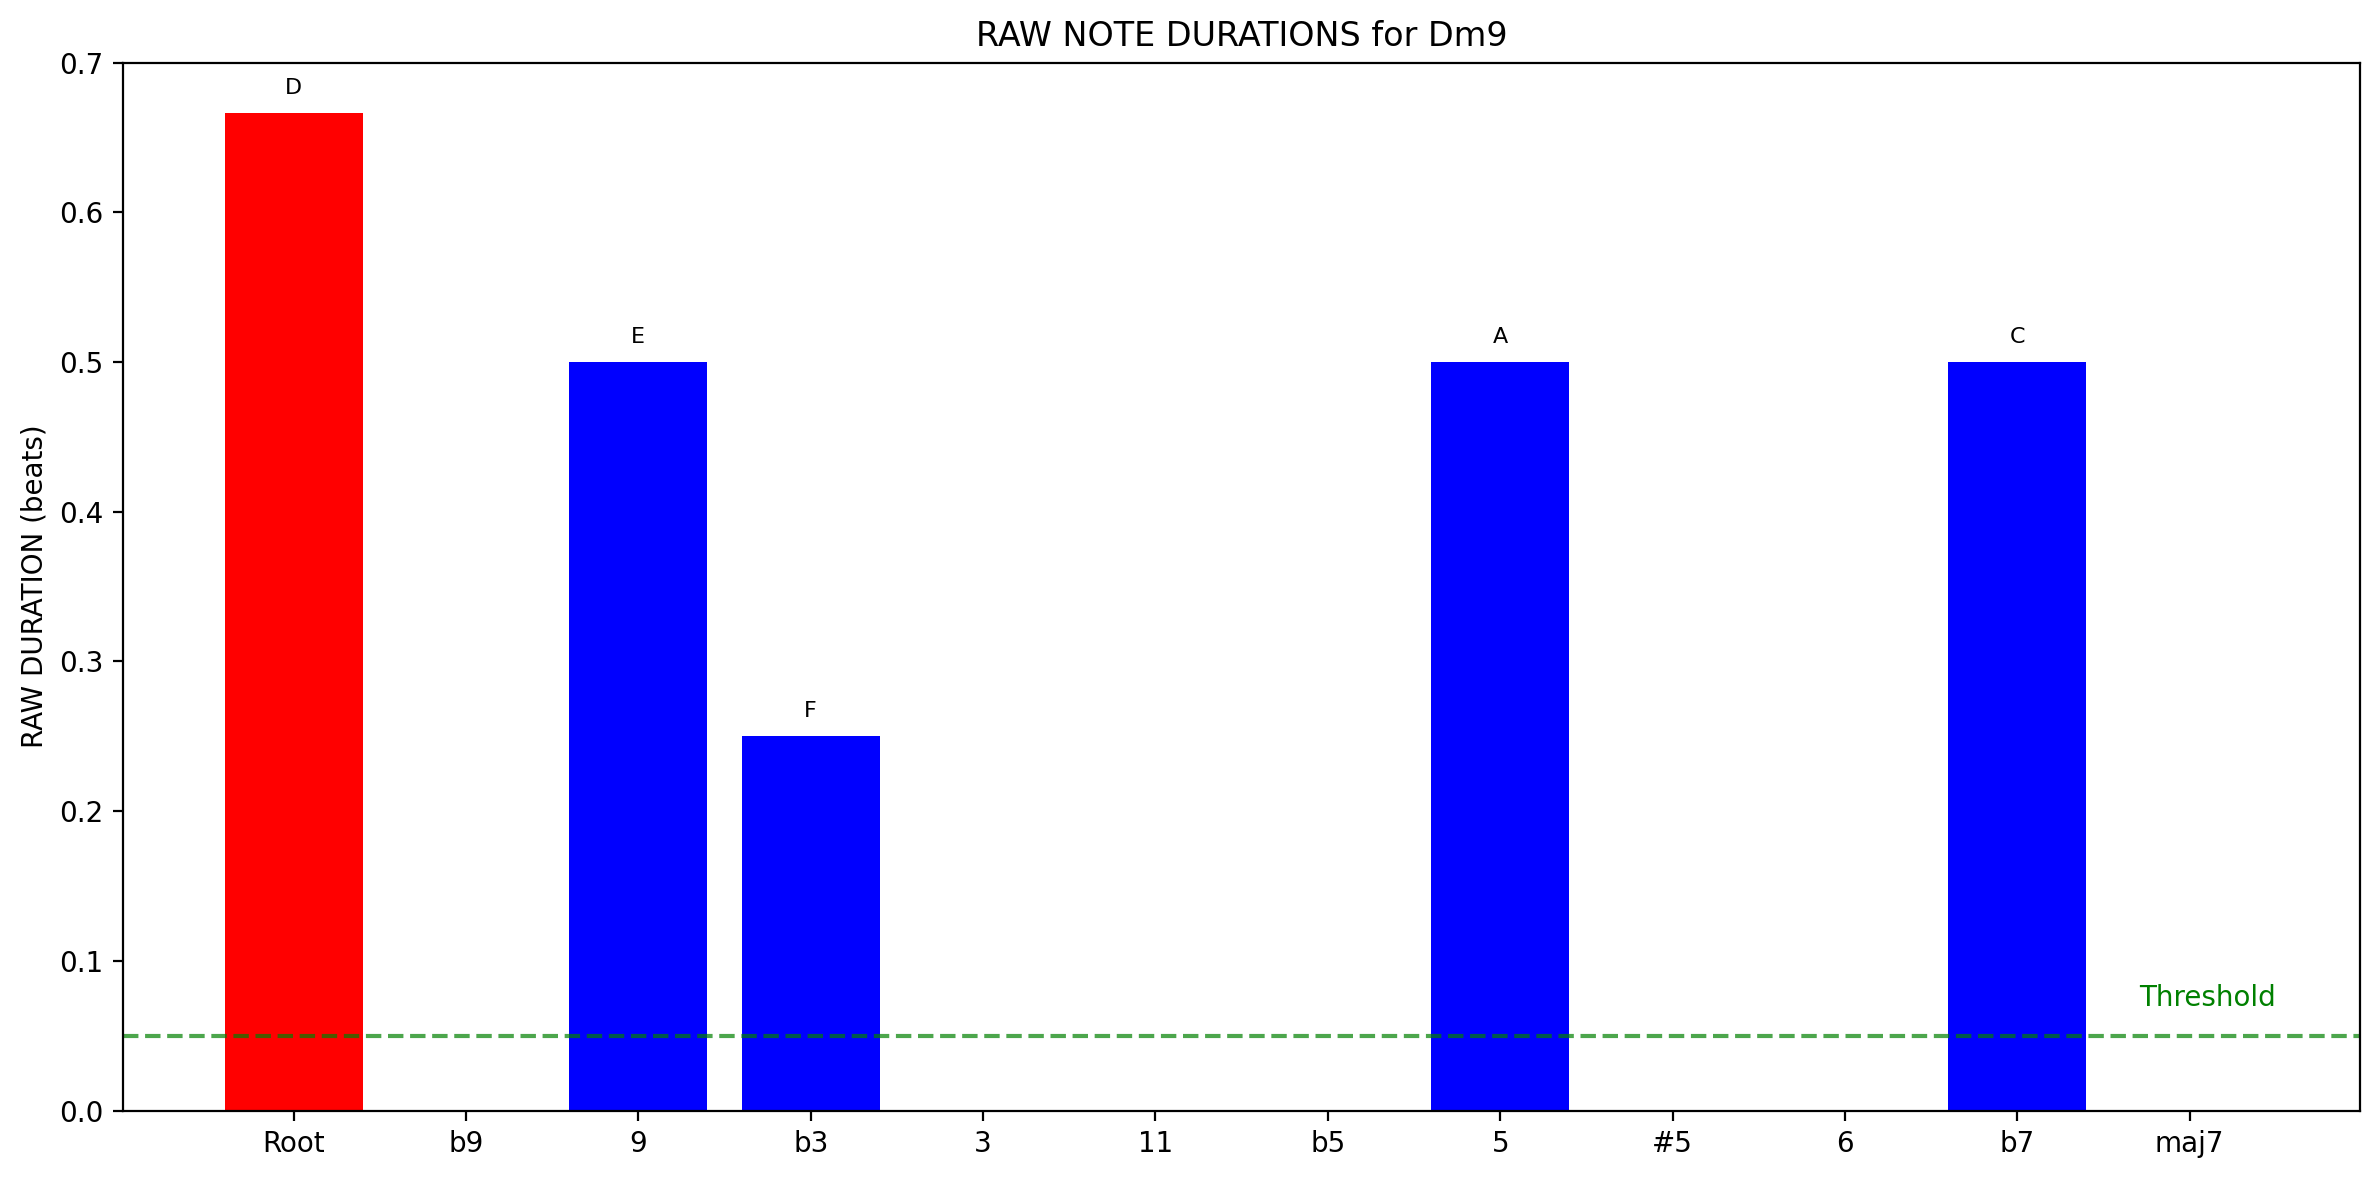


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.667      D
2        9      0.500      E
7        5      0.500      A
10       b7     0.500      C
3        b3     0.250      F

=== Analyzing Bar 3 with Time Windows ===

Bass notes in bar 3:
  G# (PC 8): 8.75-9.25
  G# (PC 8): 9.25-9.75
  G (PC 7): 10.75-11.42
  G (PC 7): 11.33-12.00


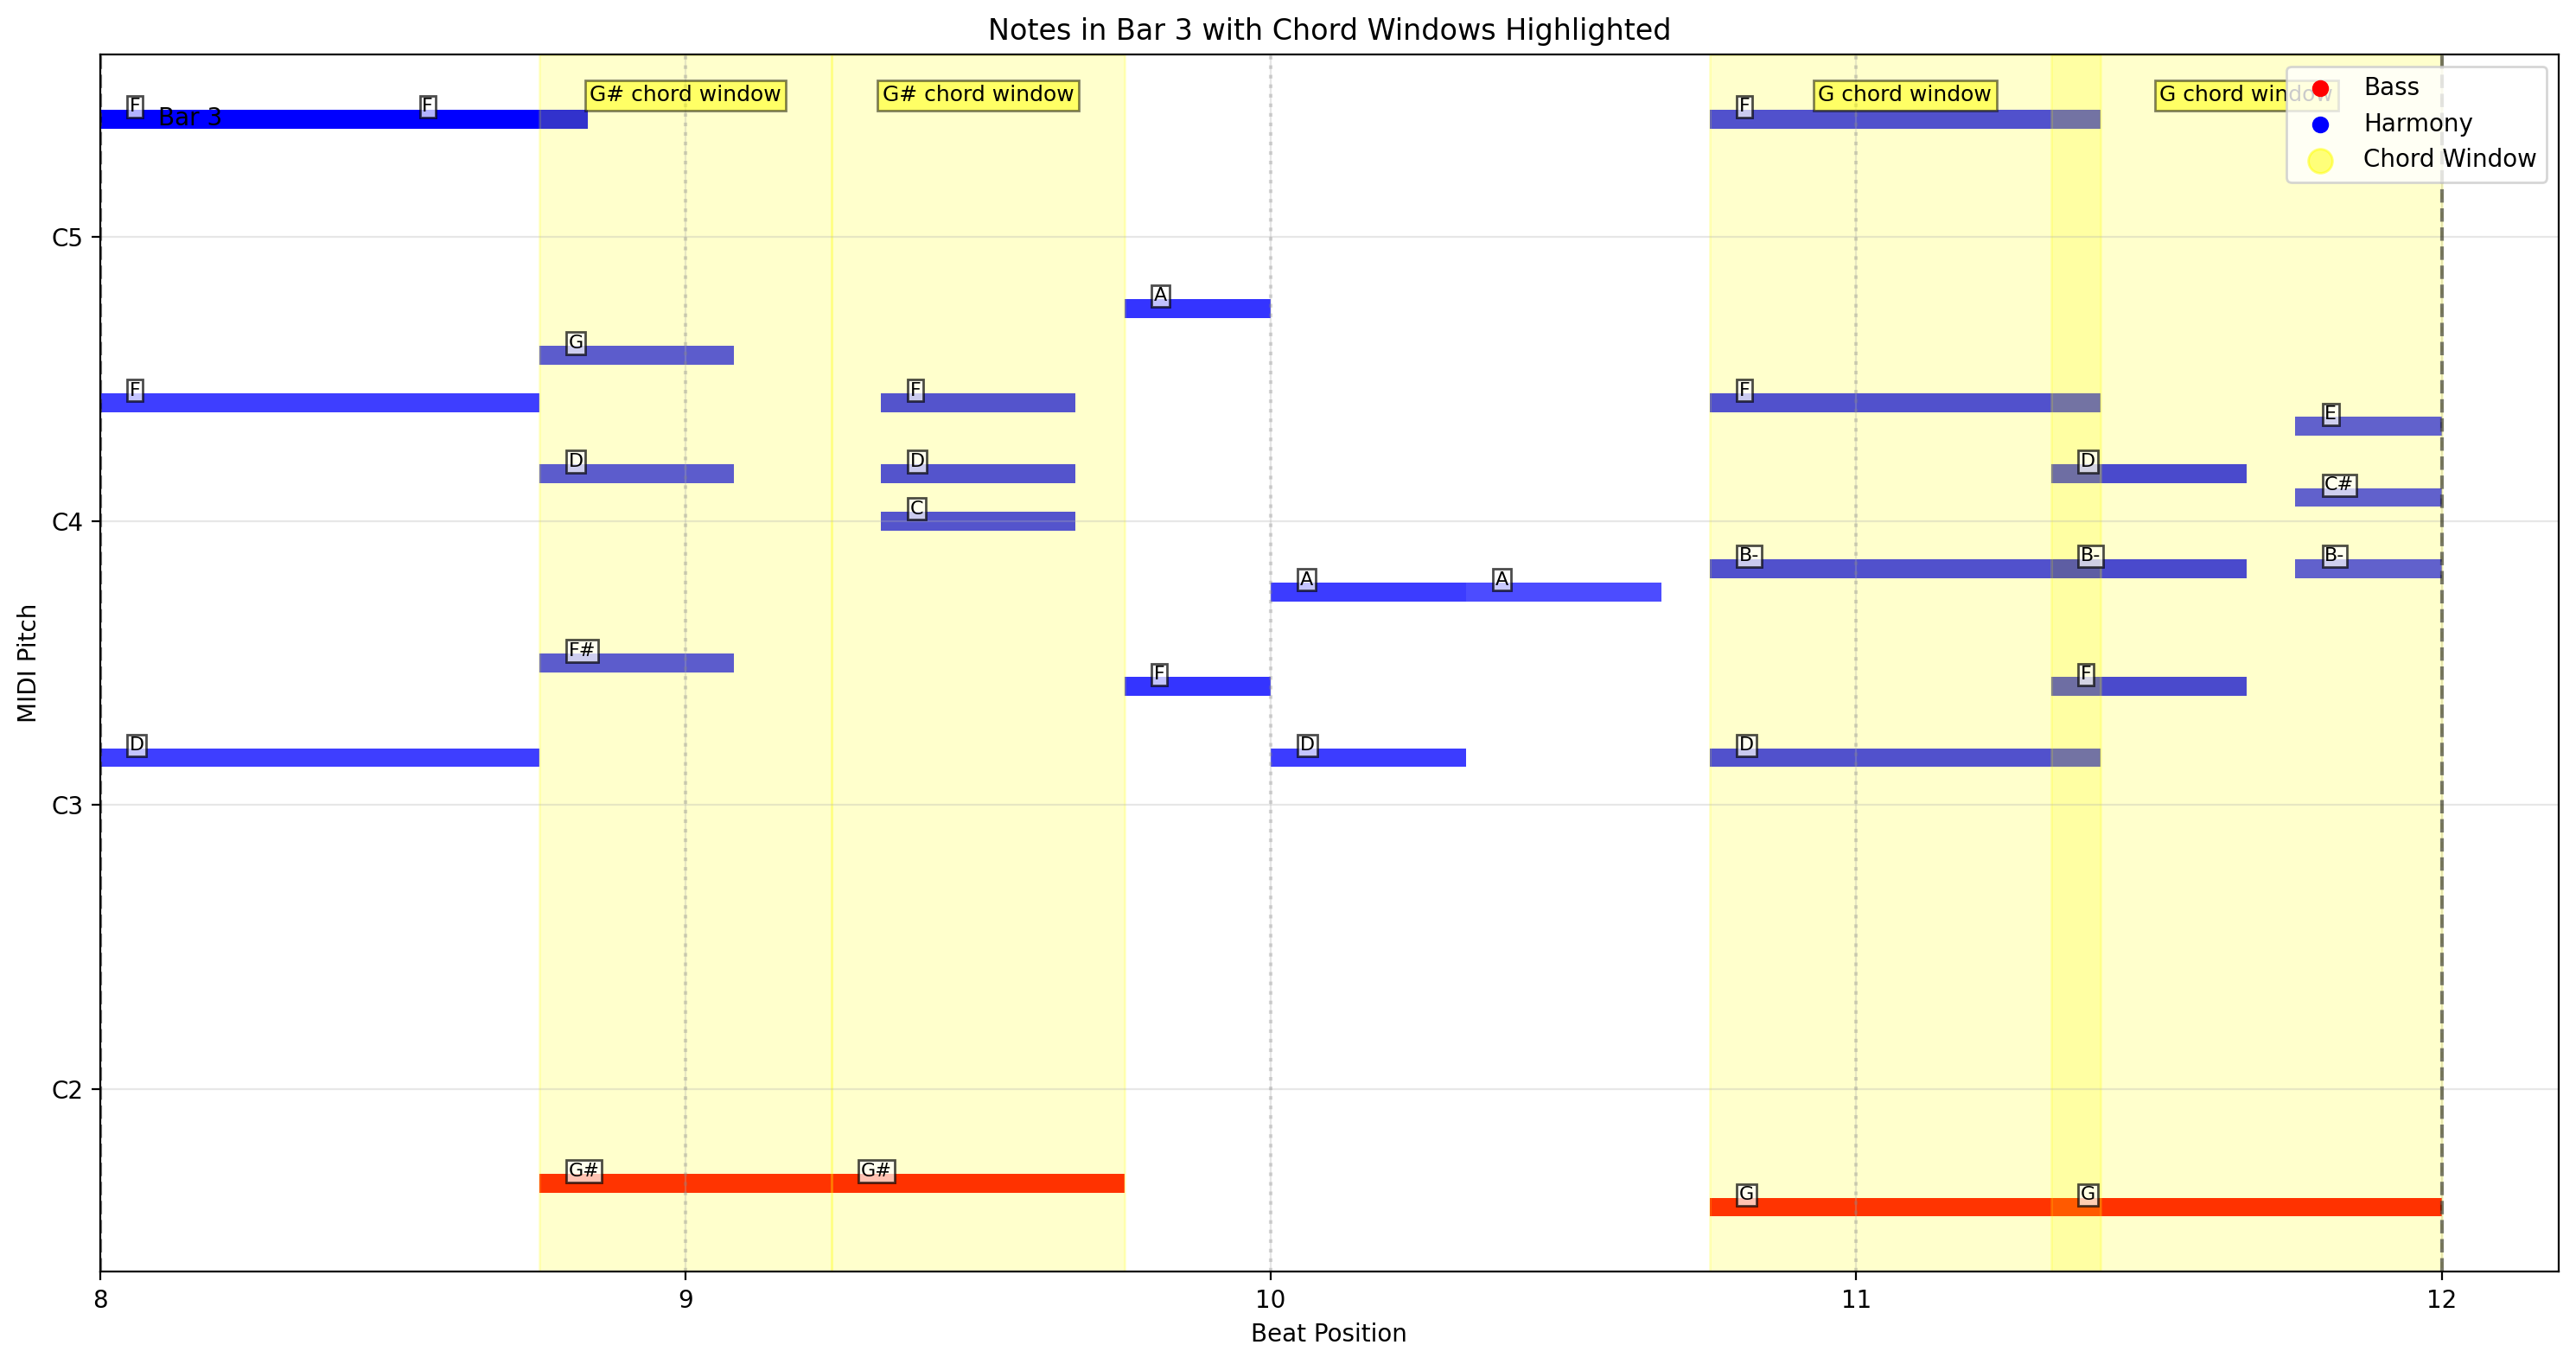

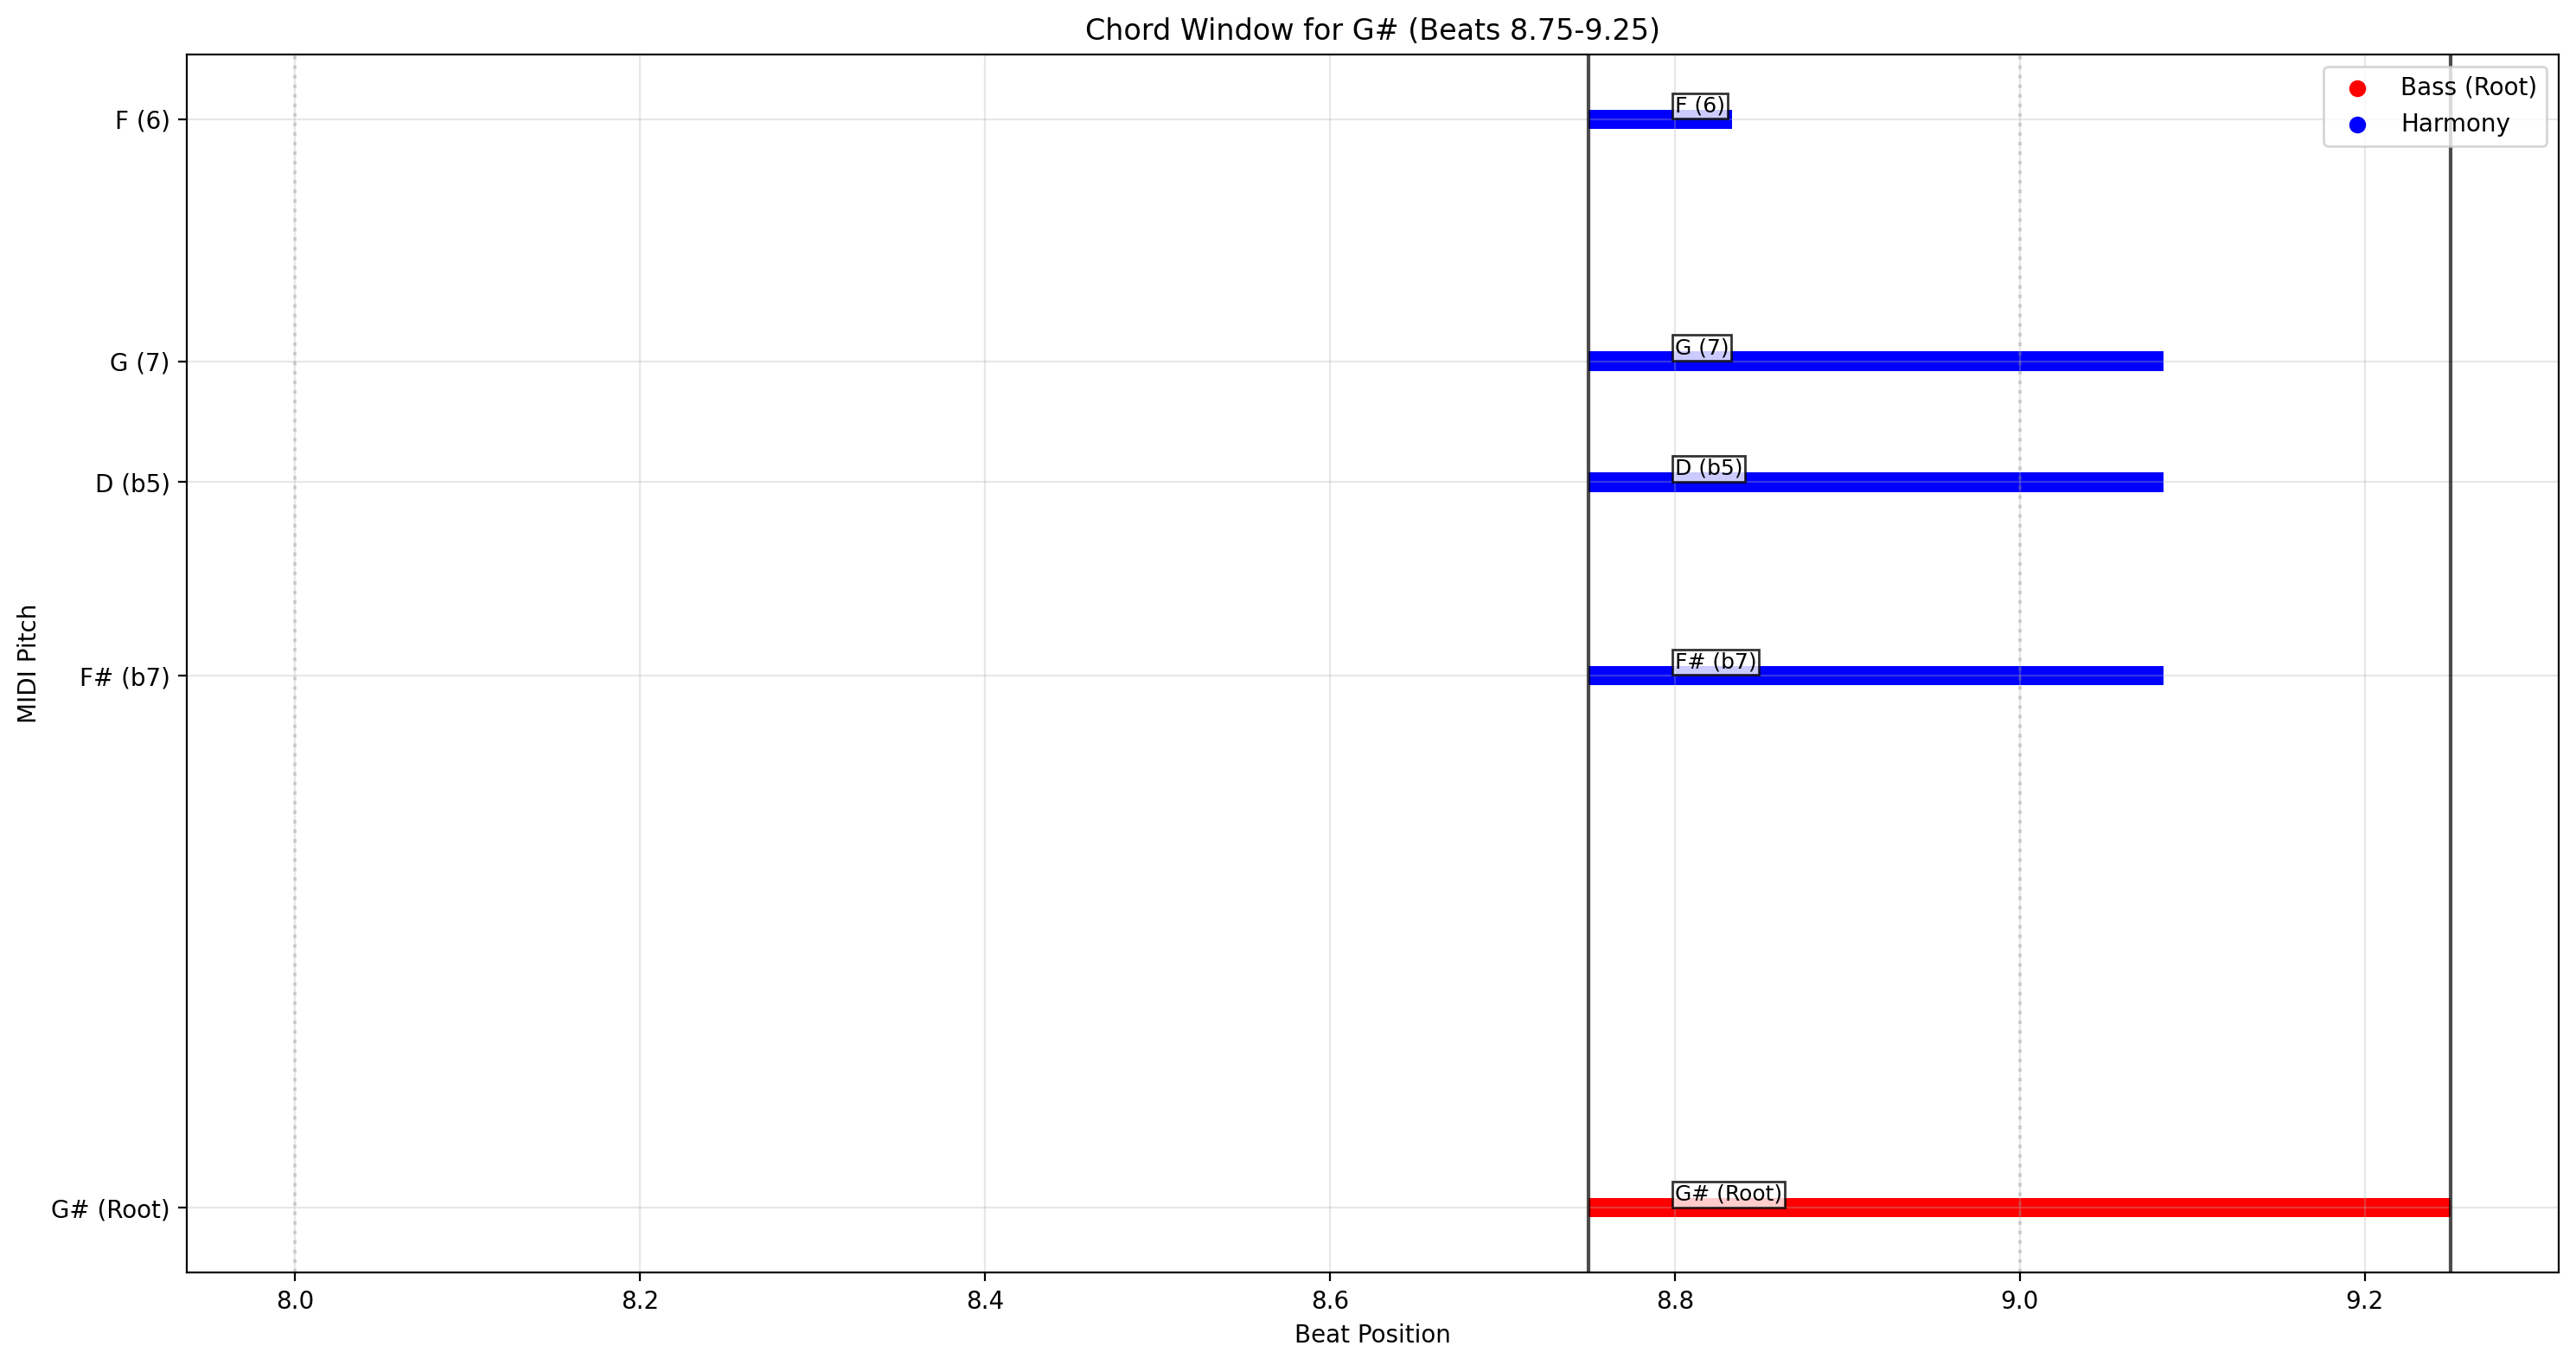


Bass note window 1: G# (8.75-9.25)
  Active harmony notes: ['F', 'F#', 'D', 'G']
  Intervals: [0, 6, 9, 10, 11]
  Identified chord: G#


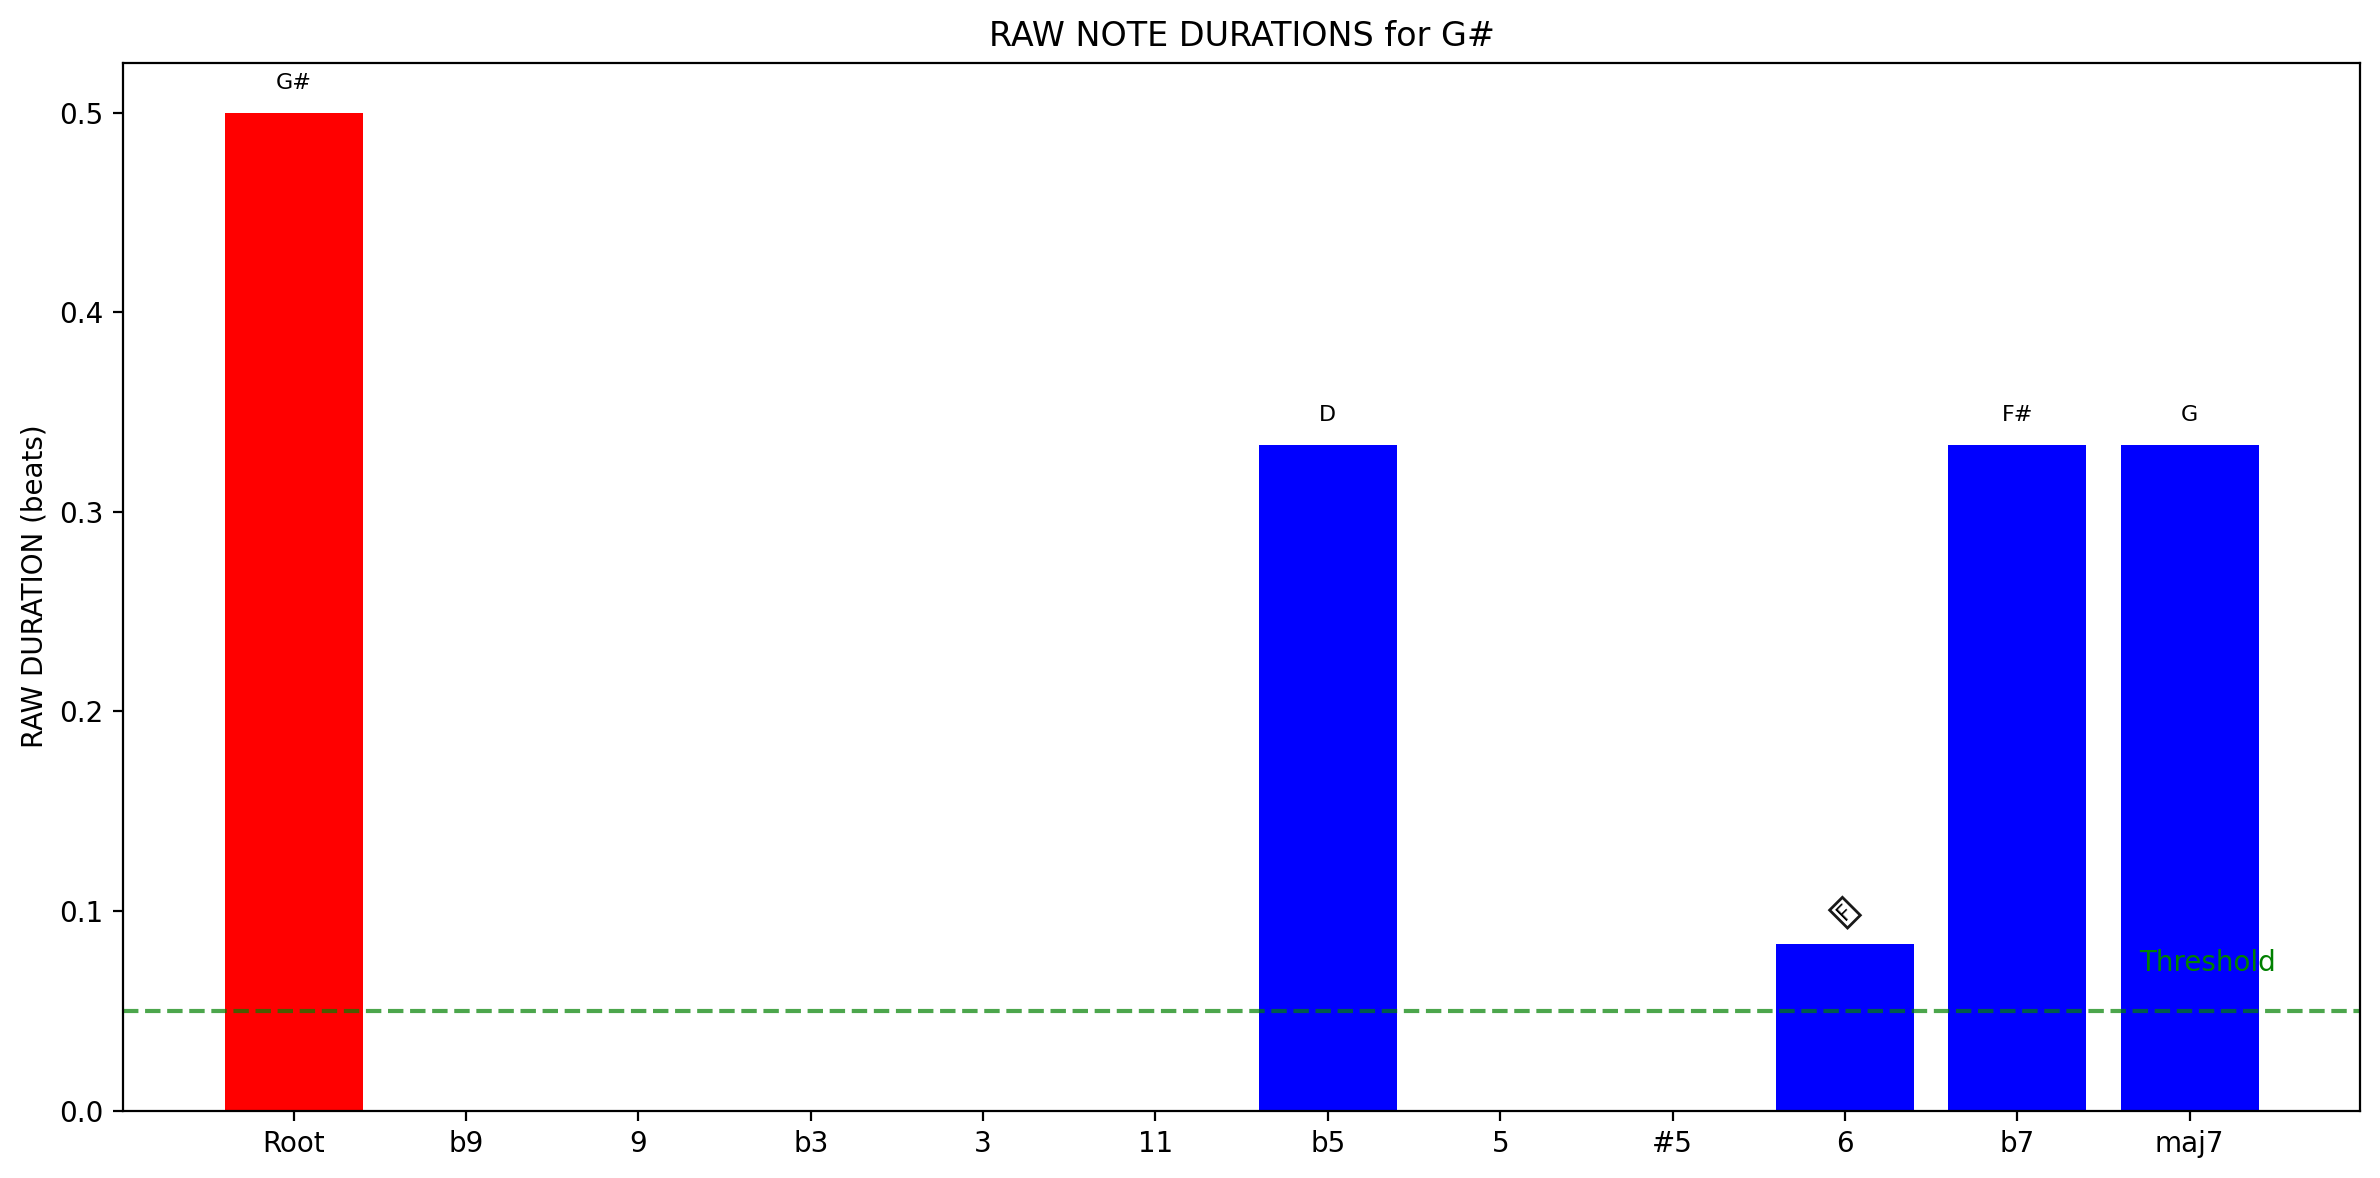


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.500      G#
6        b5     0.333      D
10       b7     0.333      F#
11       maj7   0.333      G
9        6      0.083      F


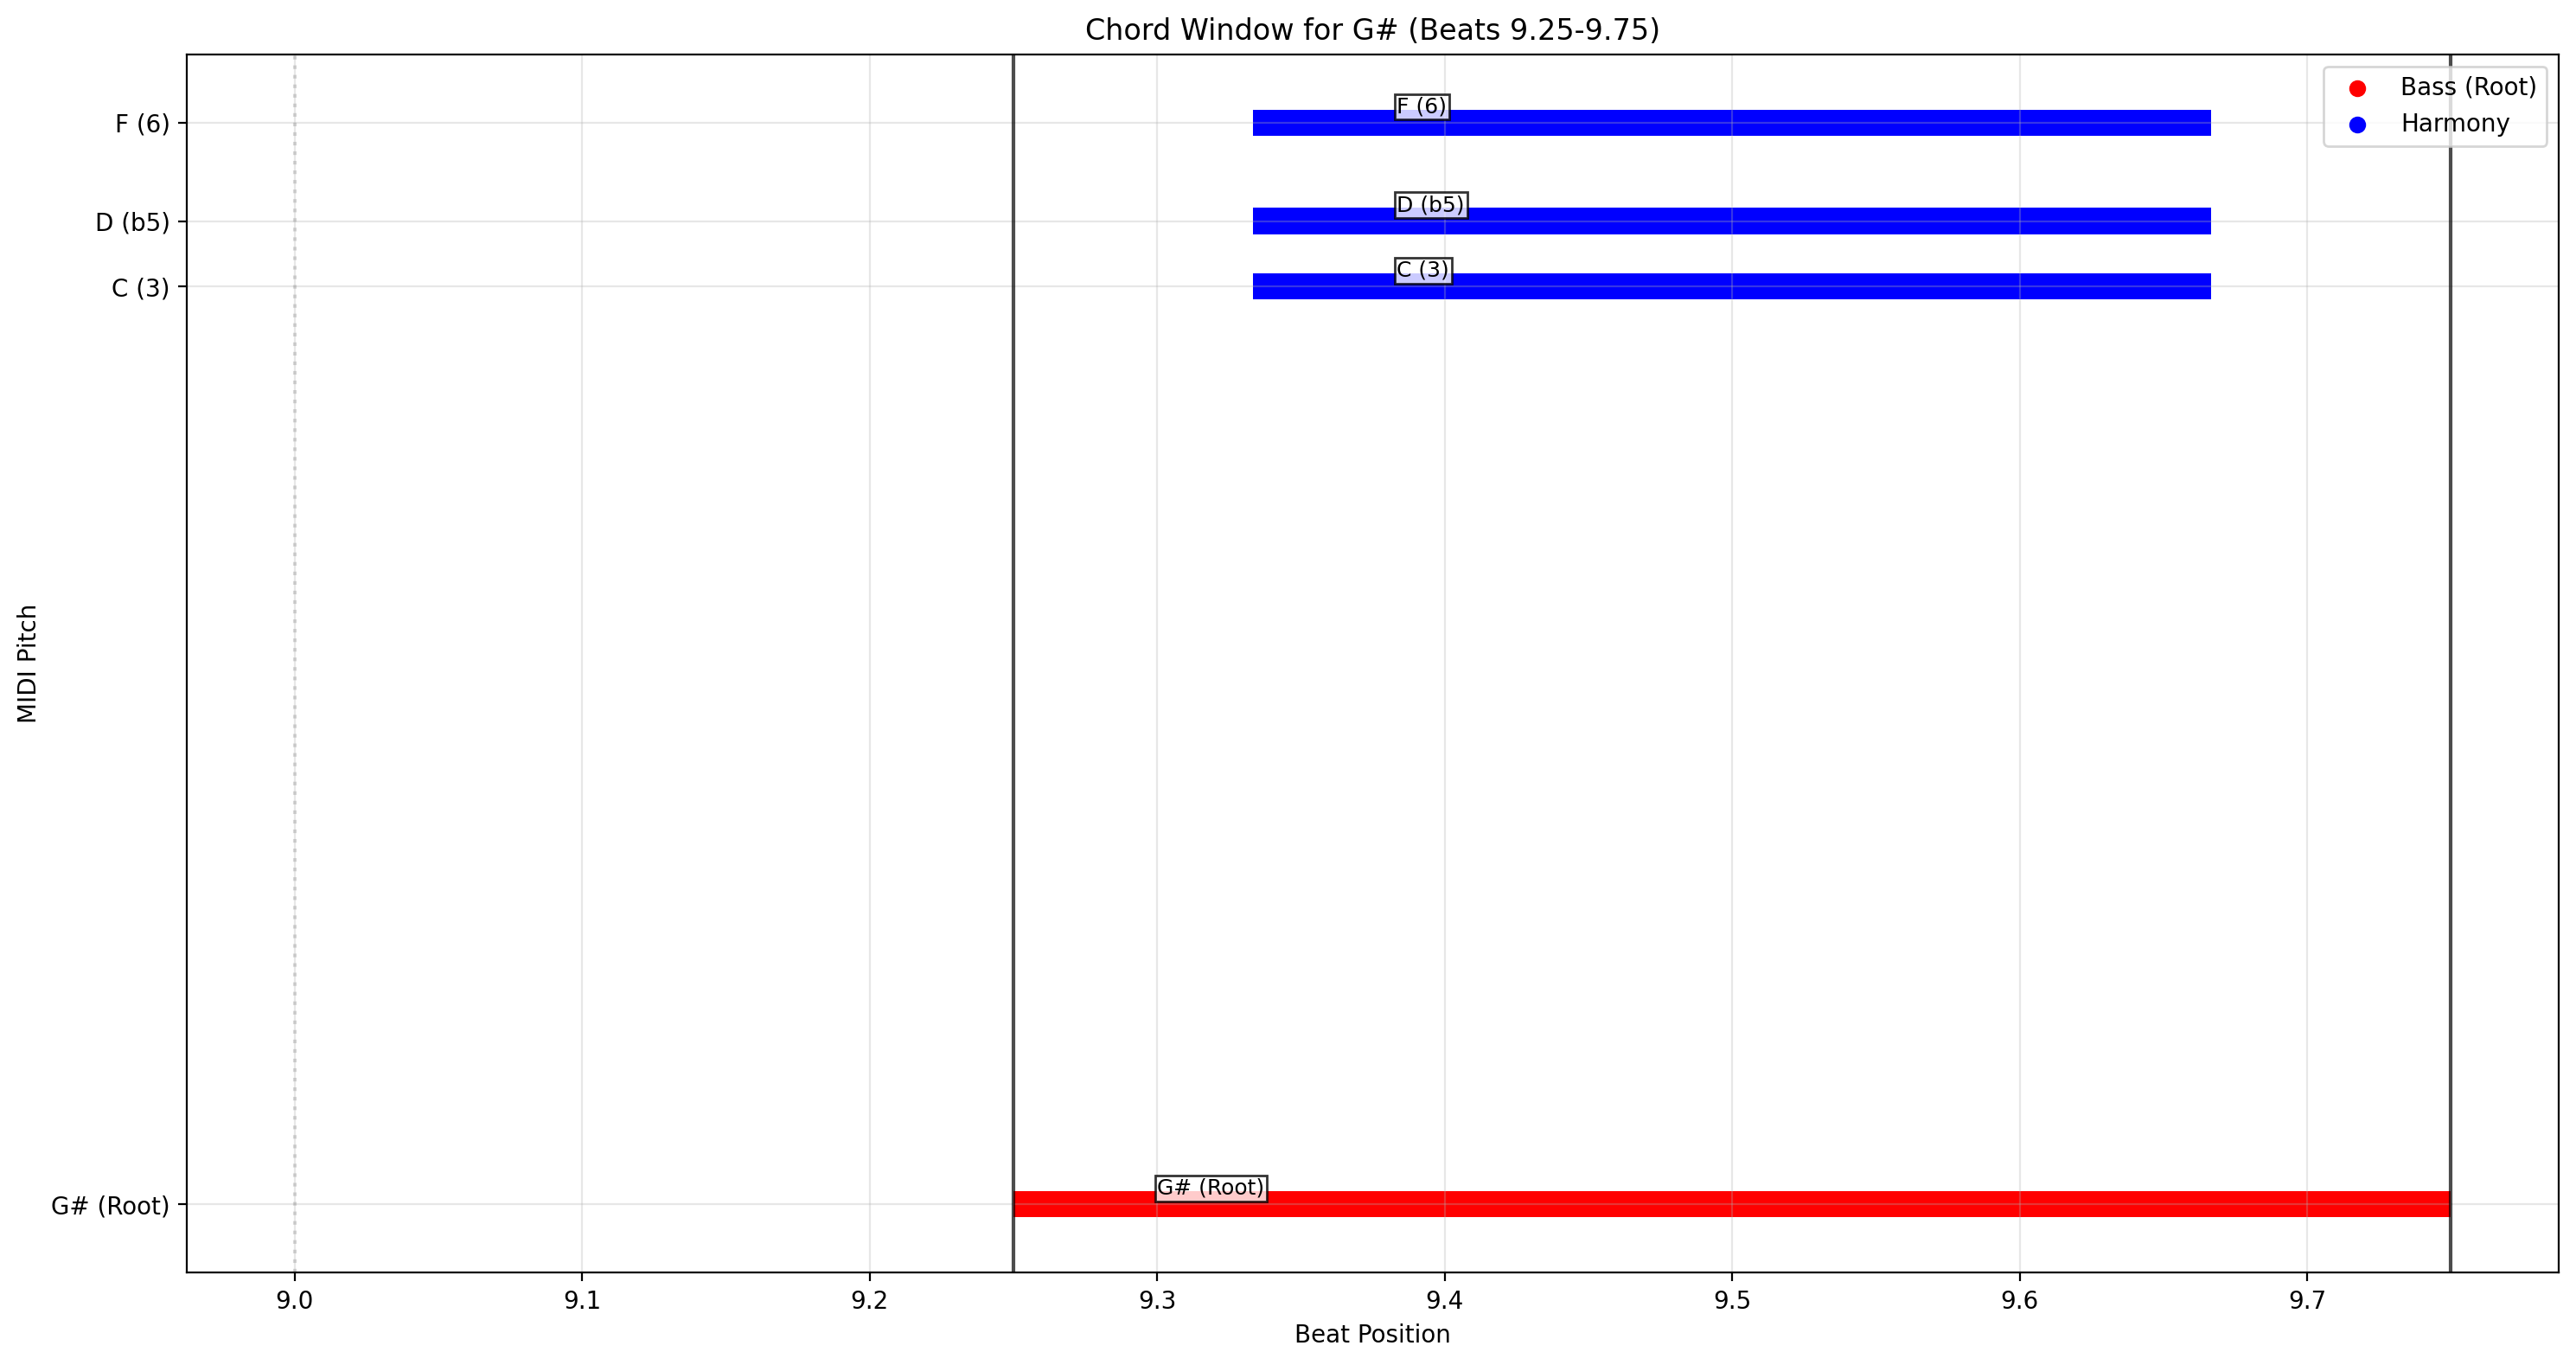


Bass note window 2: G# (9.25-9.75)
  Active harmony notes: ['C', 'D', 'F']
  Intervals: [0, 4, 6, 9]
  Identified chord: G#


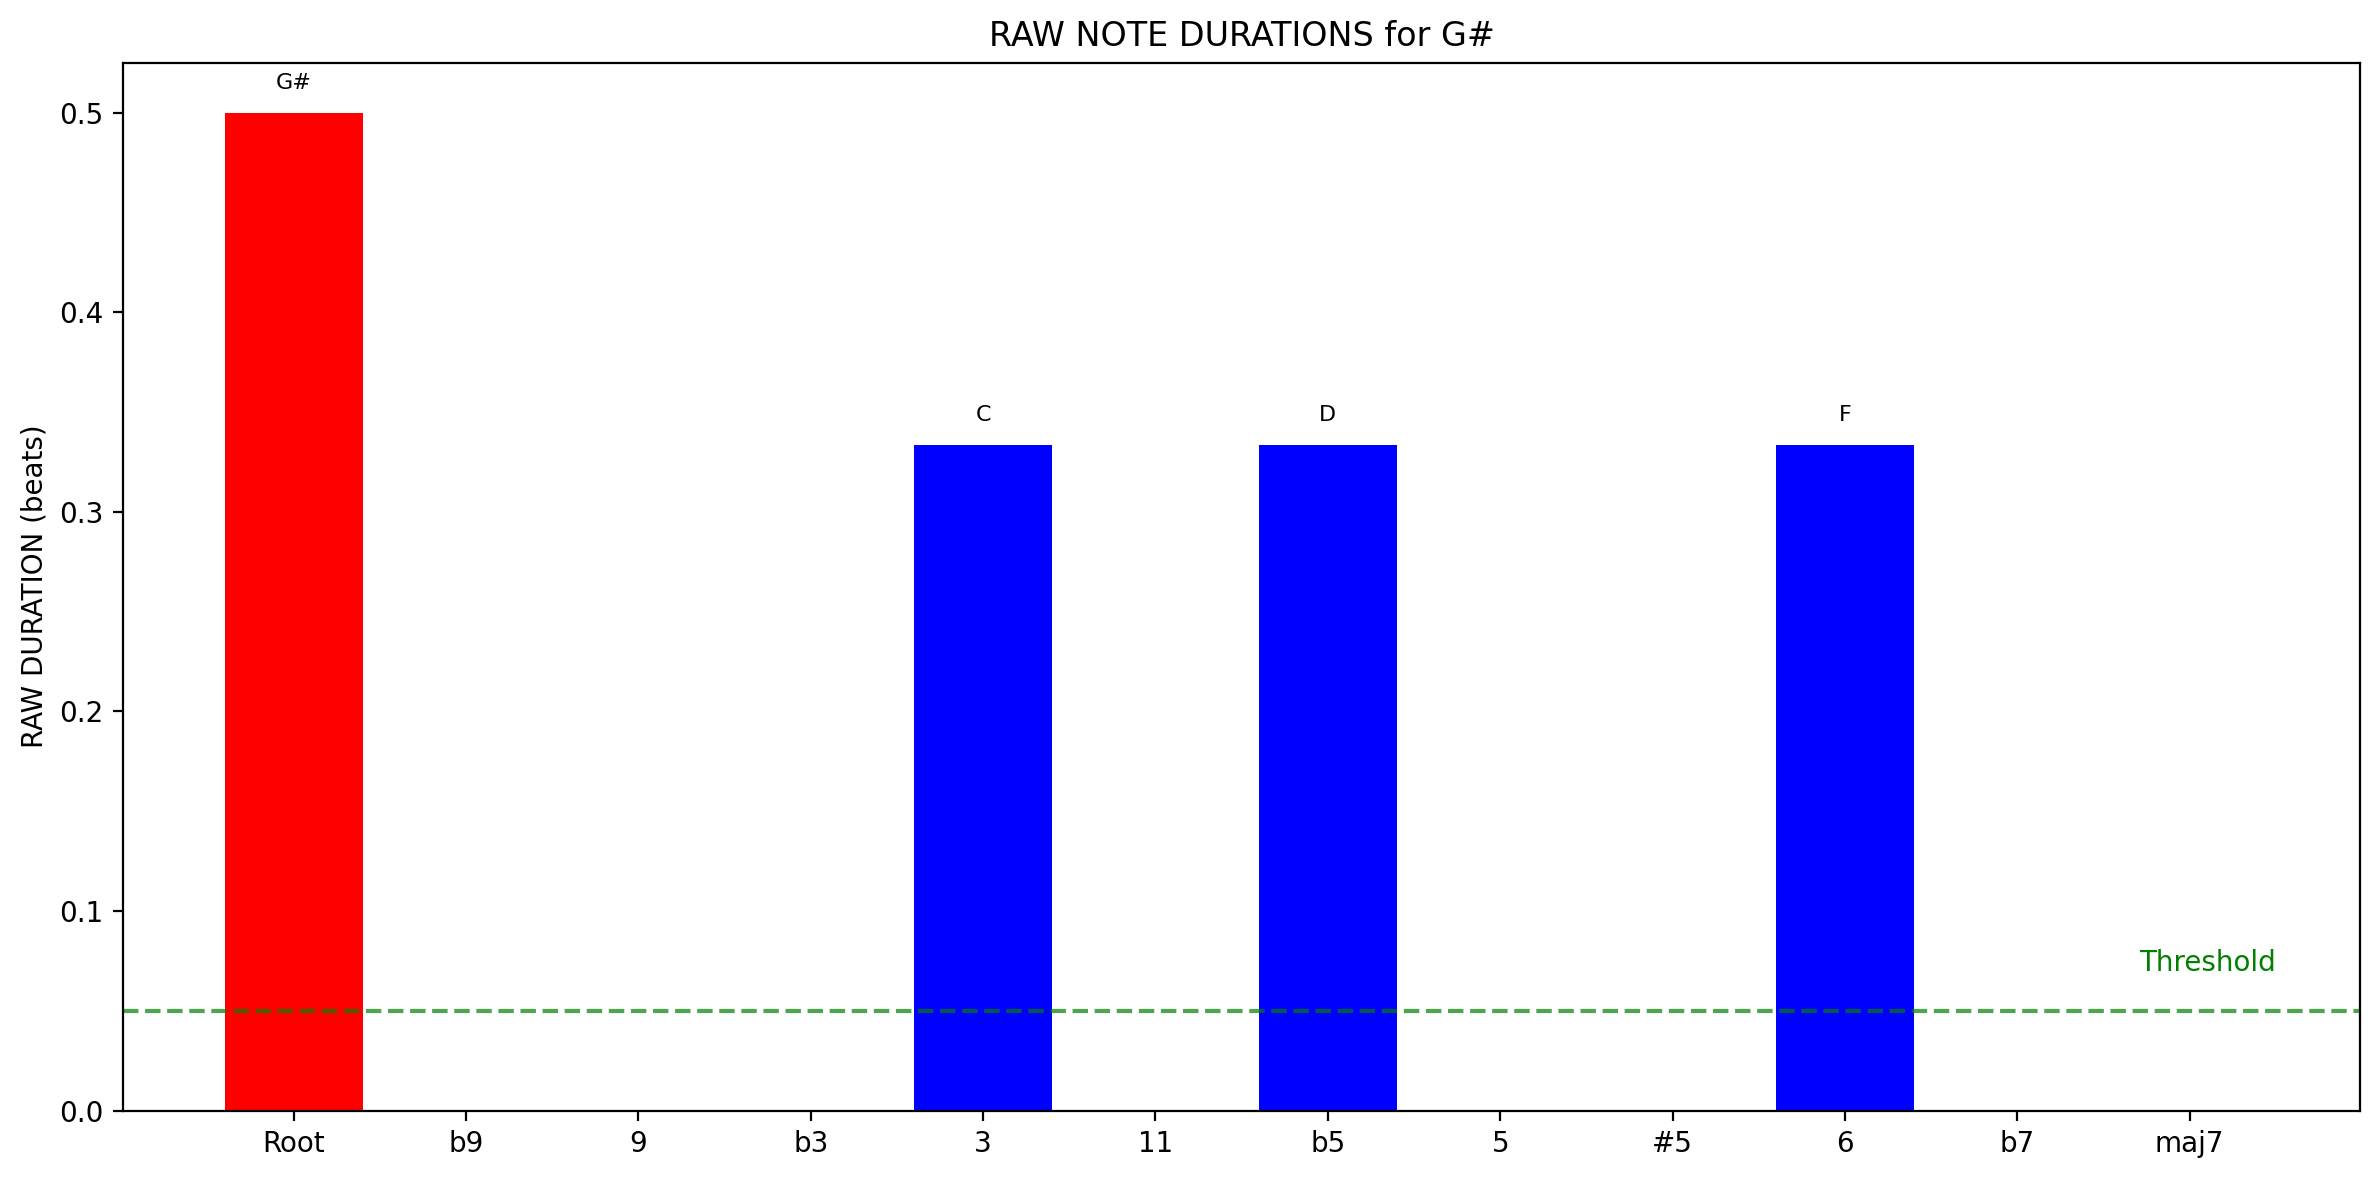


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.500      G#
4        3      0.333      C
6        b5     0.333      D
9        6      0.333      F


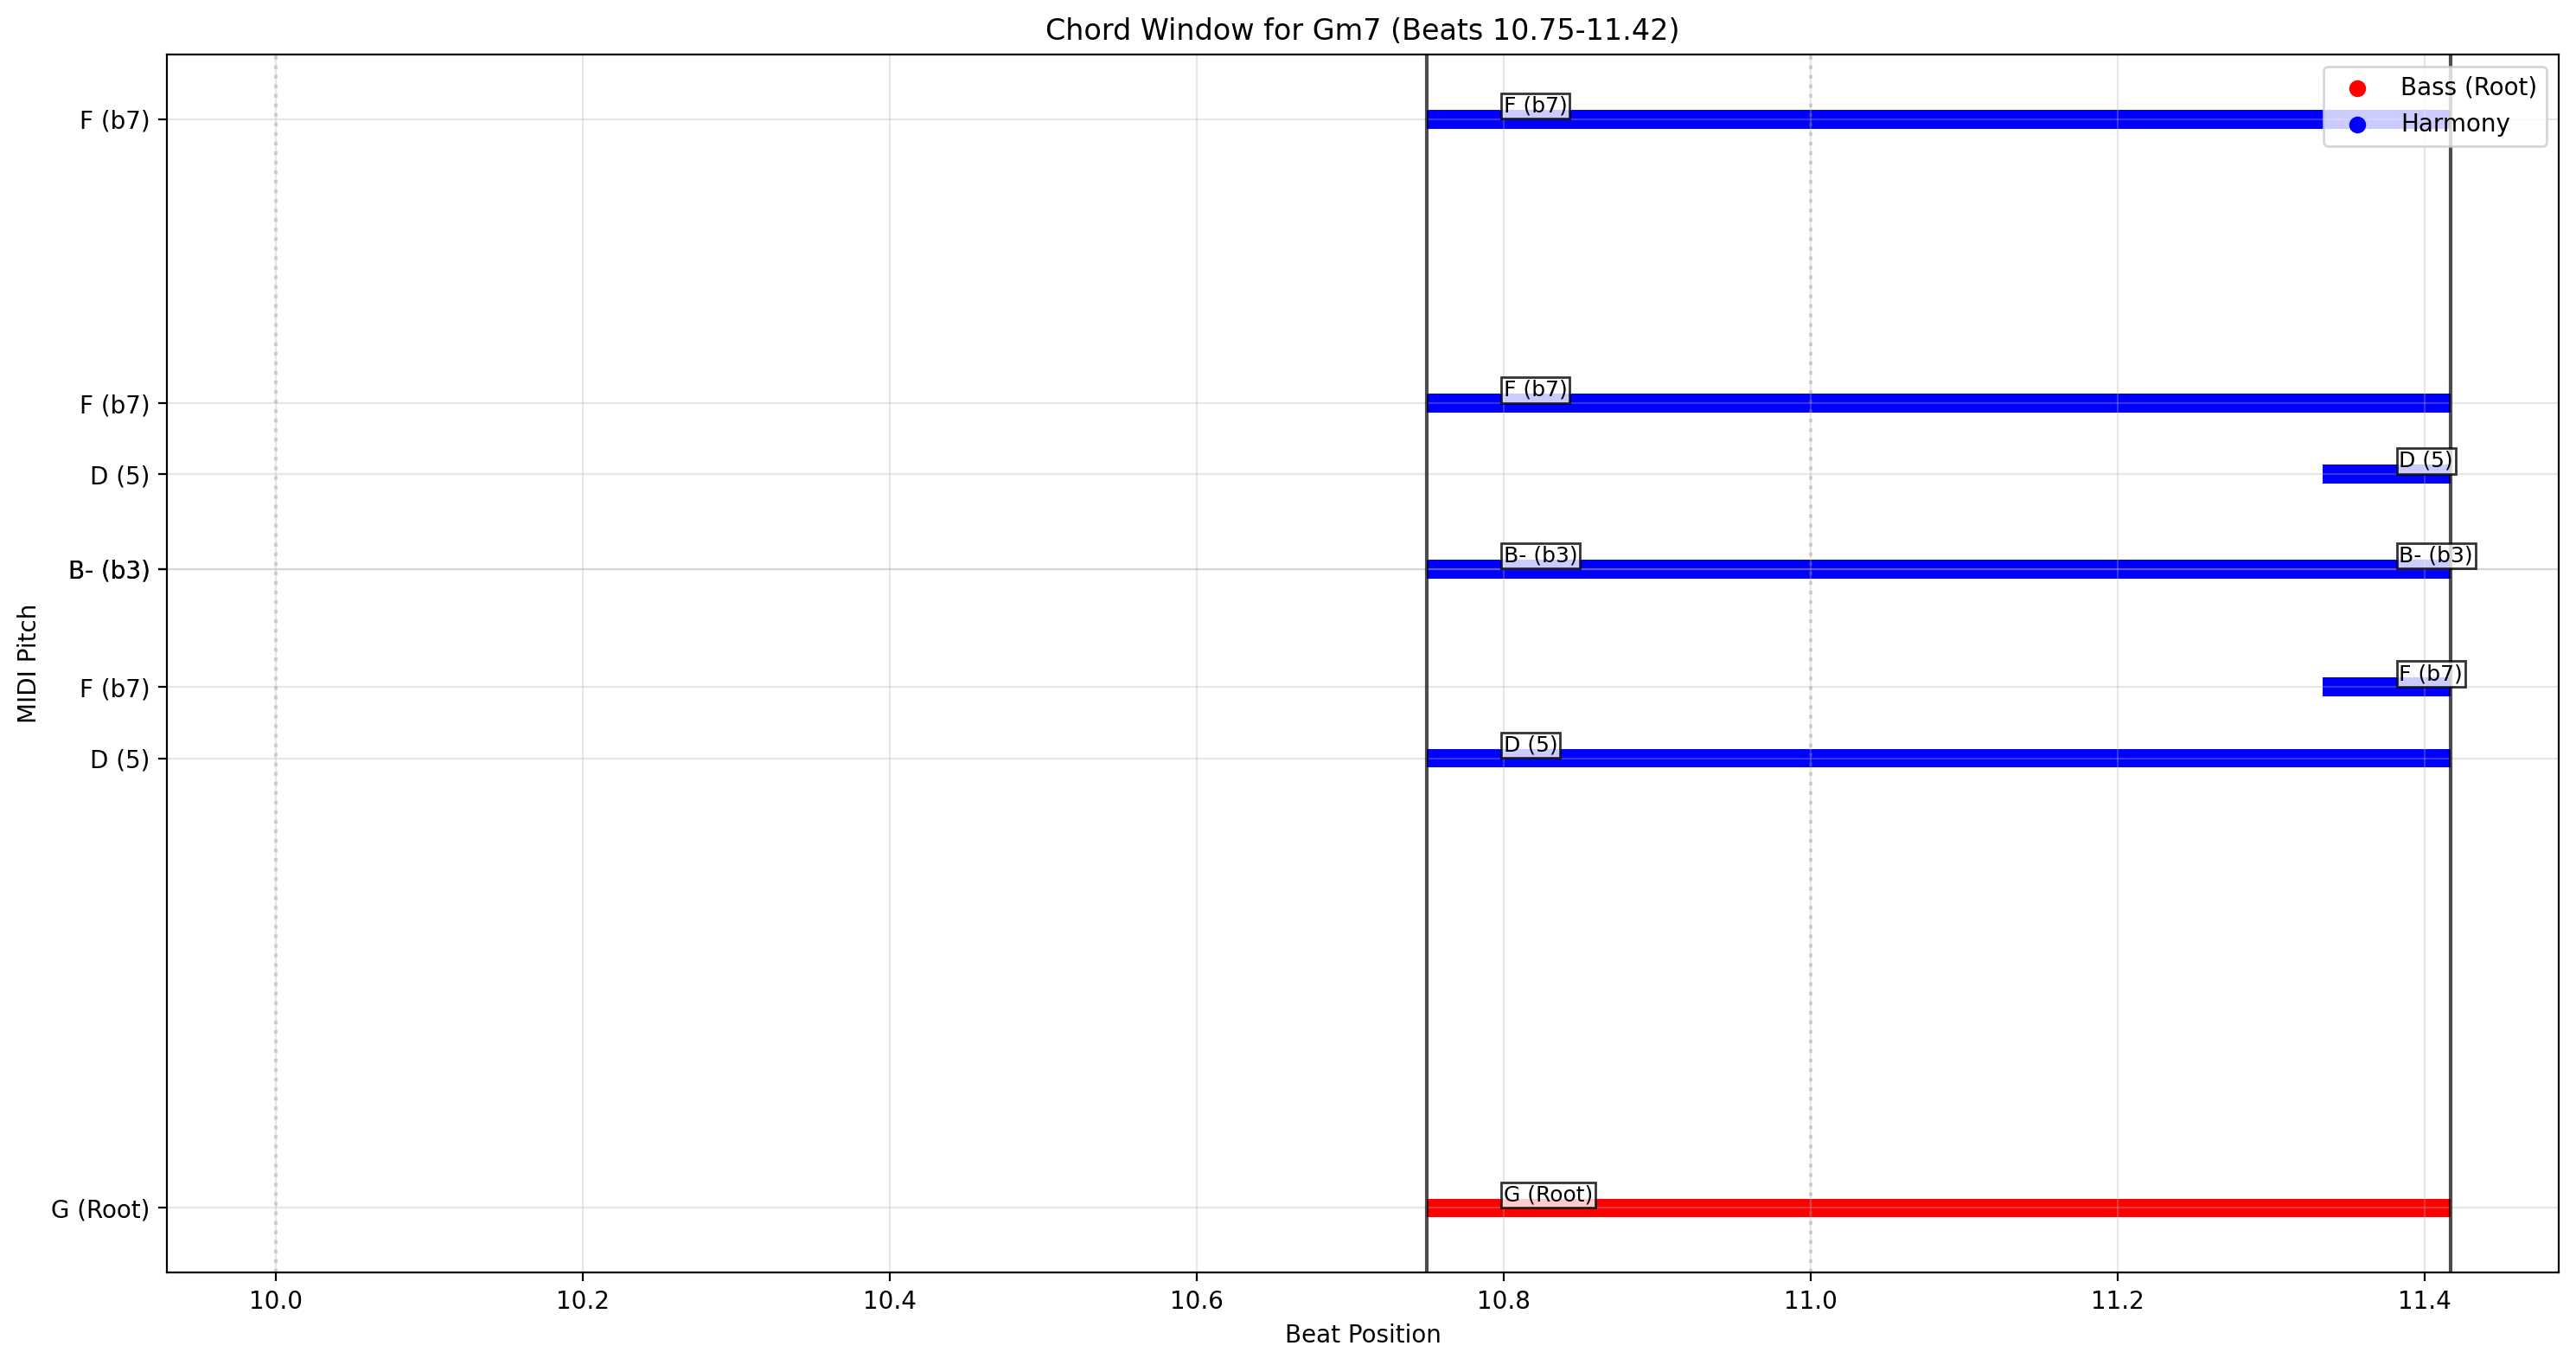


Bass note window 3: G (10.75-11.42)
  Active harmony notes: ['D', 'B-', 'F', 'F', 'B-', 'D', 'F']
  Intervals: [0, 3, 7, 10]
  Identified chord: Gm7


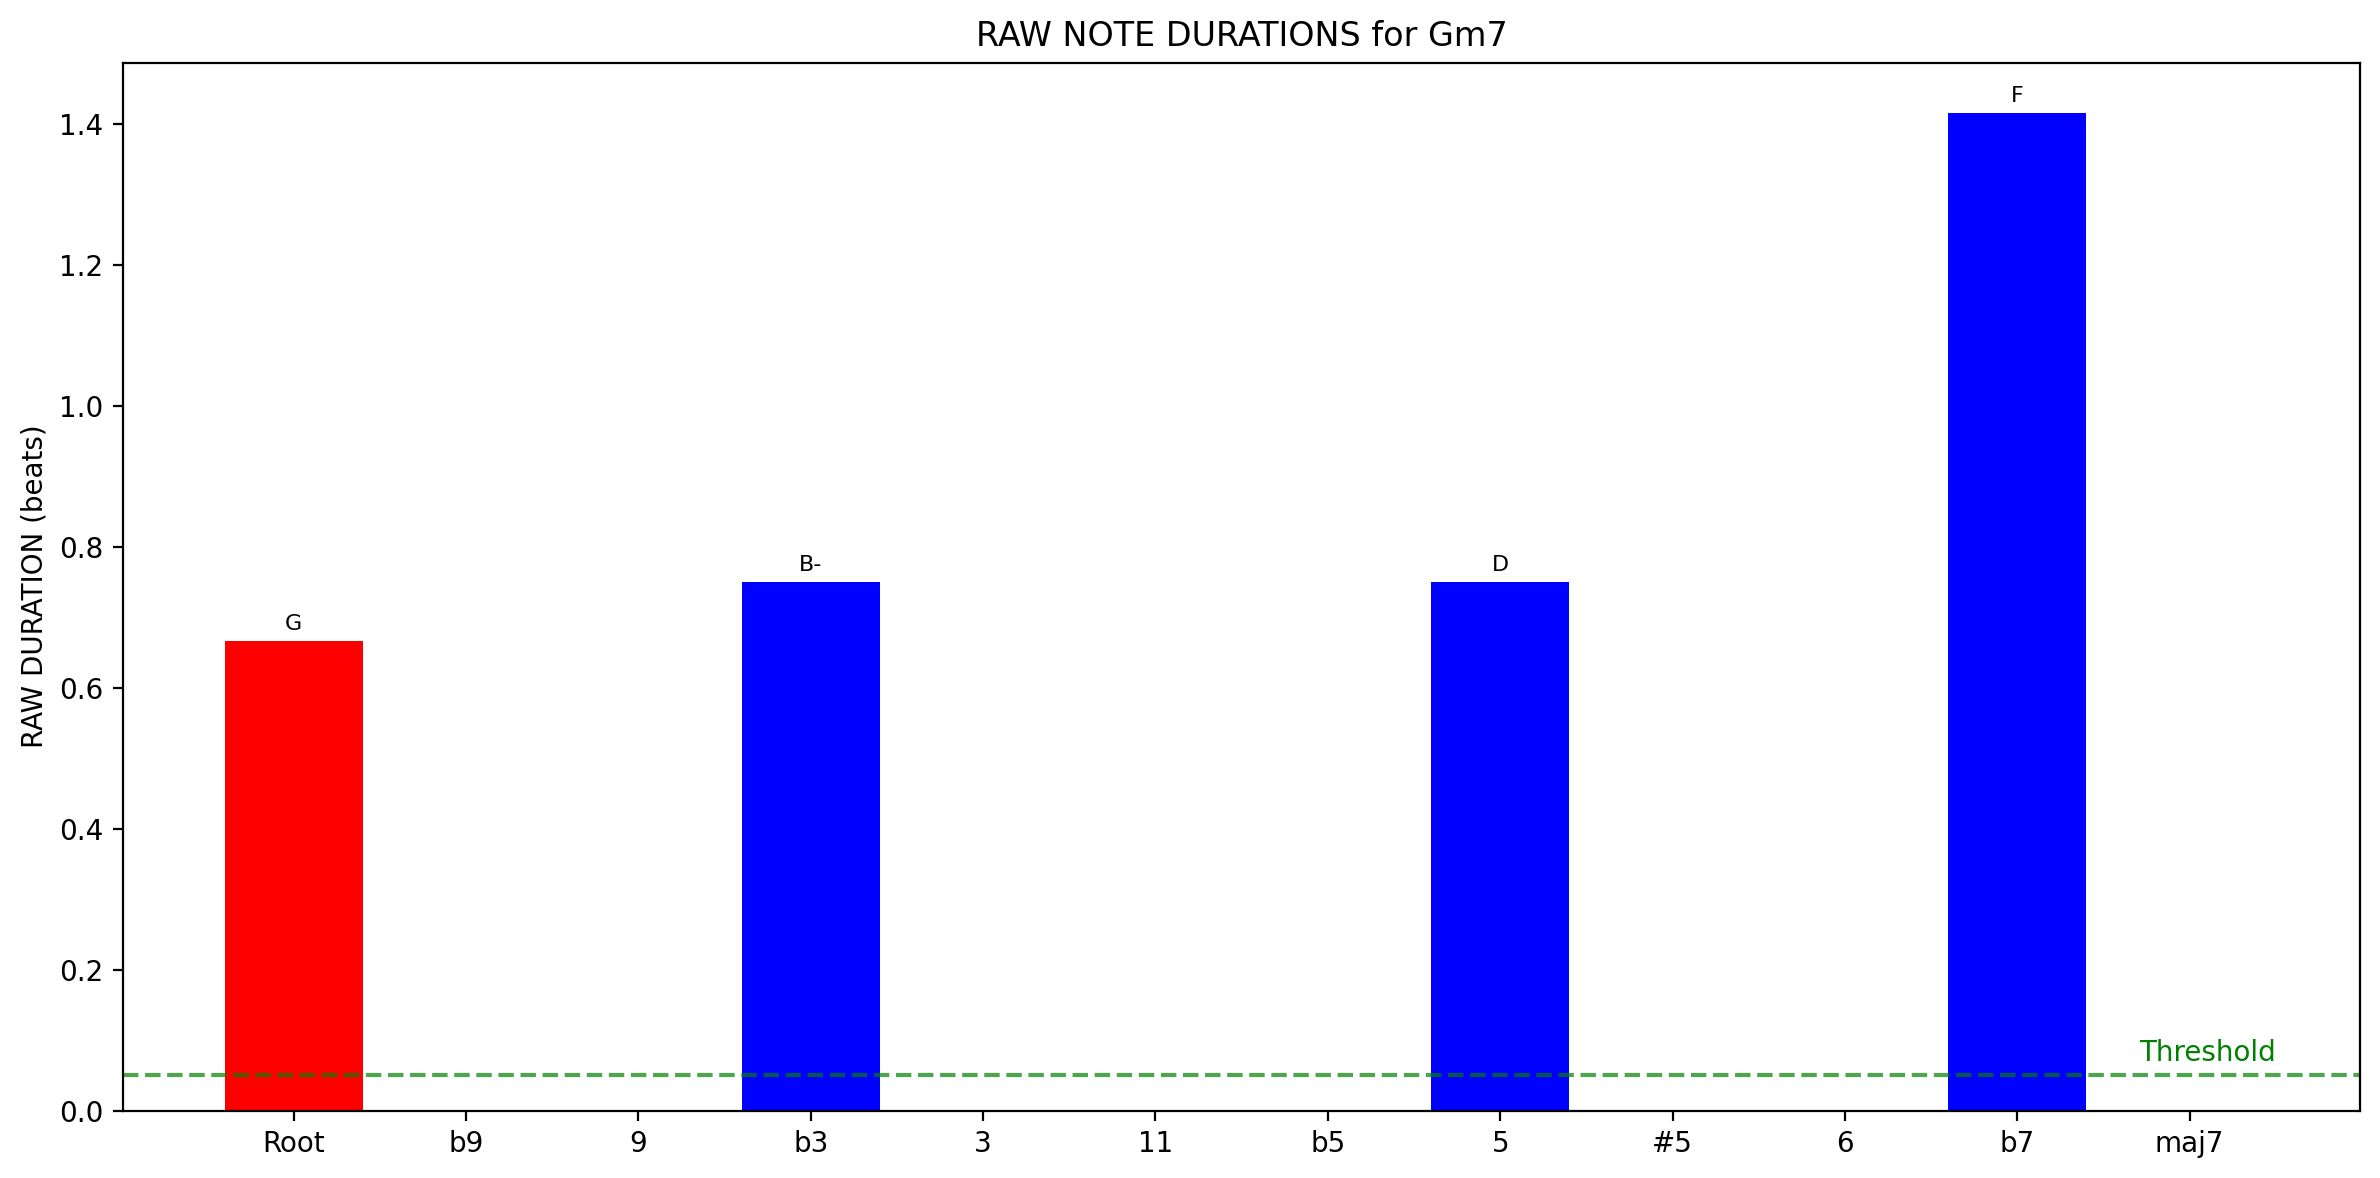


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
10       b7     1.417      F
3        b3     0.750      B-
7        5      0.750      D
0        Root   0.667      G


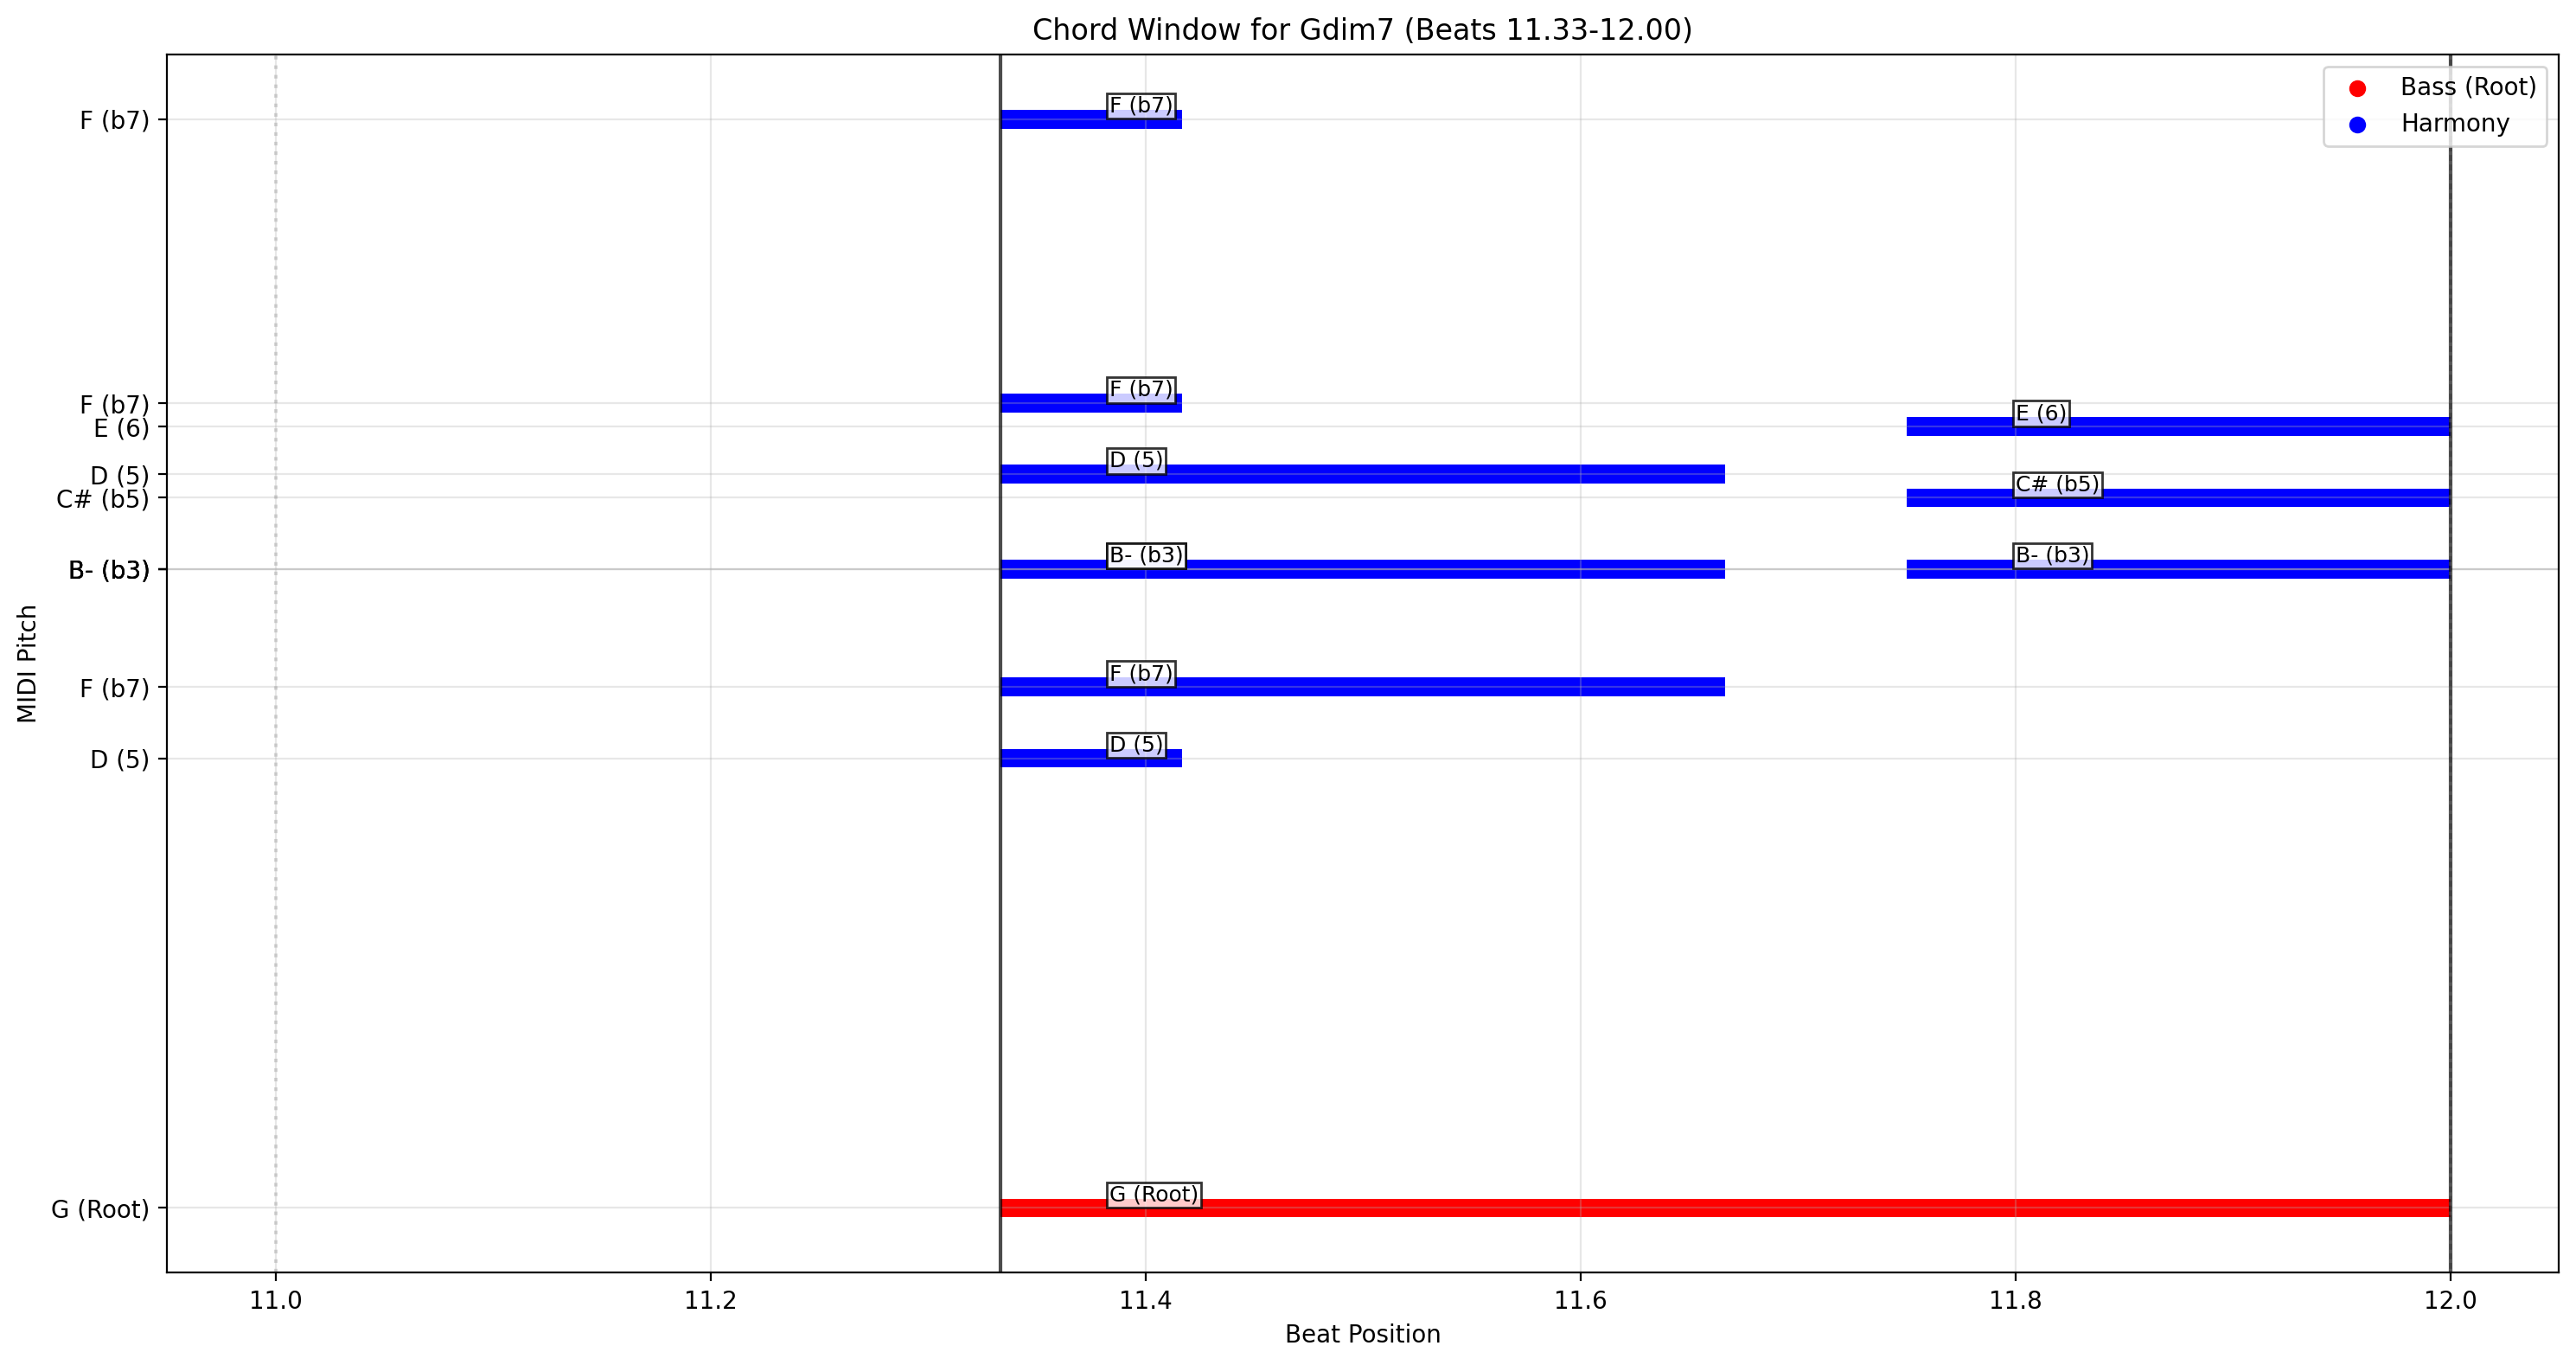


Bass note window 4: G (11.33-12.00)
  Active harmony notes: ['D', 'B-', 'F', 'F', 'B-', 'D', 'F', 'C#', 'E', 'B-']
  Intervals: [0, 3, 6, 7, 9, 10]
  Identified chord: Gdim7


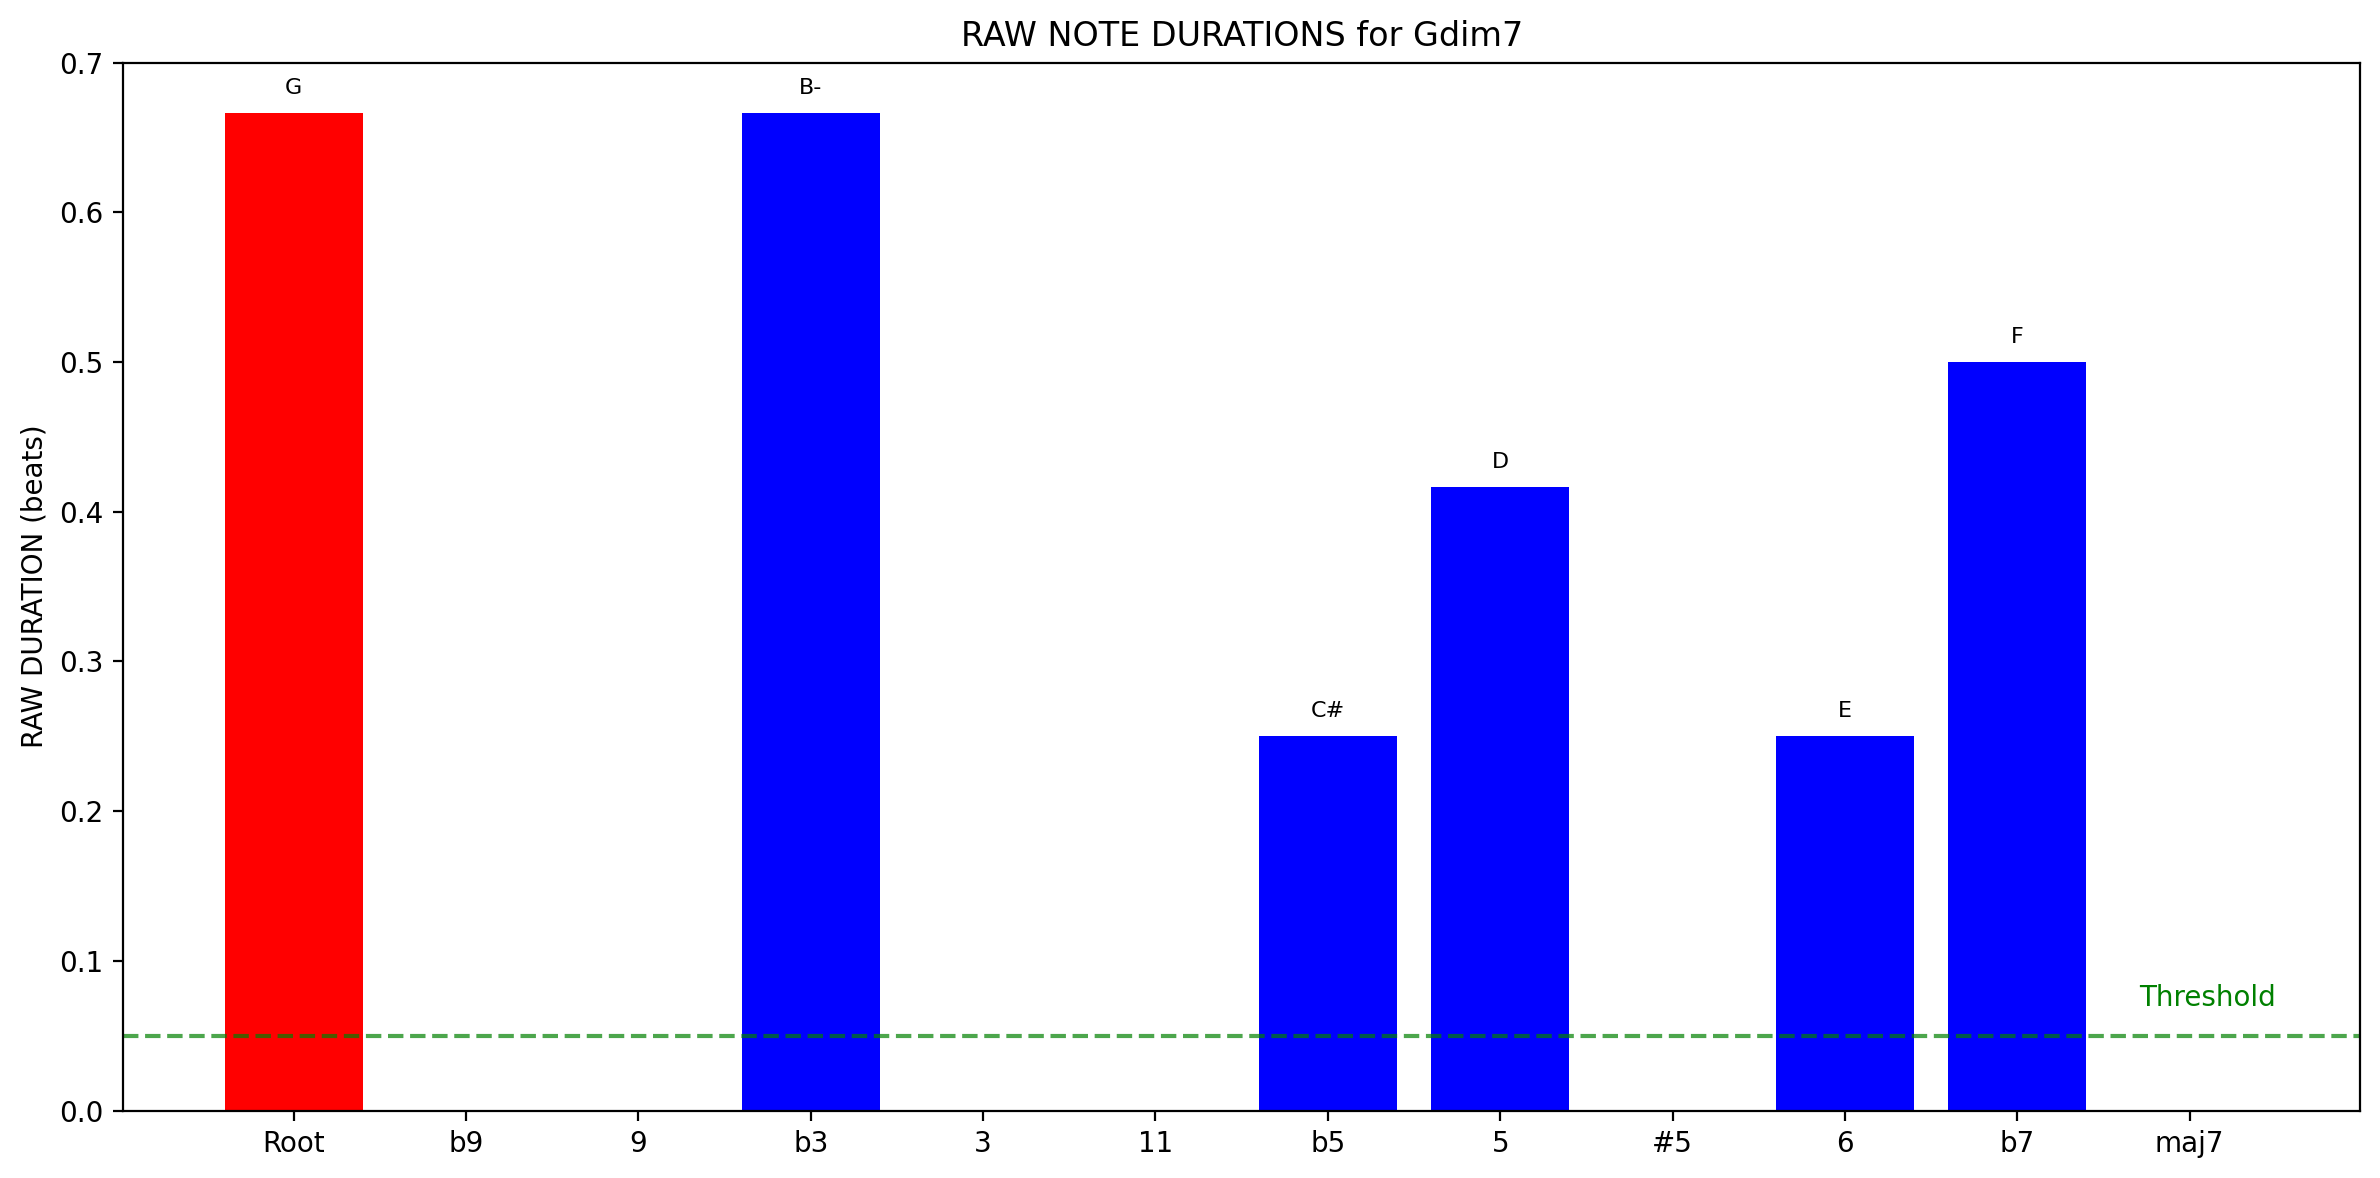


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.667      G
3        b3     0.667      B-
10       b7     0.500      F
7        5      0.417      D
6        b5     0.250      C#
9        6      0.250      E

=== Analyzing Bar 4 with Time Windows ===

Bass notes in bar 4:
  G (PC 7): 12.00-12.08
  C# (PC 1): 12.75-13.25
  C# (PC 1): 13.50-14.25
  D (PC 2): 15.00-15.50
  D (PC 2): 15.50-16.00


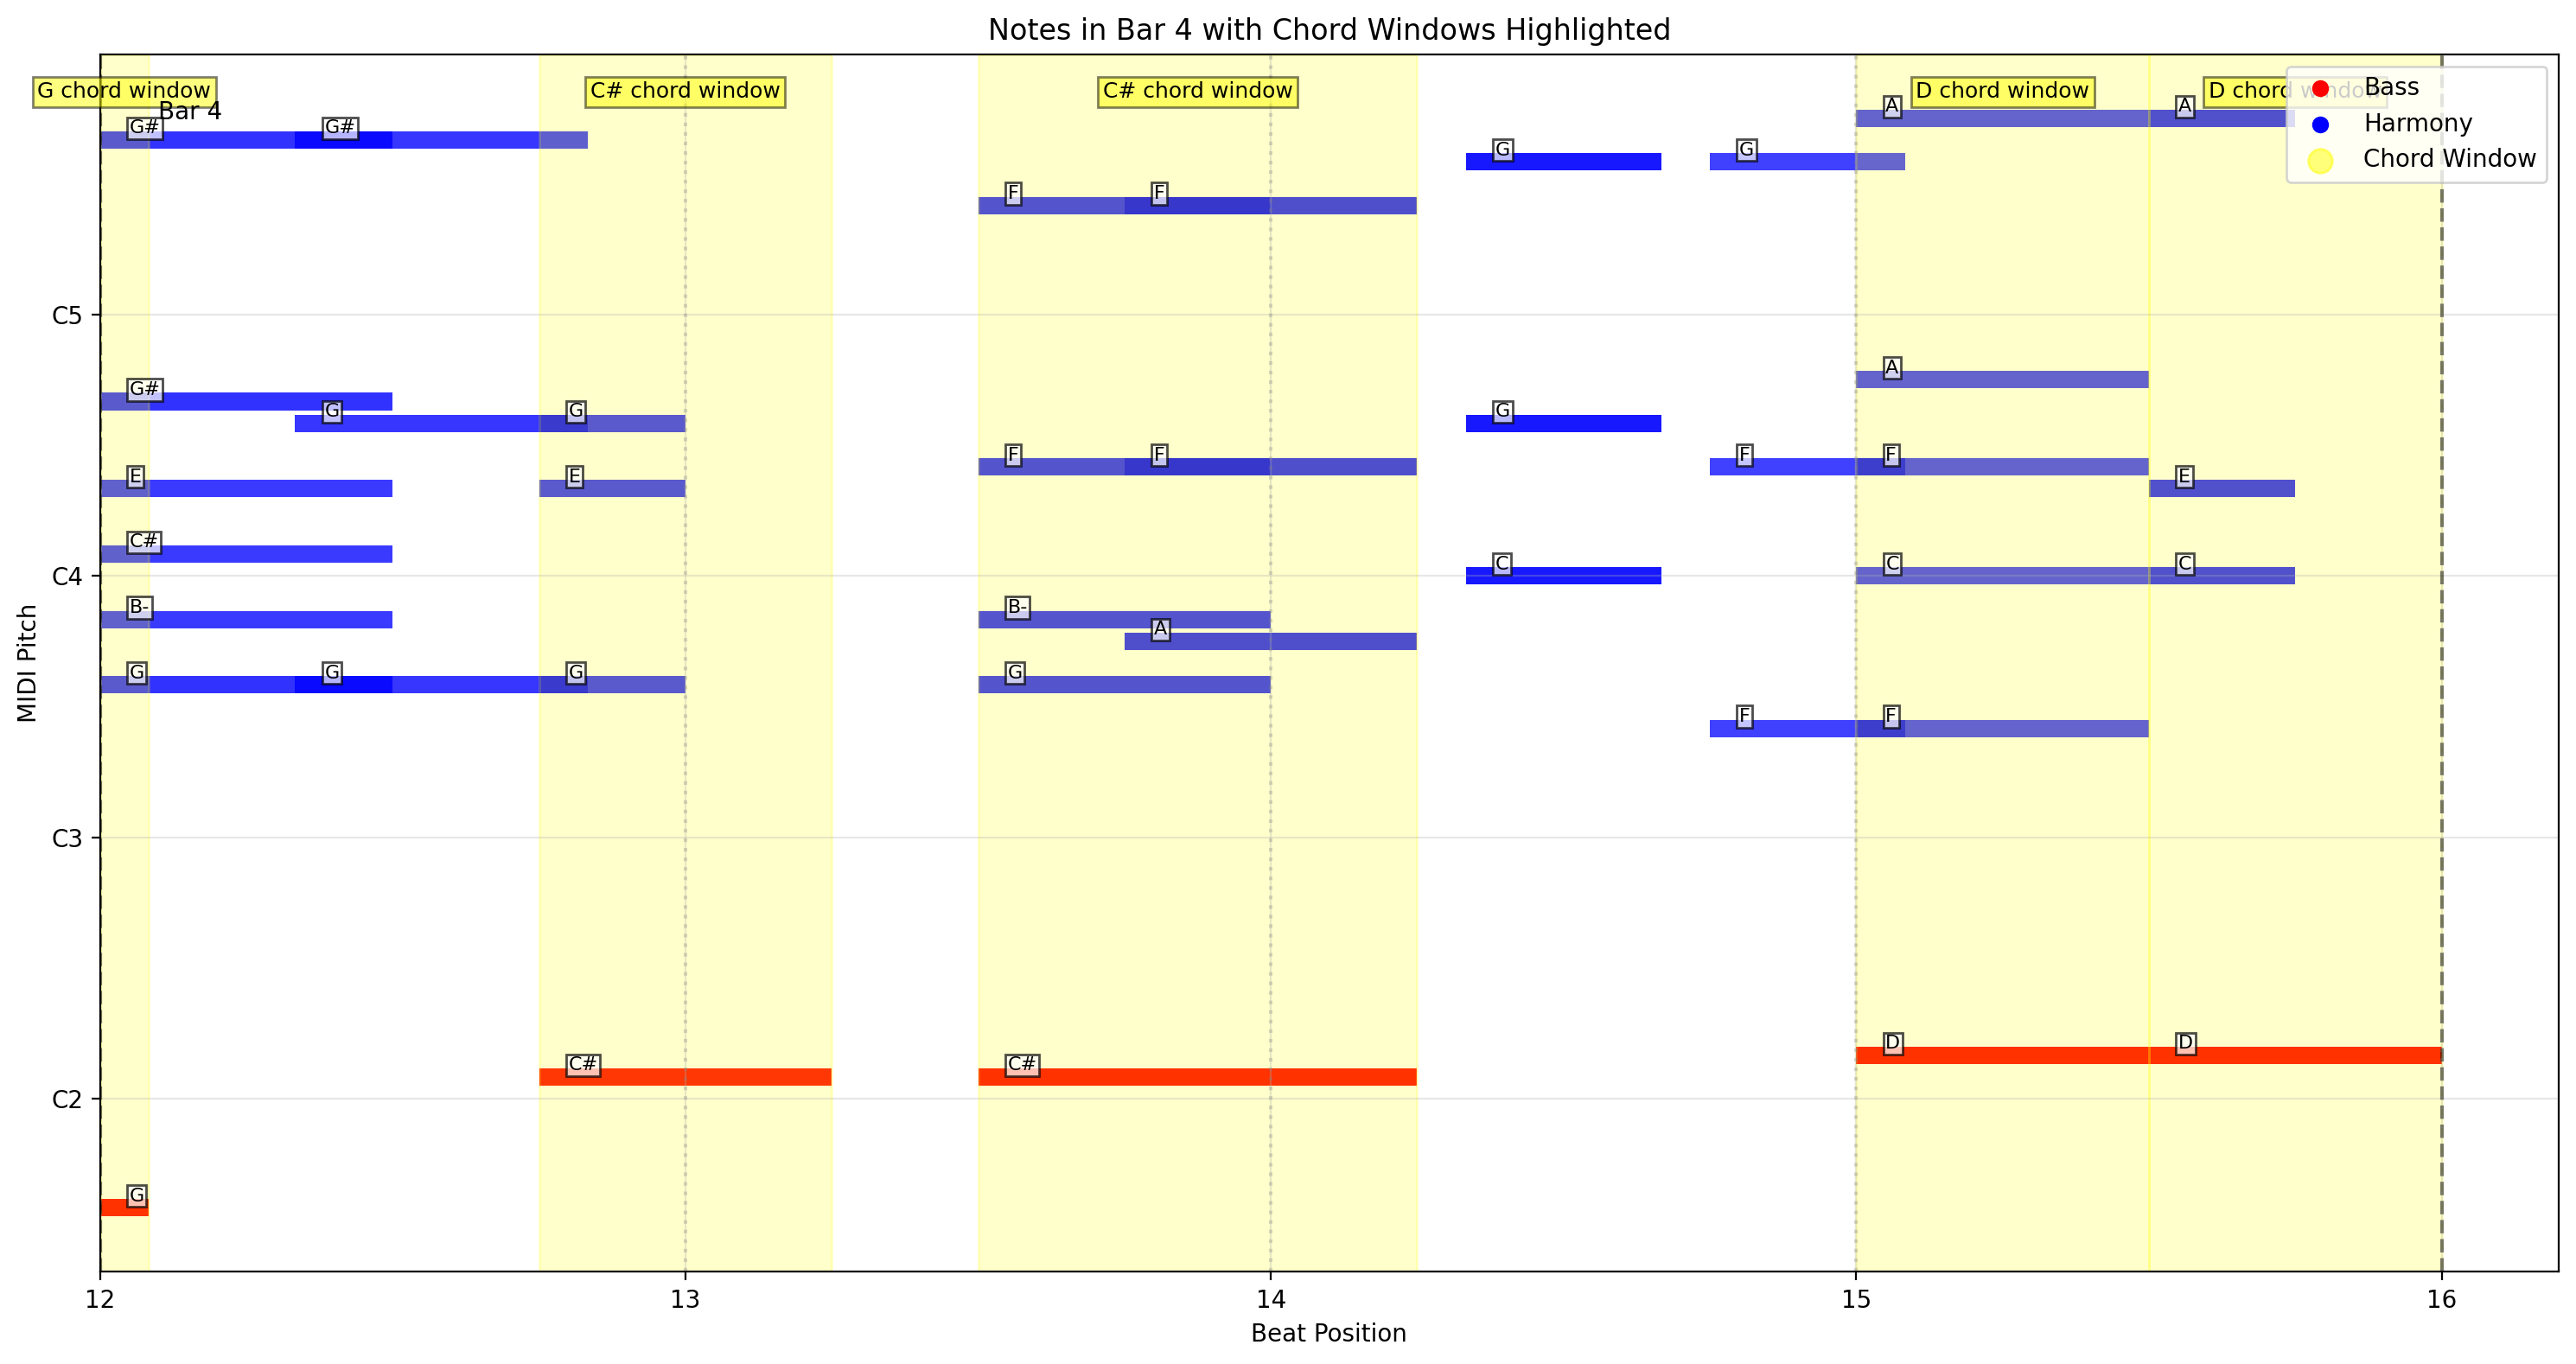

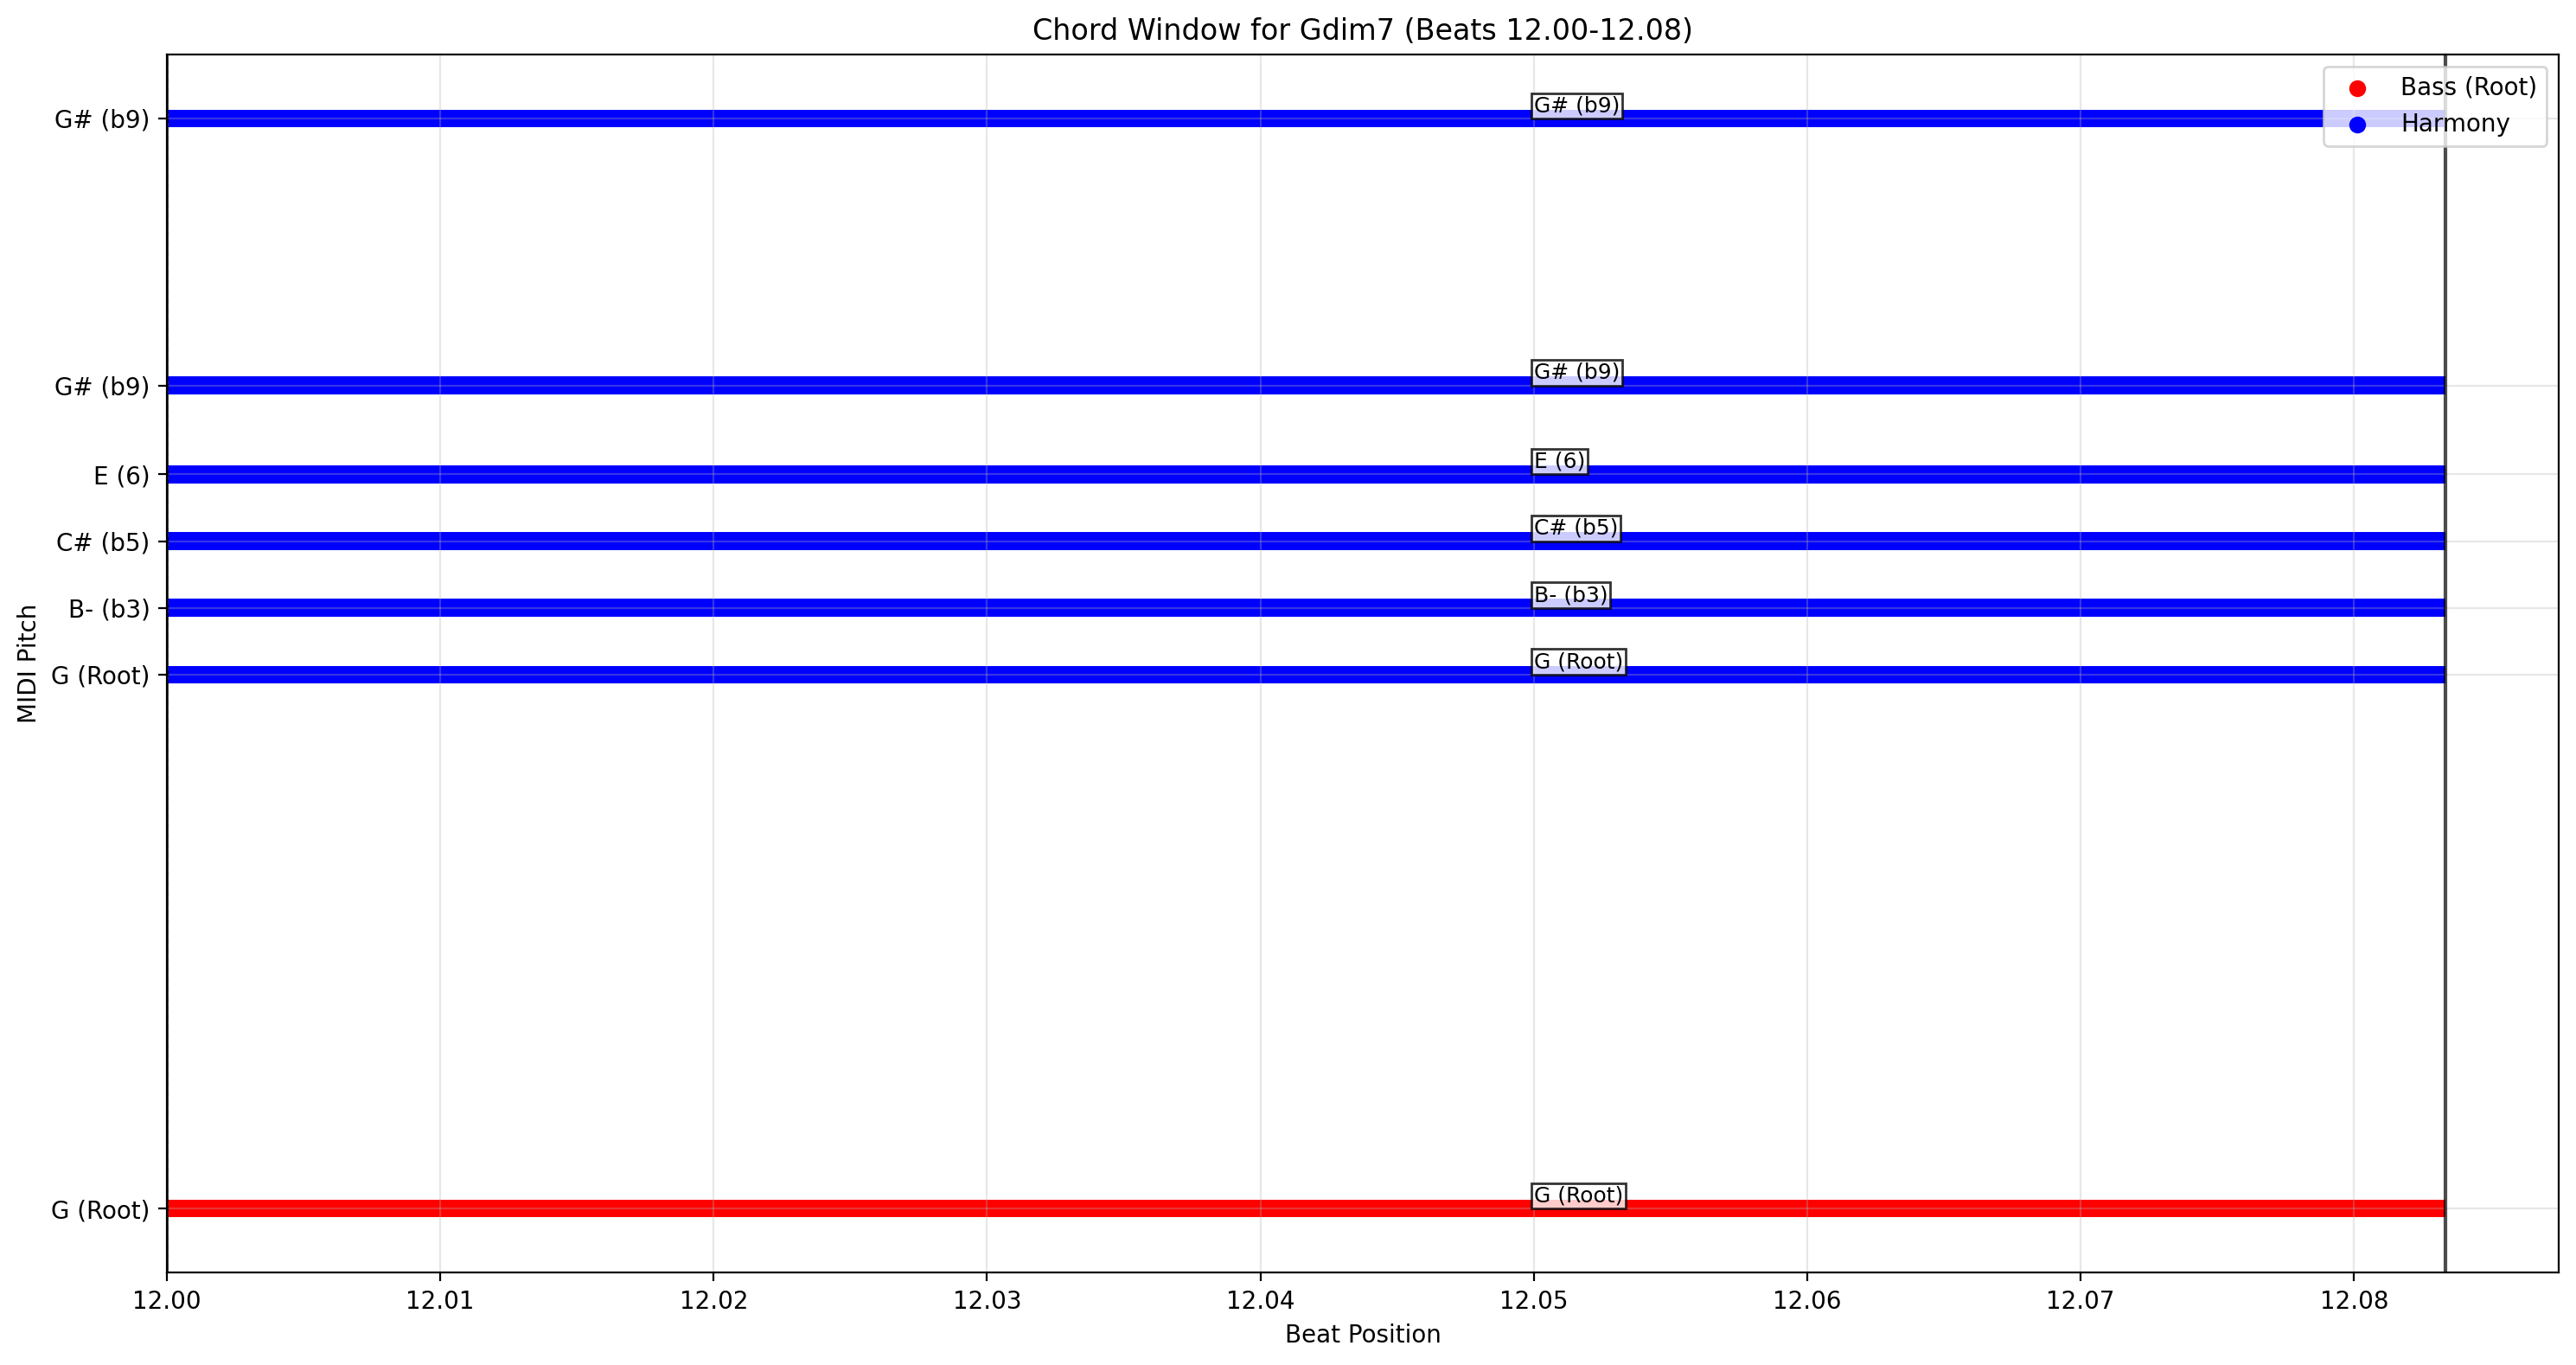


Bass note window 1: G (12.00-12.08)
  Active harmony notes: ['G#', 'G', 'G#', 'C#', 'E', 'B-']
  Intervals: [0, 1, 3, 6, 9]
  Identified chord: Gdim7


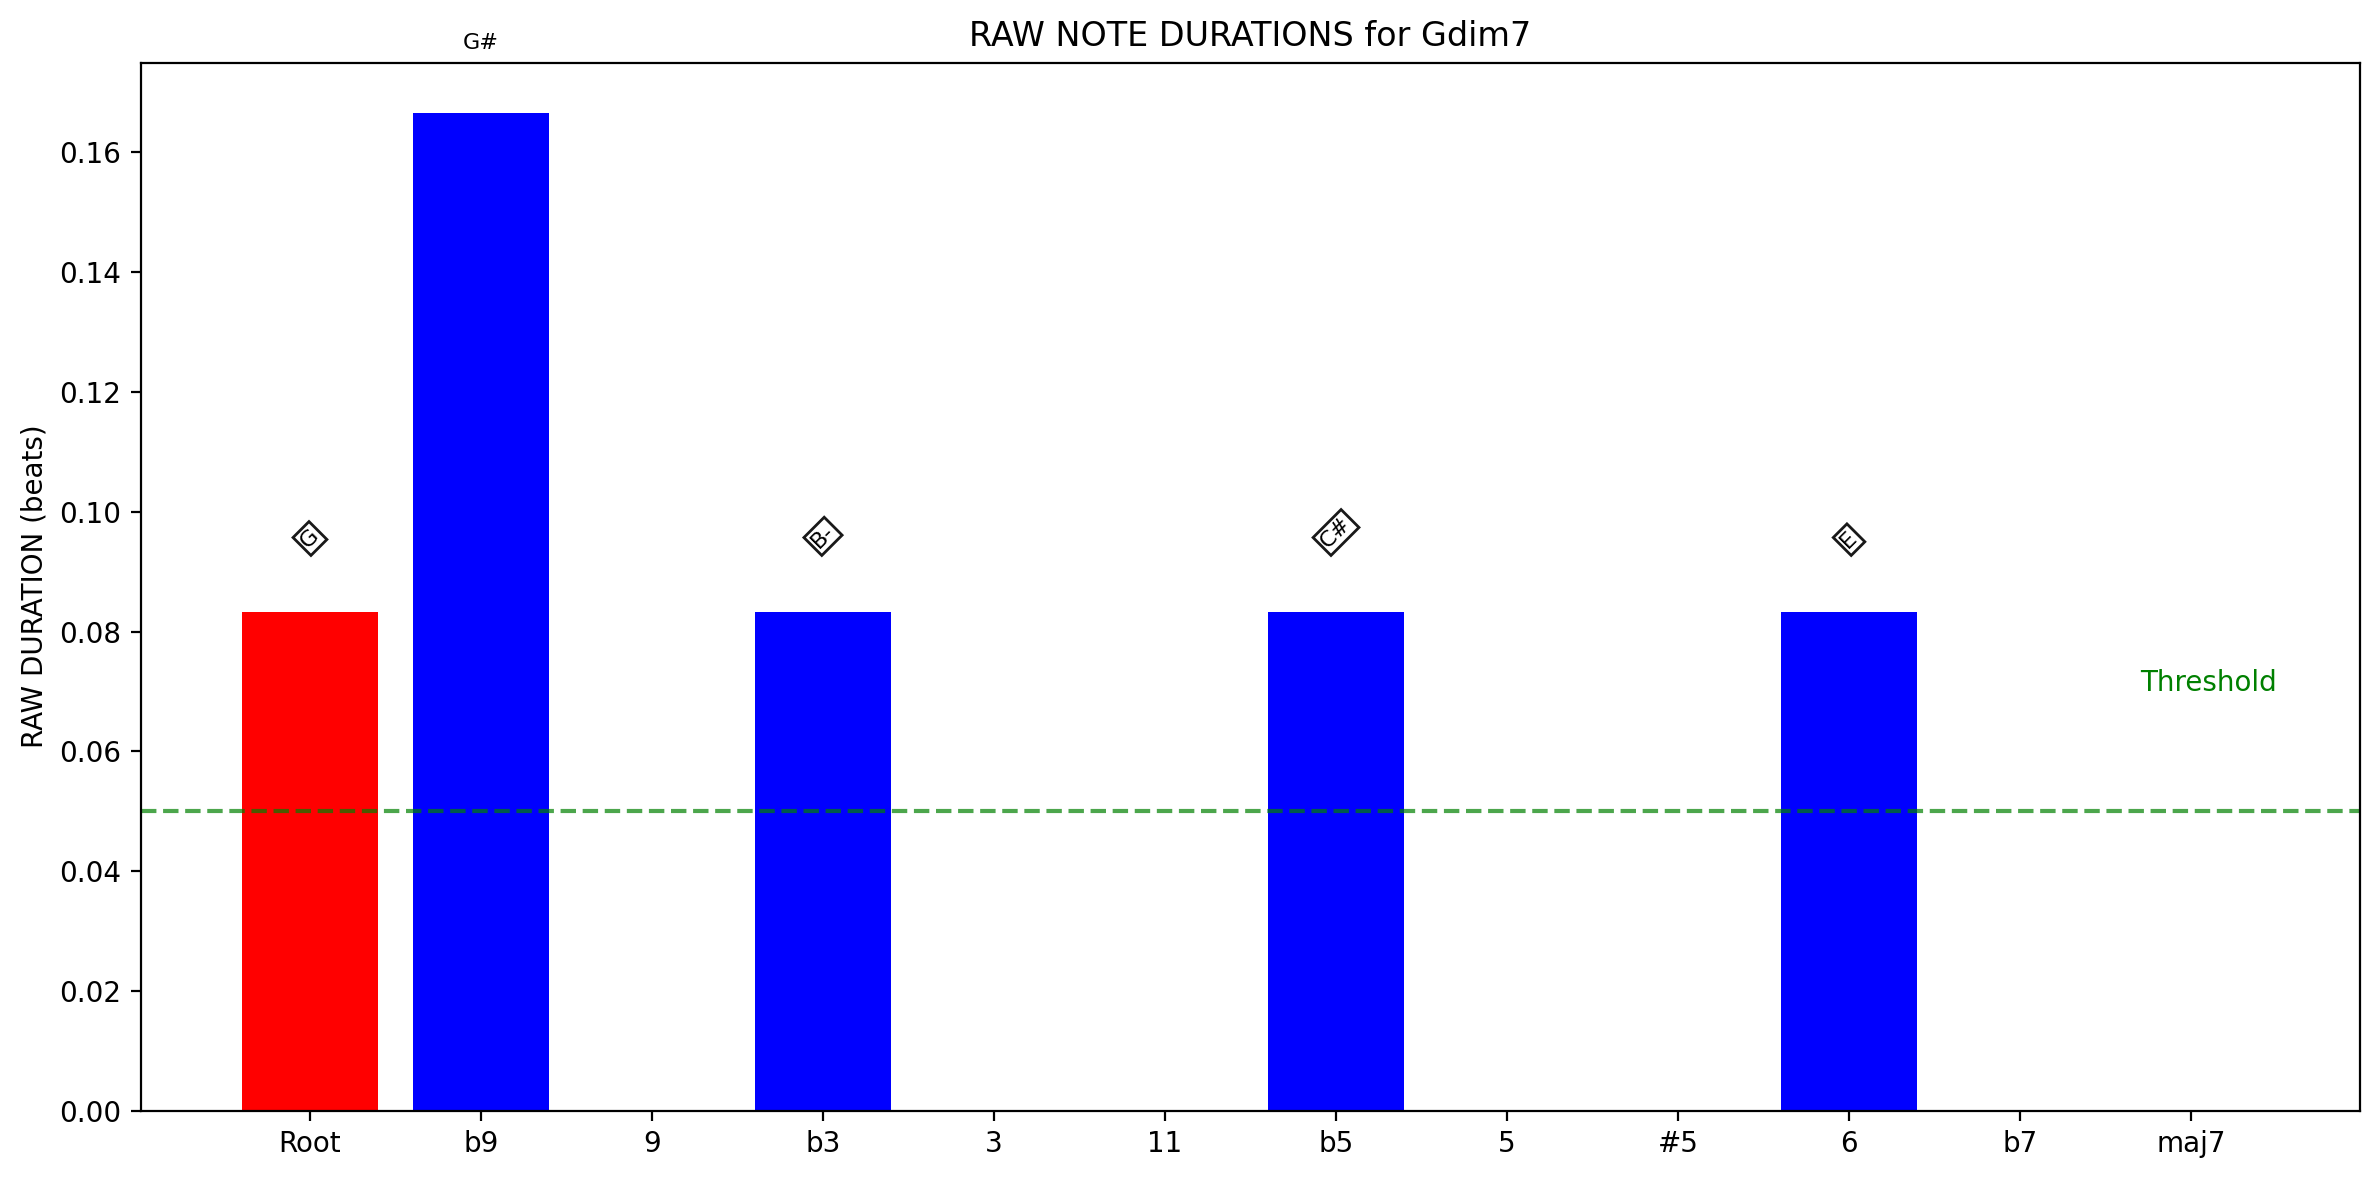


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
1        b9     0.167      G#
0        Root   0.083      G
3        b3     0.083      B-
6        b5     0.083      C#
9        6      0.083      E


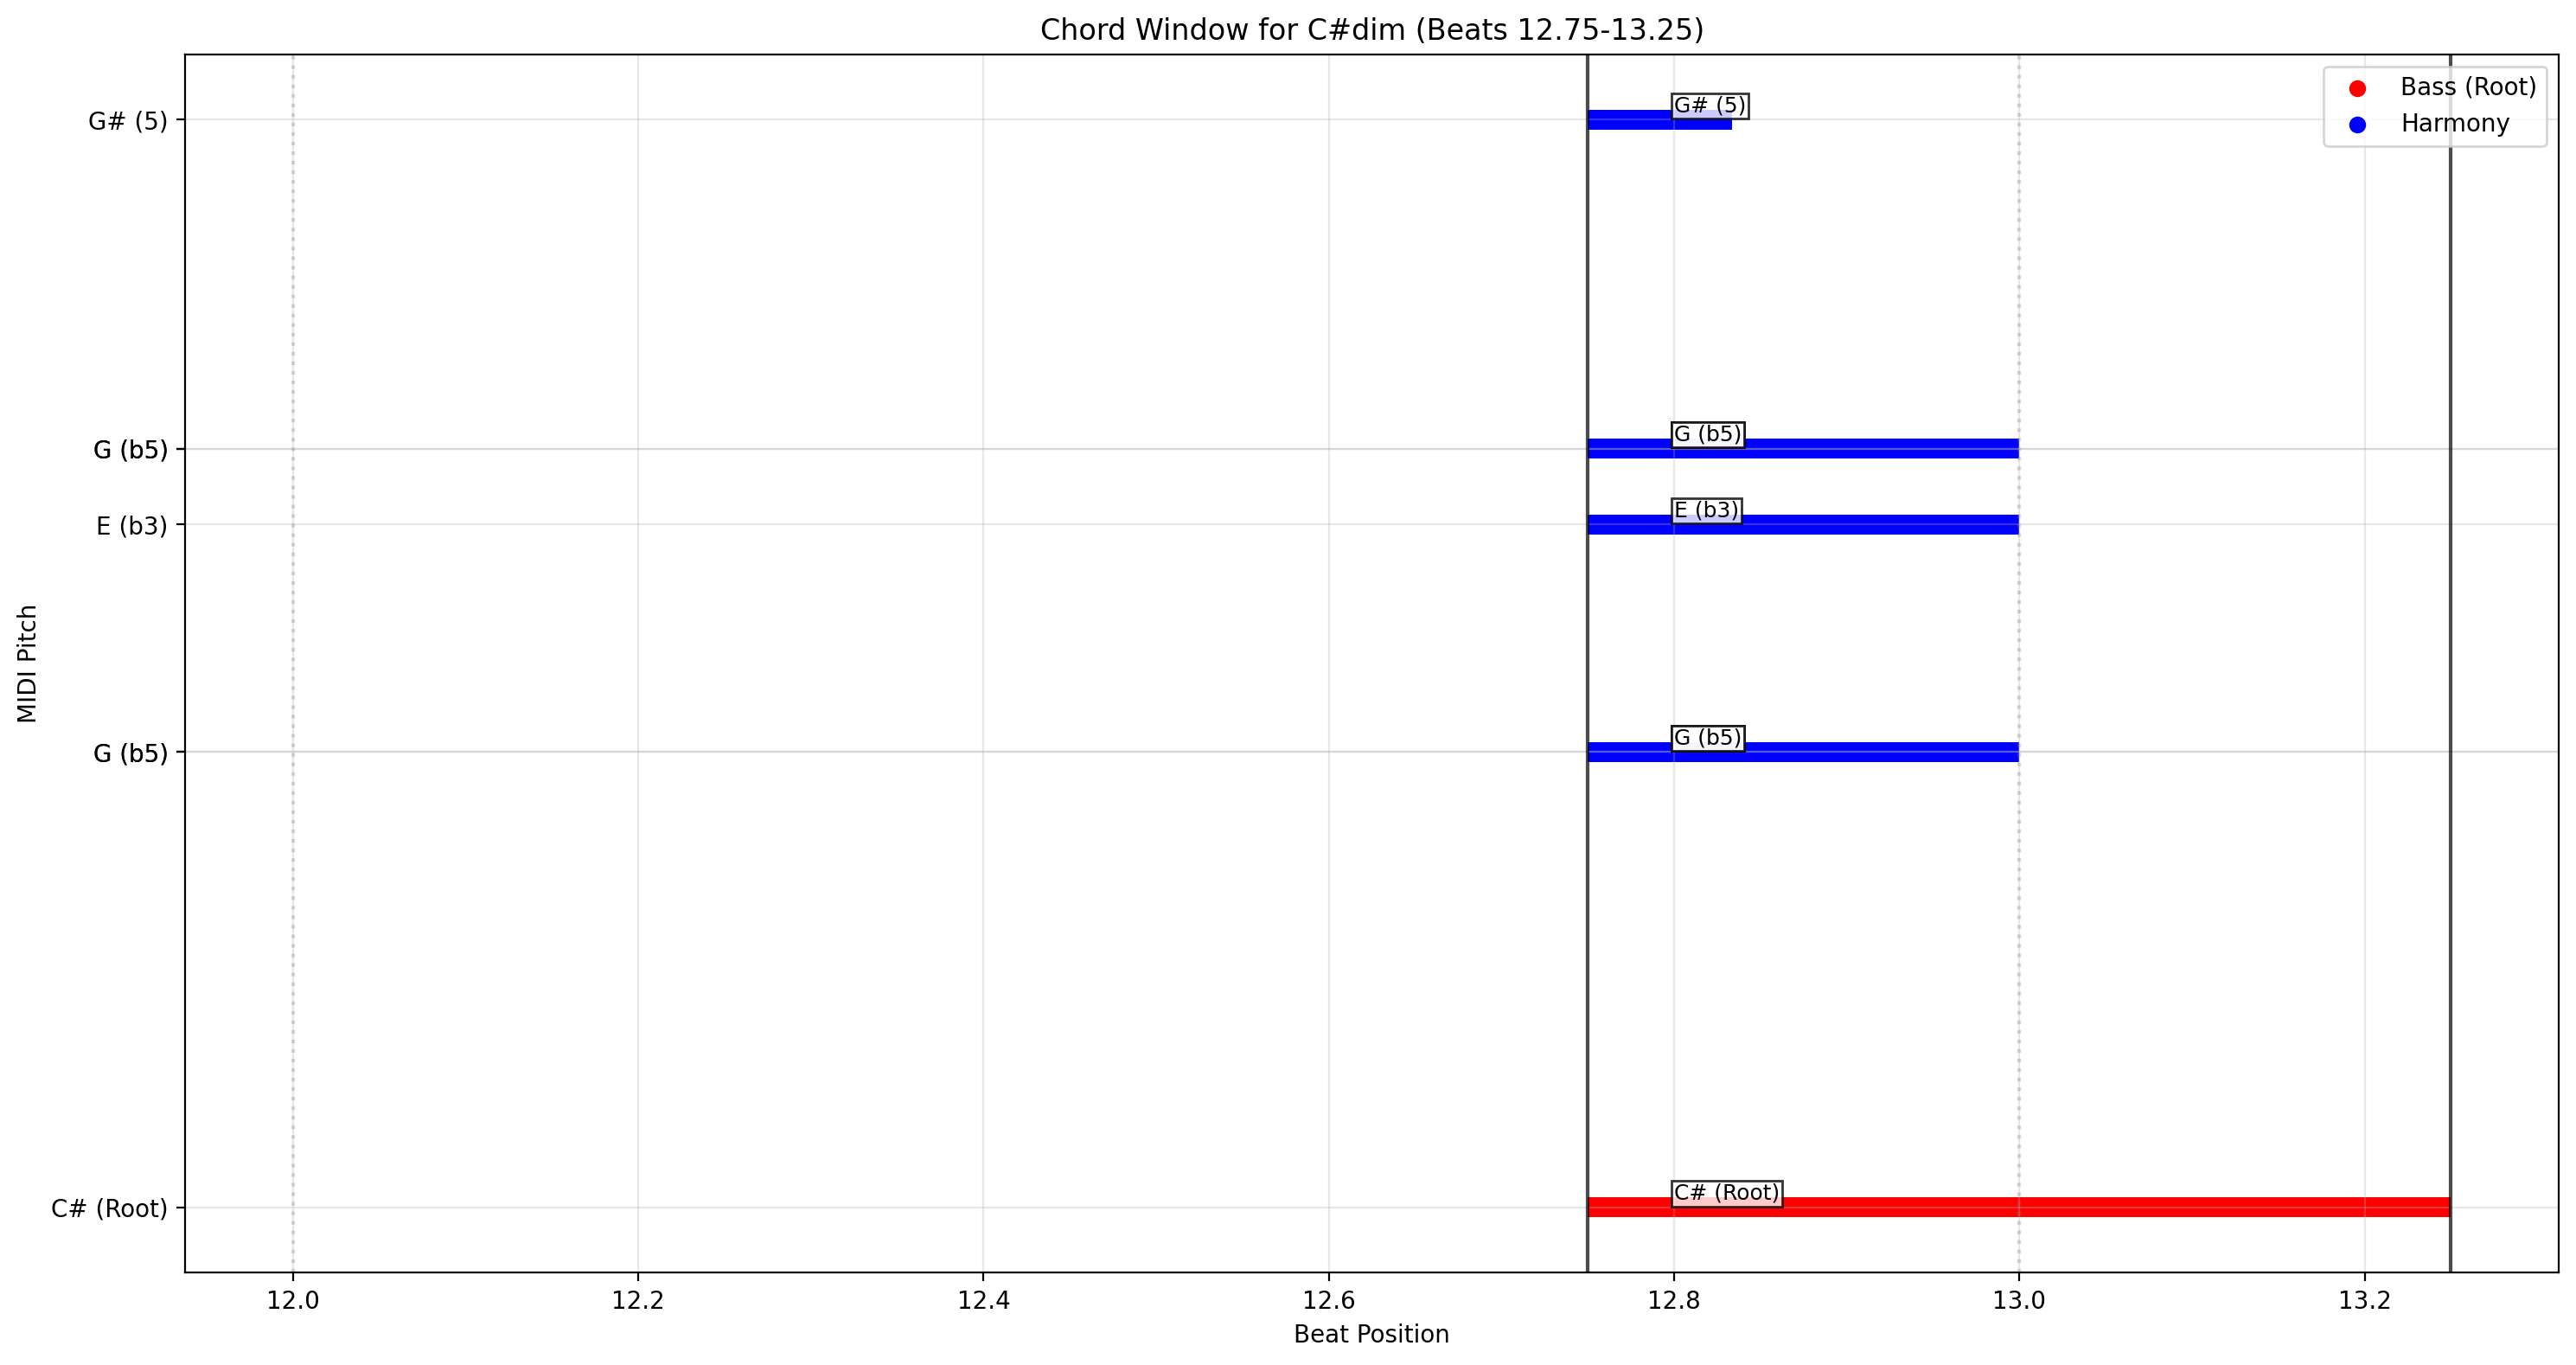


Bass note window 2: C# (12.75-13.25)
  Active harmony notes: ['G', 'G#', 'G', 'G', 'E', 'G']
  Intervals: [0, 3, 6, 7]
  Identified chord: C#dim


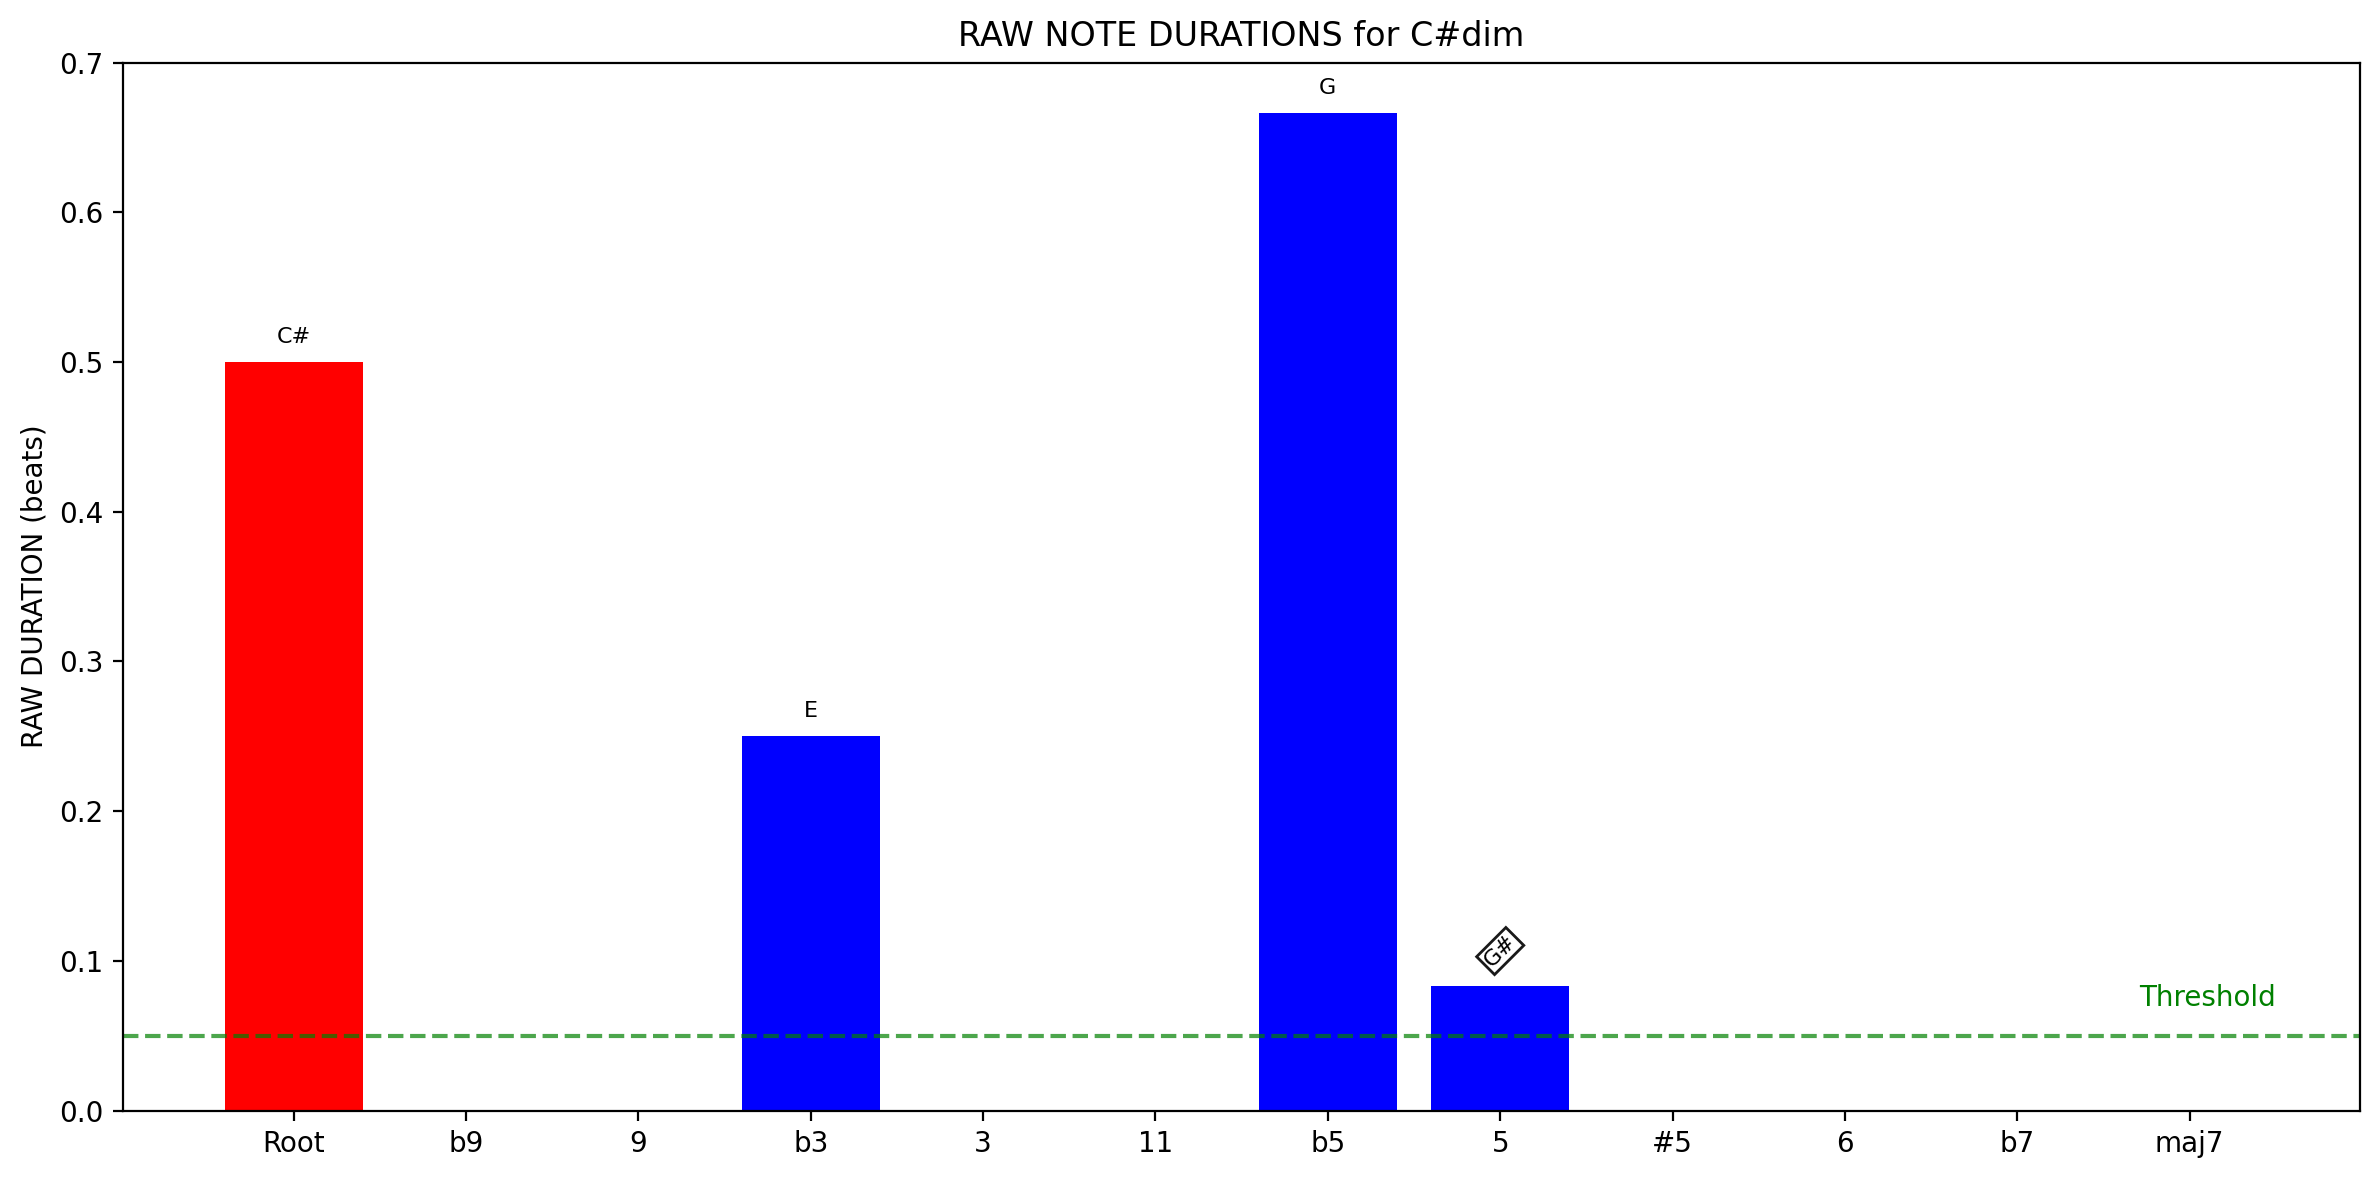


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
6        b5     0.667      G
0        Root   0.500      C#
3        b3     0.250      E
7        5      0.083      G#


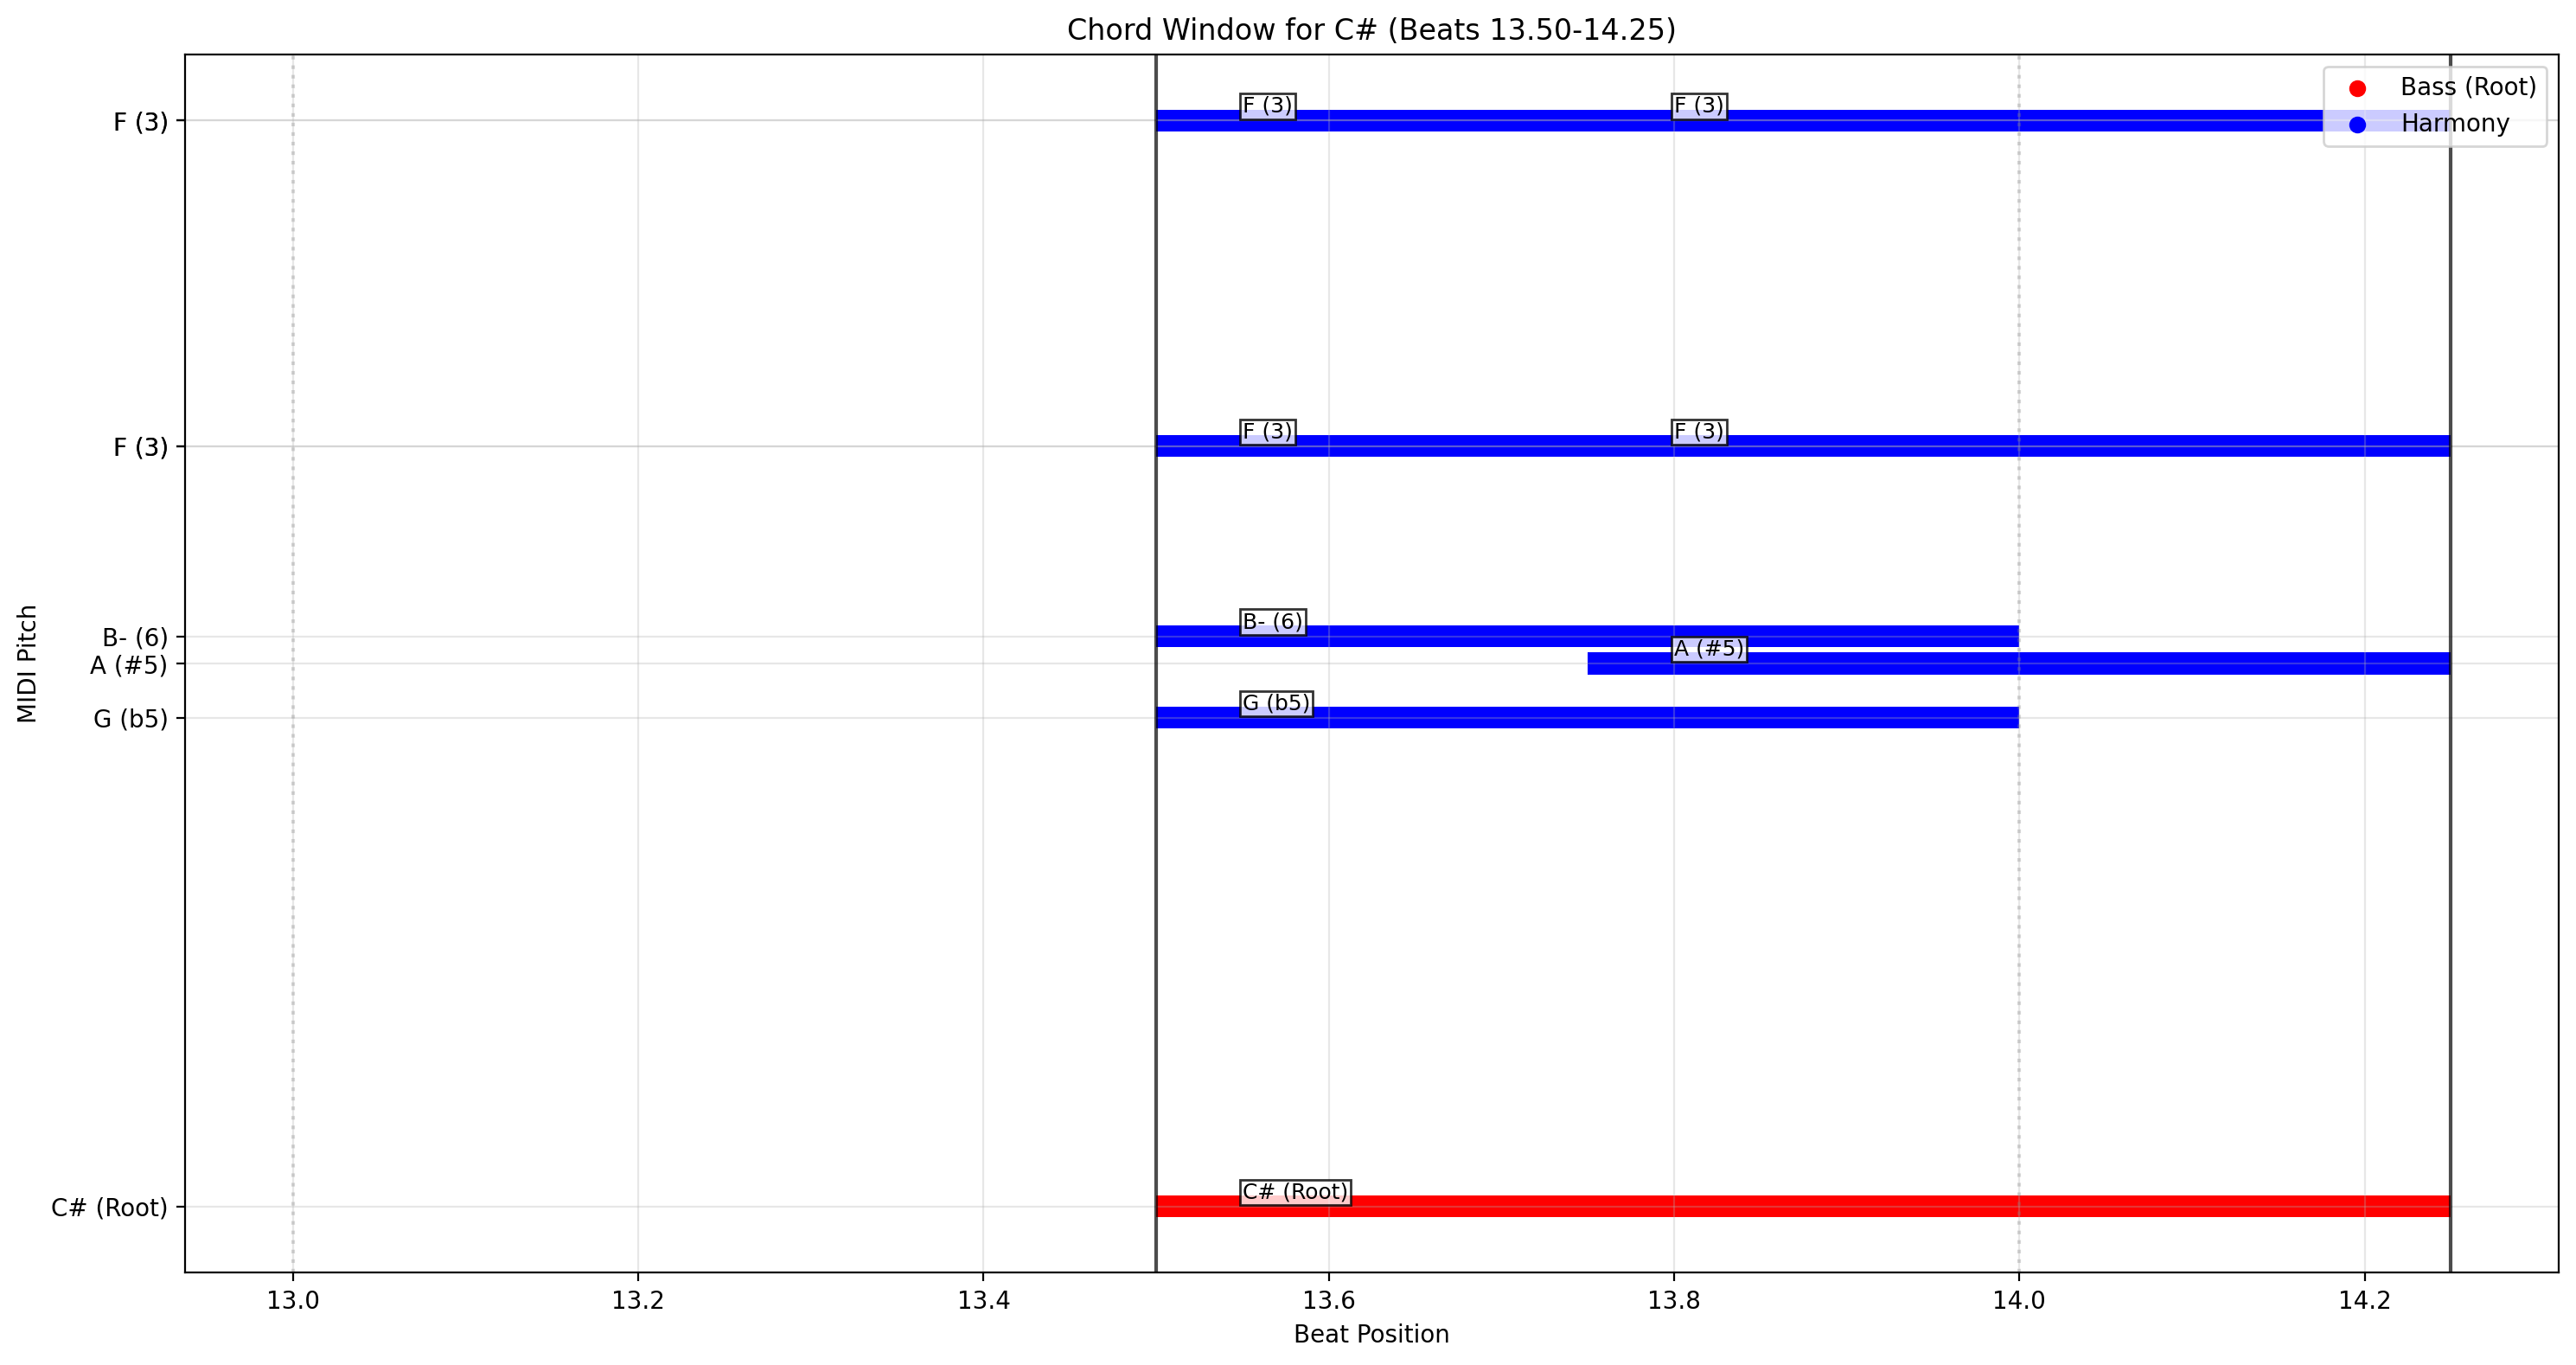


Bass note window 3: C# (13.50-14.25)
  Active harmony notes: ['G', 'B-', 'F', 'F', 'F', 'A', 'F']
  Intervals: [0, 4, 6, 8, 9]
  Identified chord: C#


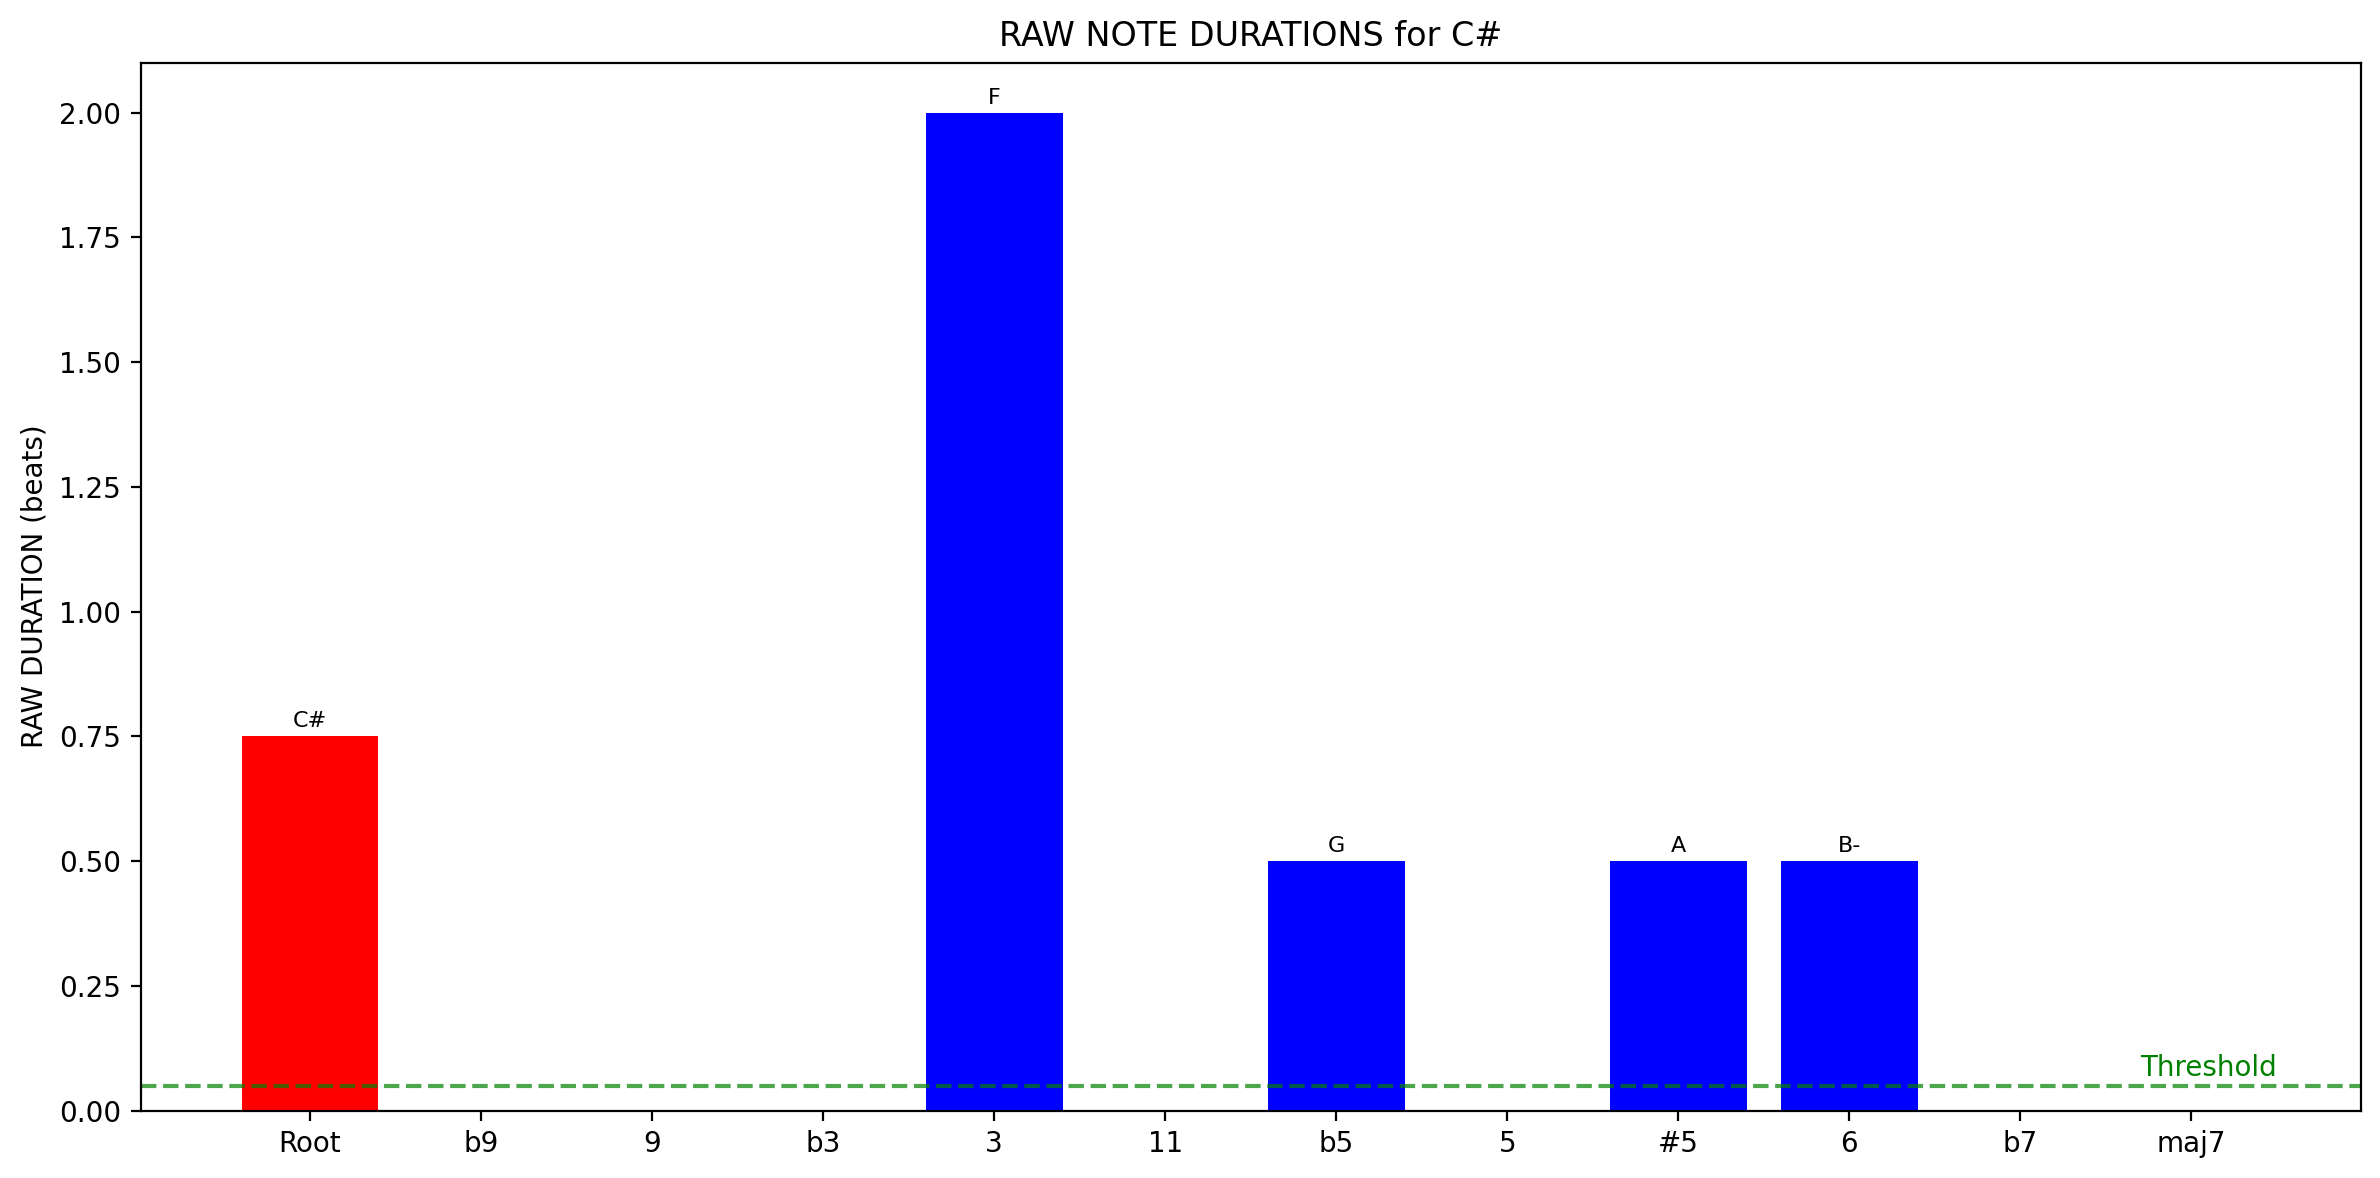


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
4        3      2.000      F
0        Root   0.750      C#
6        b5     0.500      G
8        #5     0.500      A
9        6      0.500      B-


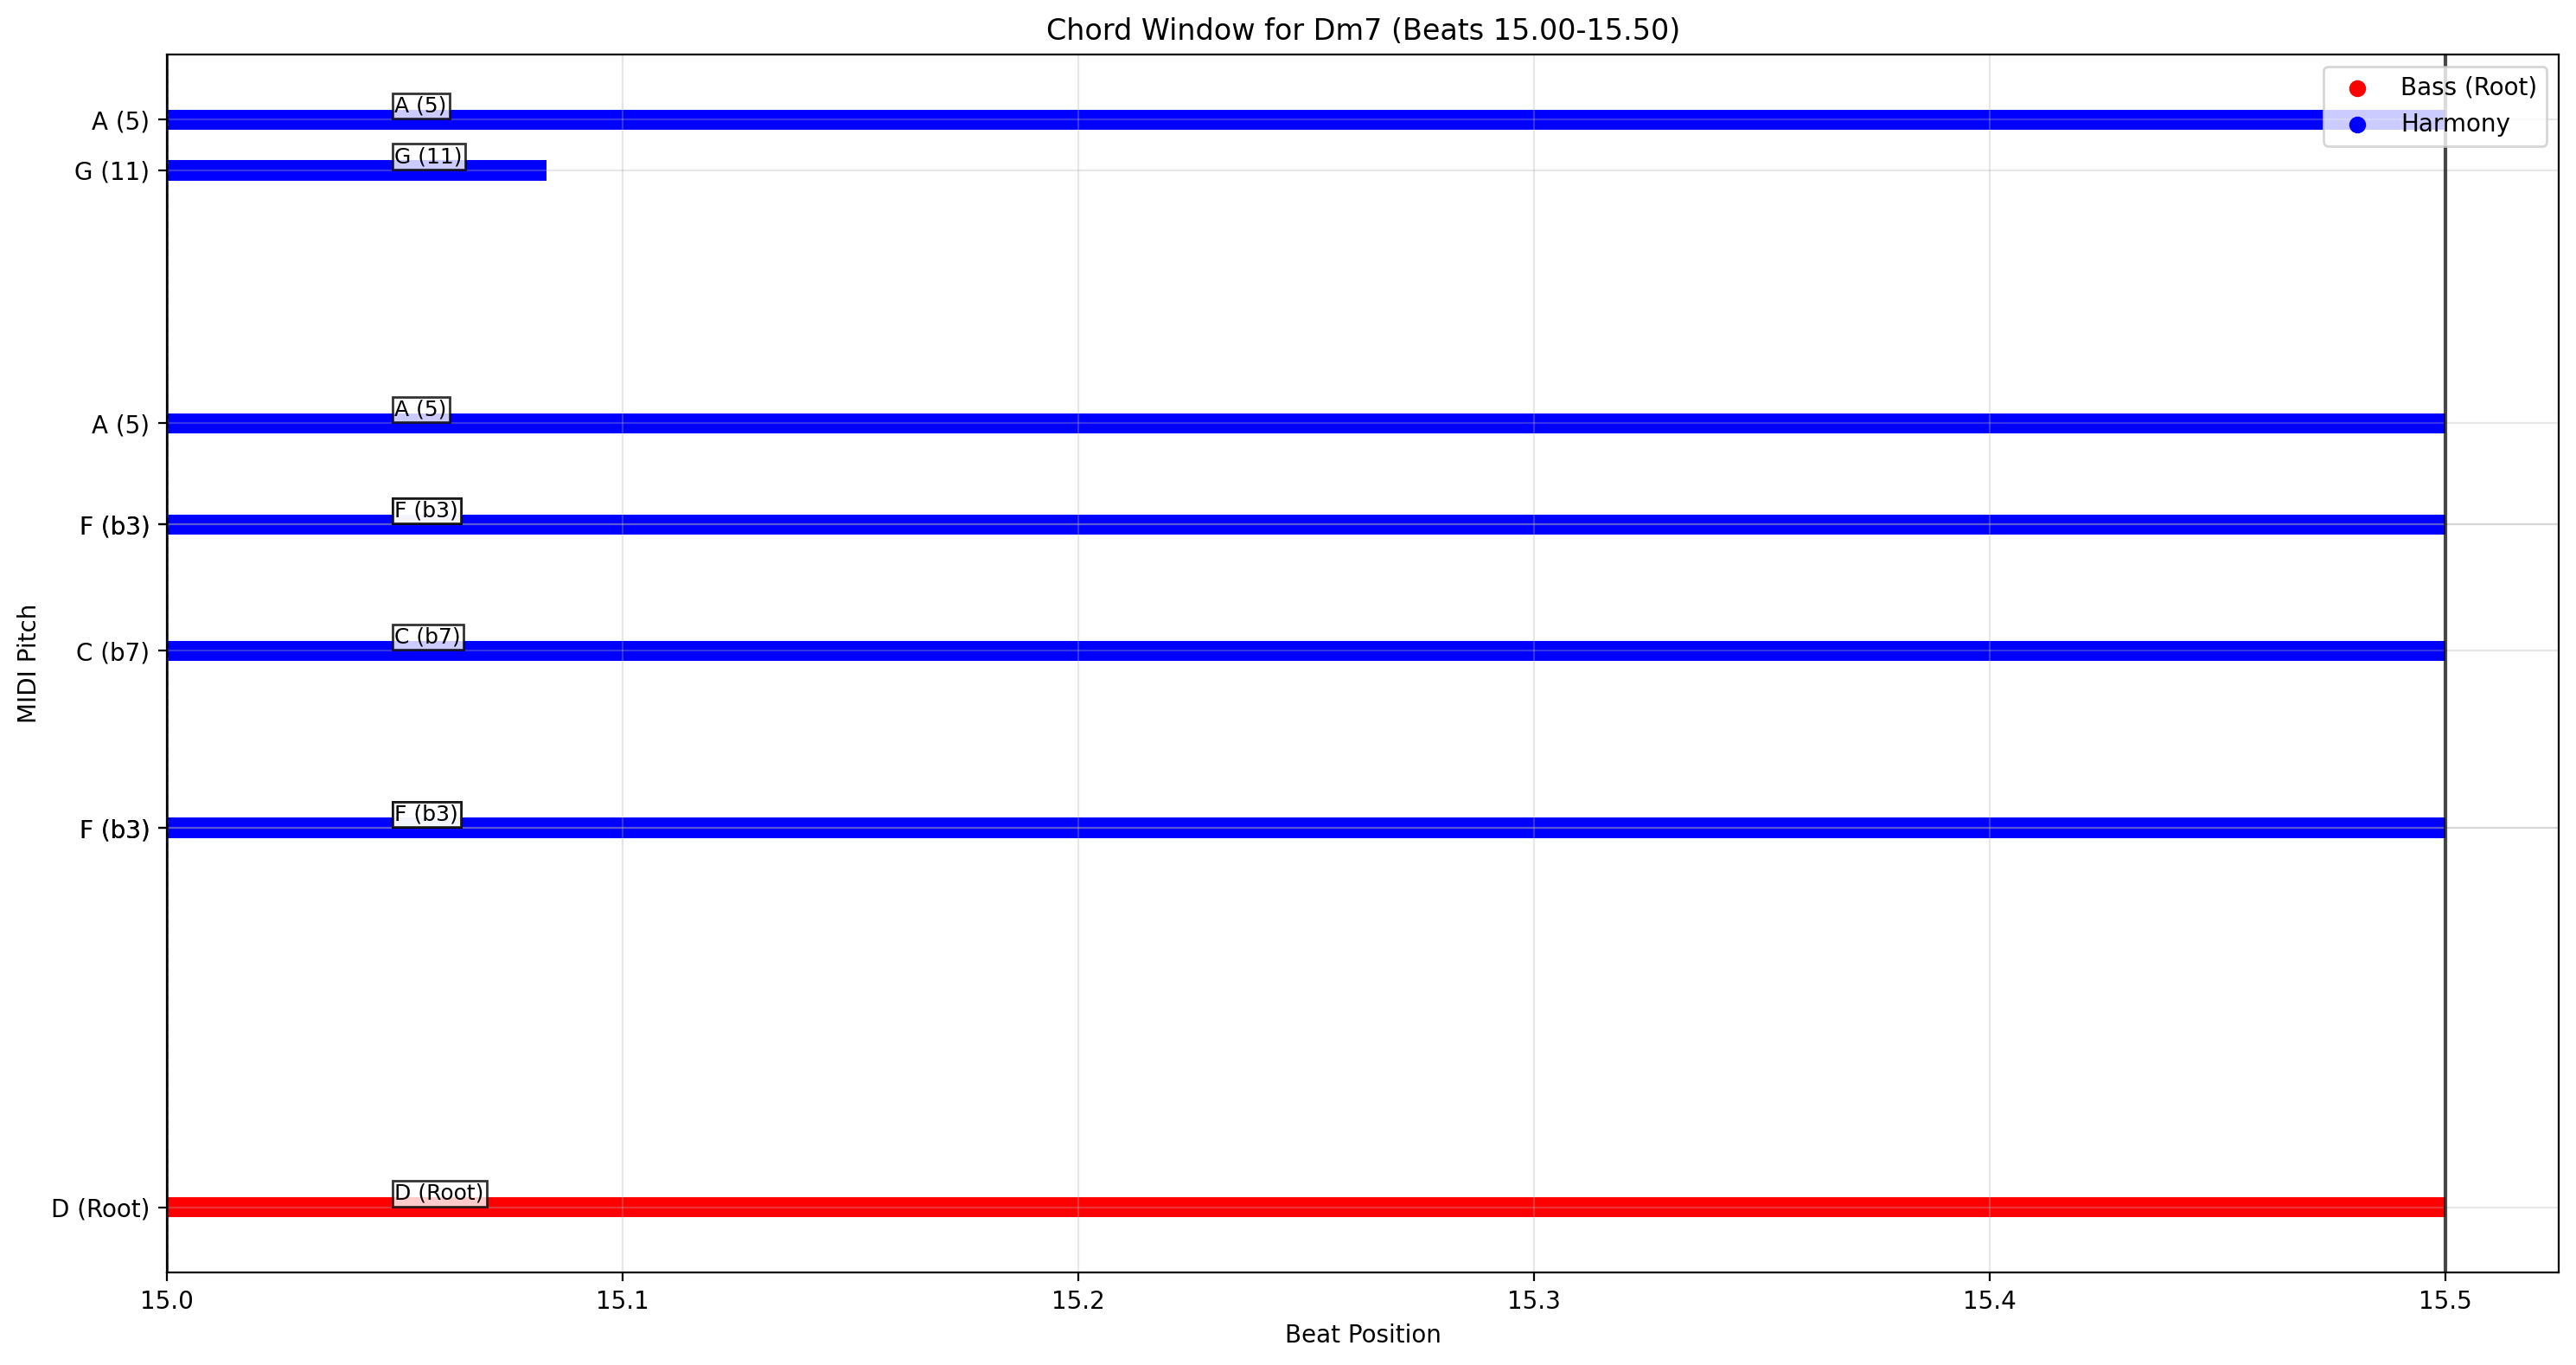


Bass note window 4: D (15.00-15.50)
  Active harmony notes: ['G', 'F', 'F', 'C', 'F', 'F', 'A', 'A']
  Intervals: [0, 3, 5, 7, 10]
  Identified chord: Dm7


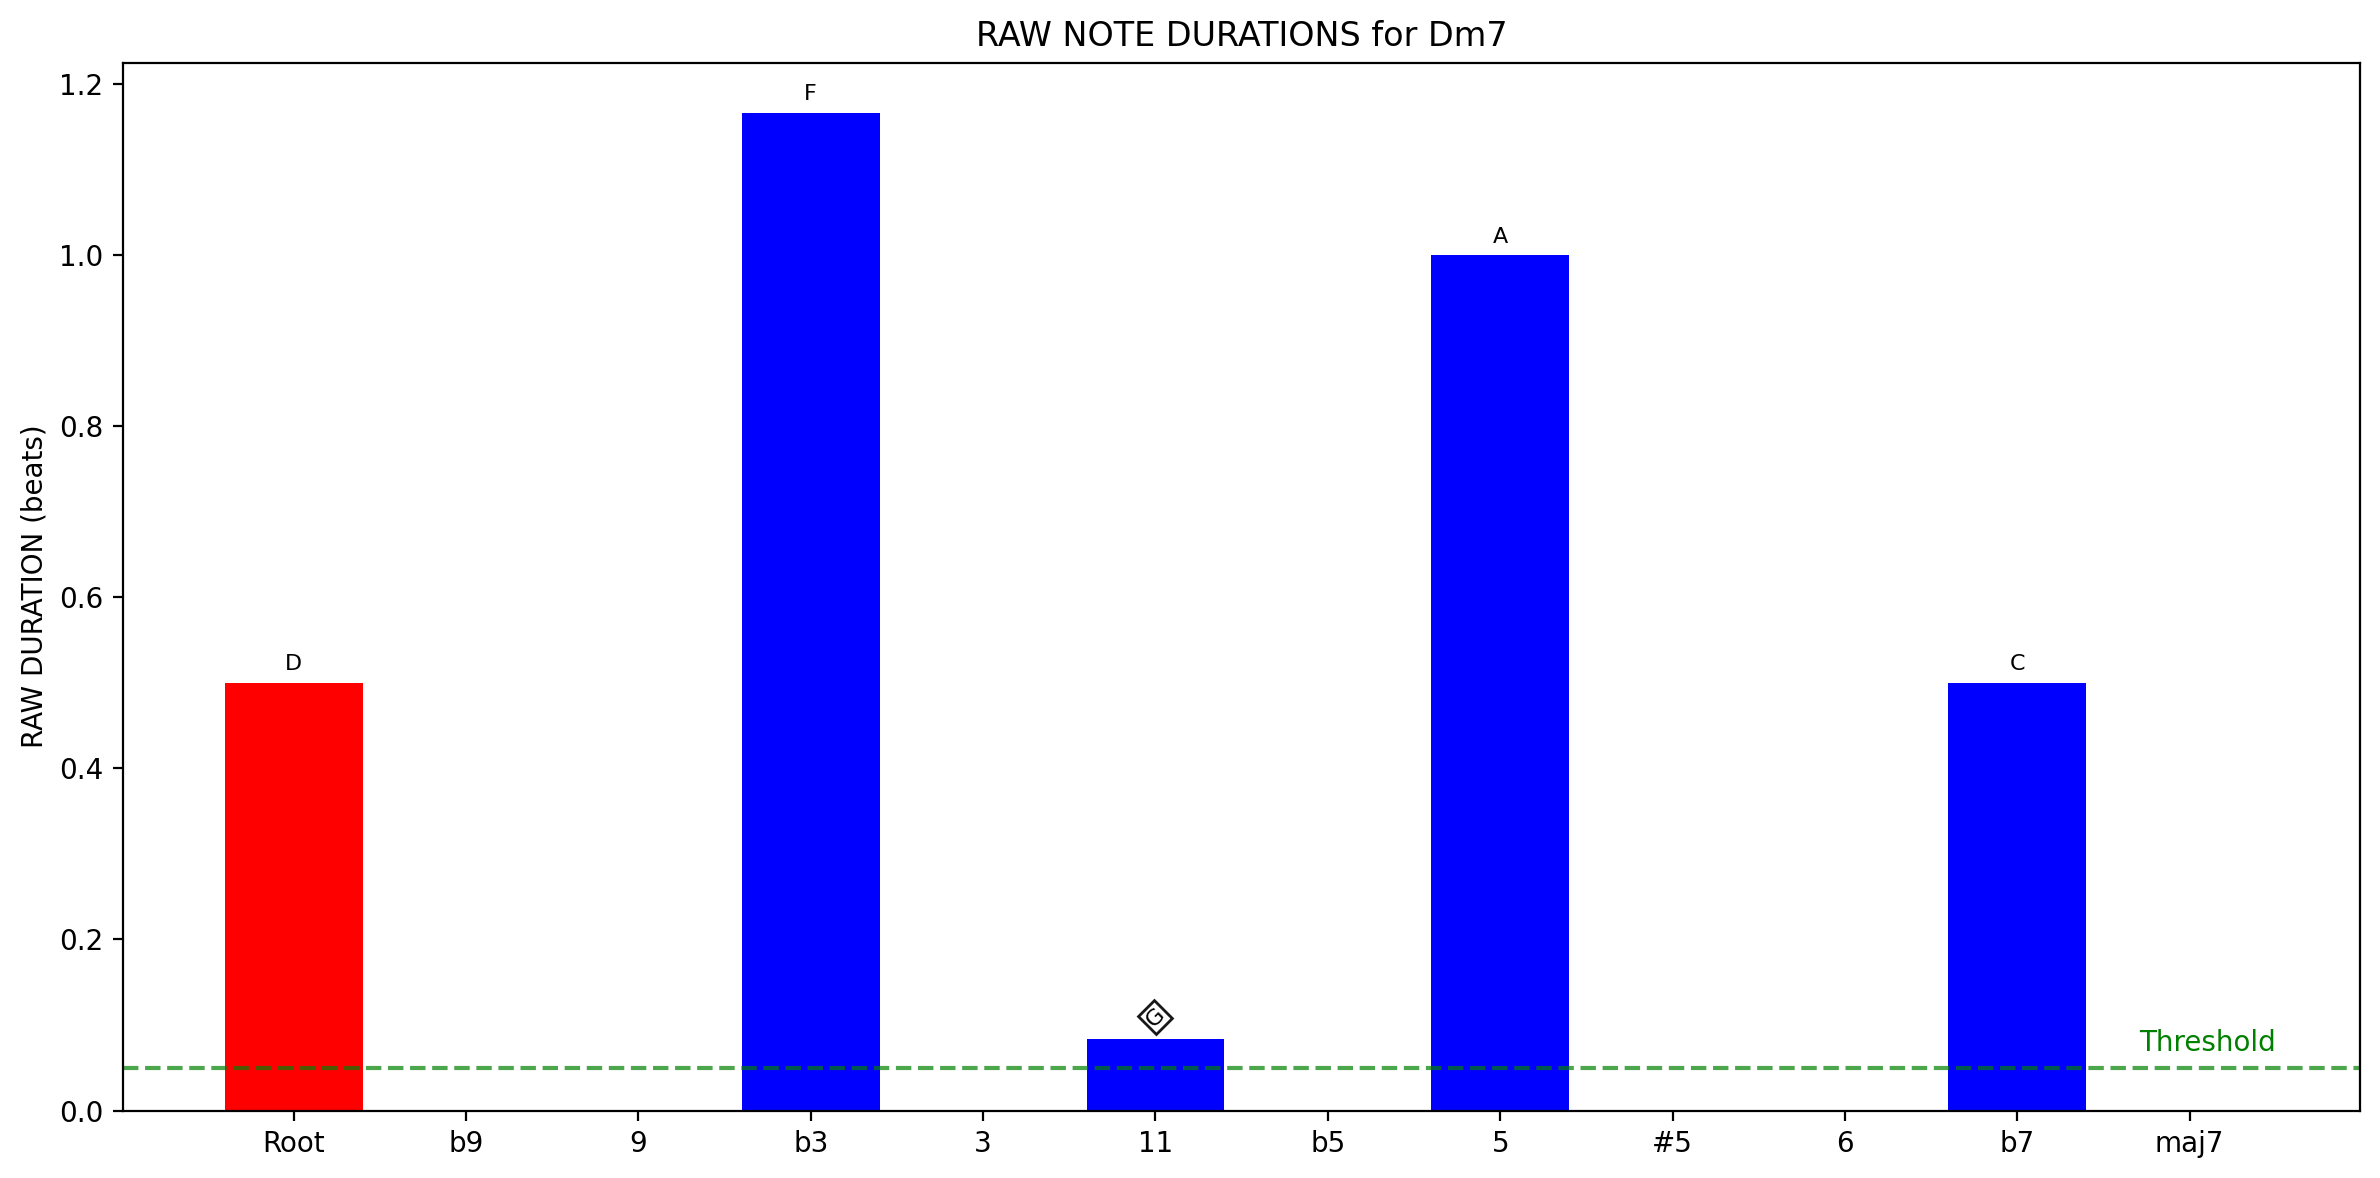


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
3        b3     1.167      F
7        5      1.000      A
0        Root   0.500      D
10       b7     0.500      C
5        11     0.083      G


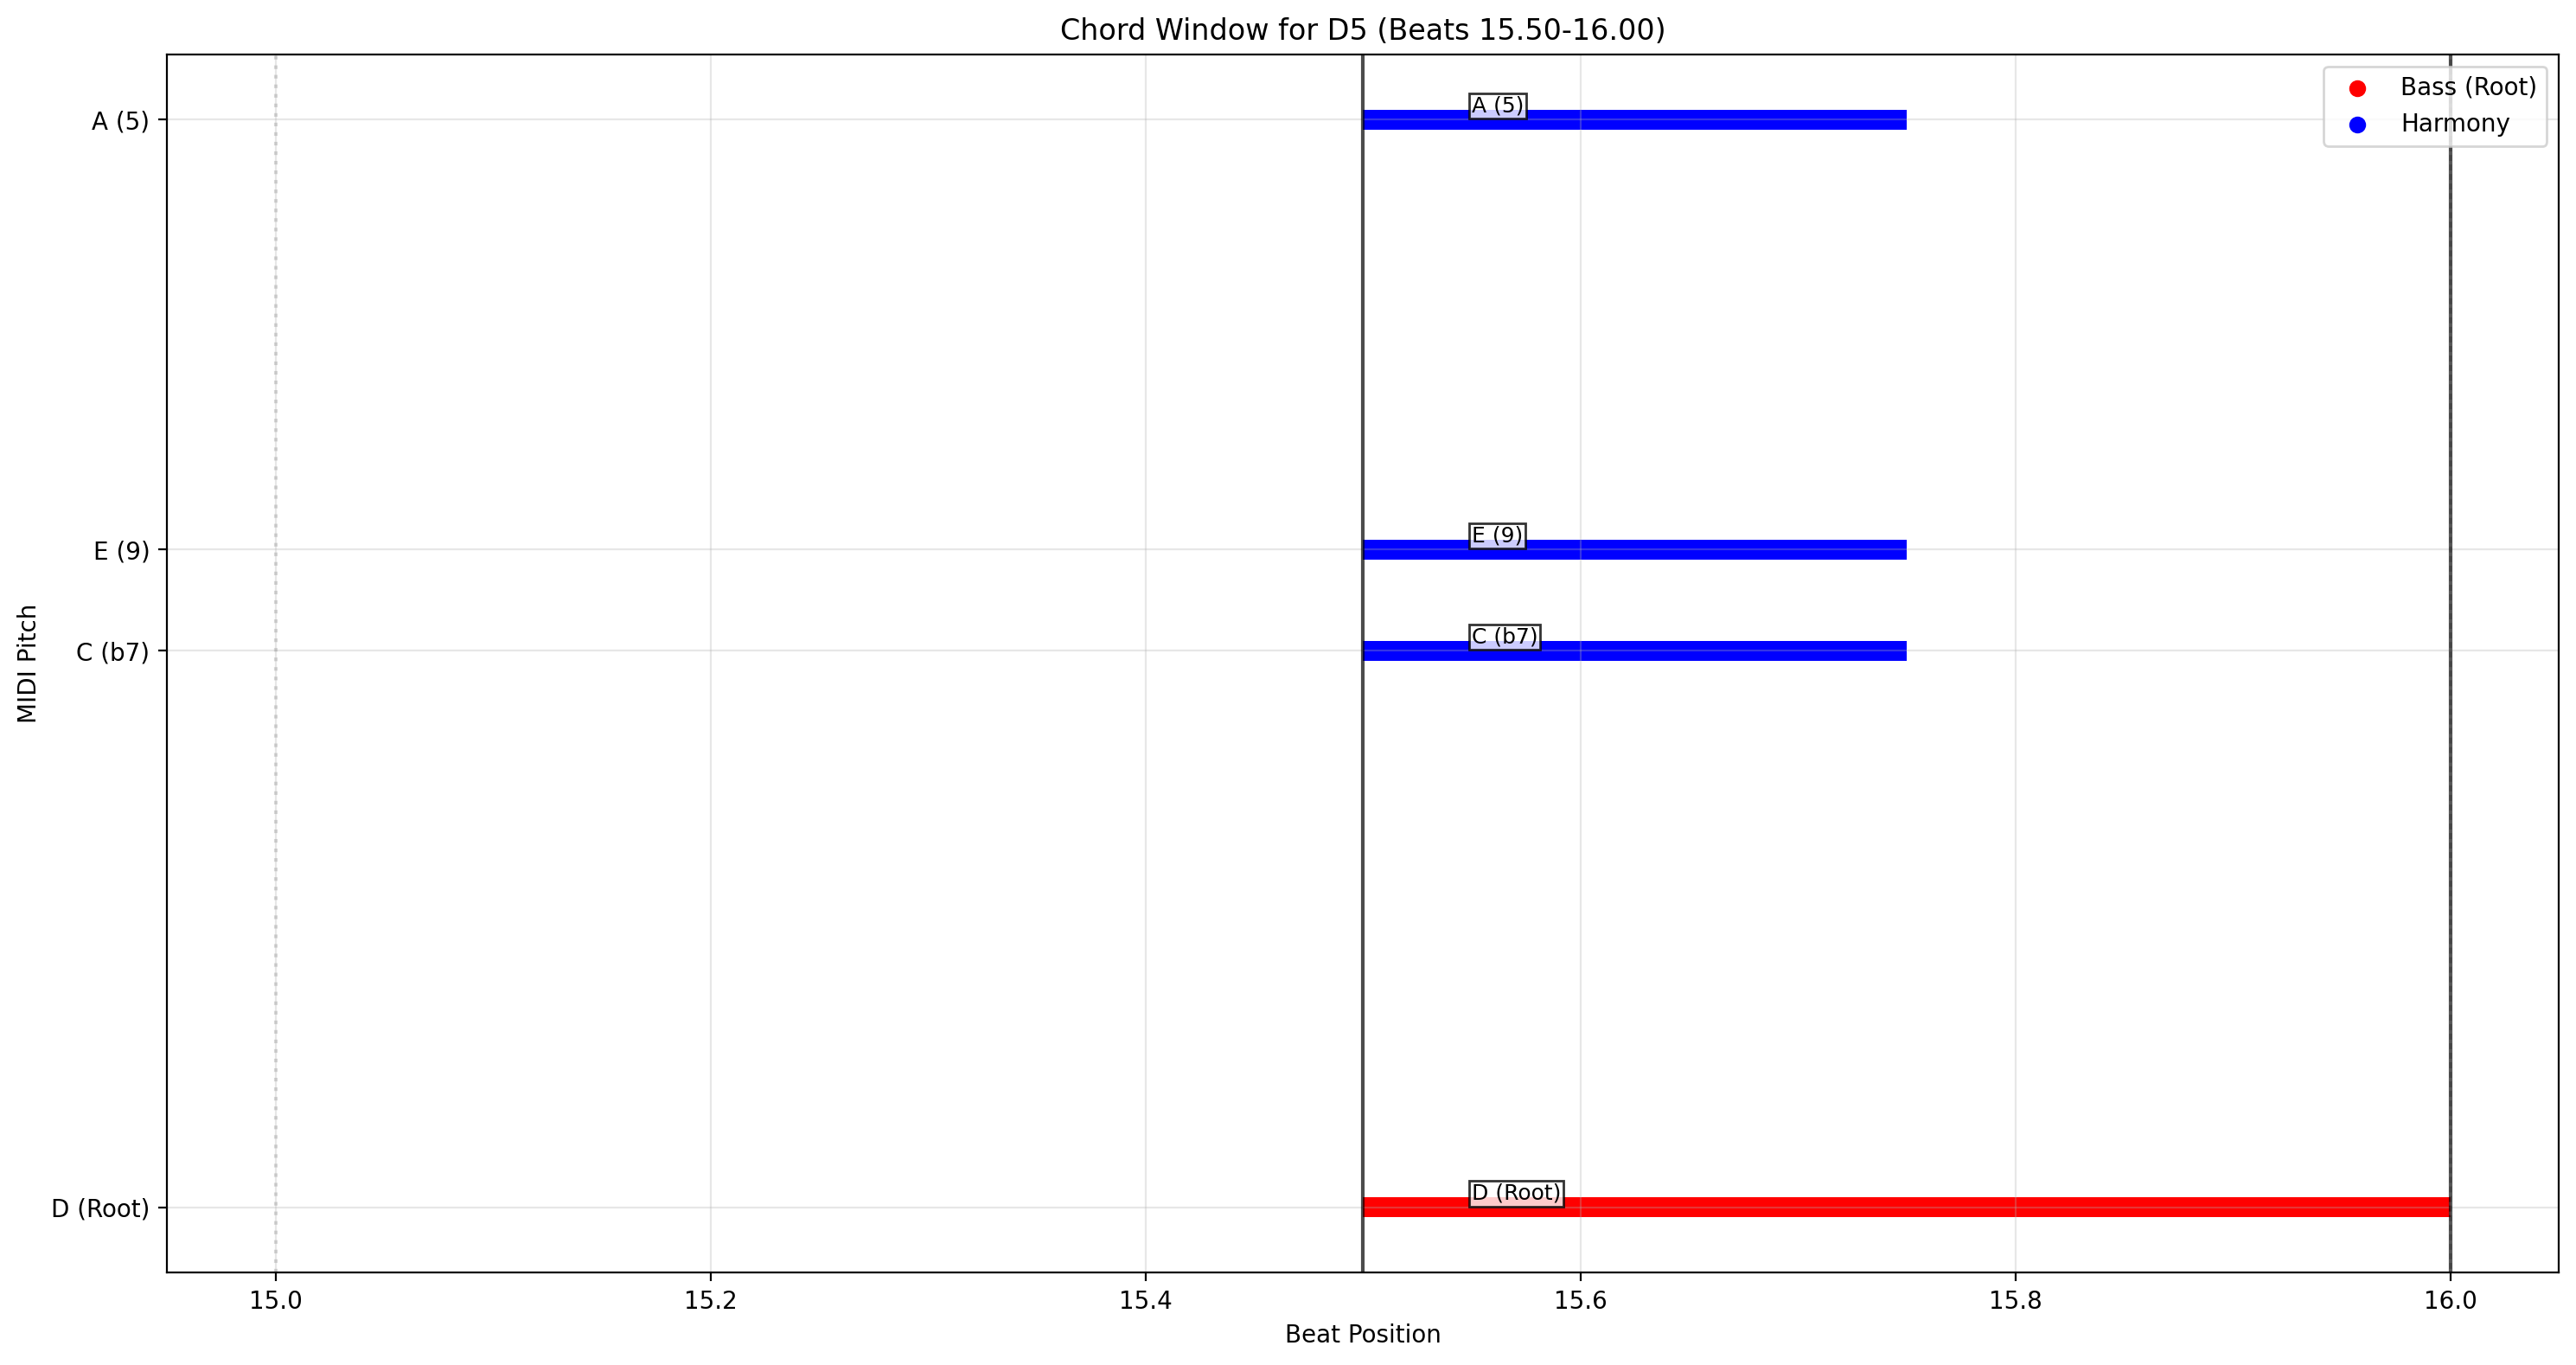


Bass note window 5: D (15.50-16.00)
  Active harmony notes: ['C', 'E', 'A']
  Intervals: [0, 2, 7, 10]
  Identified chord: D5


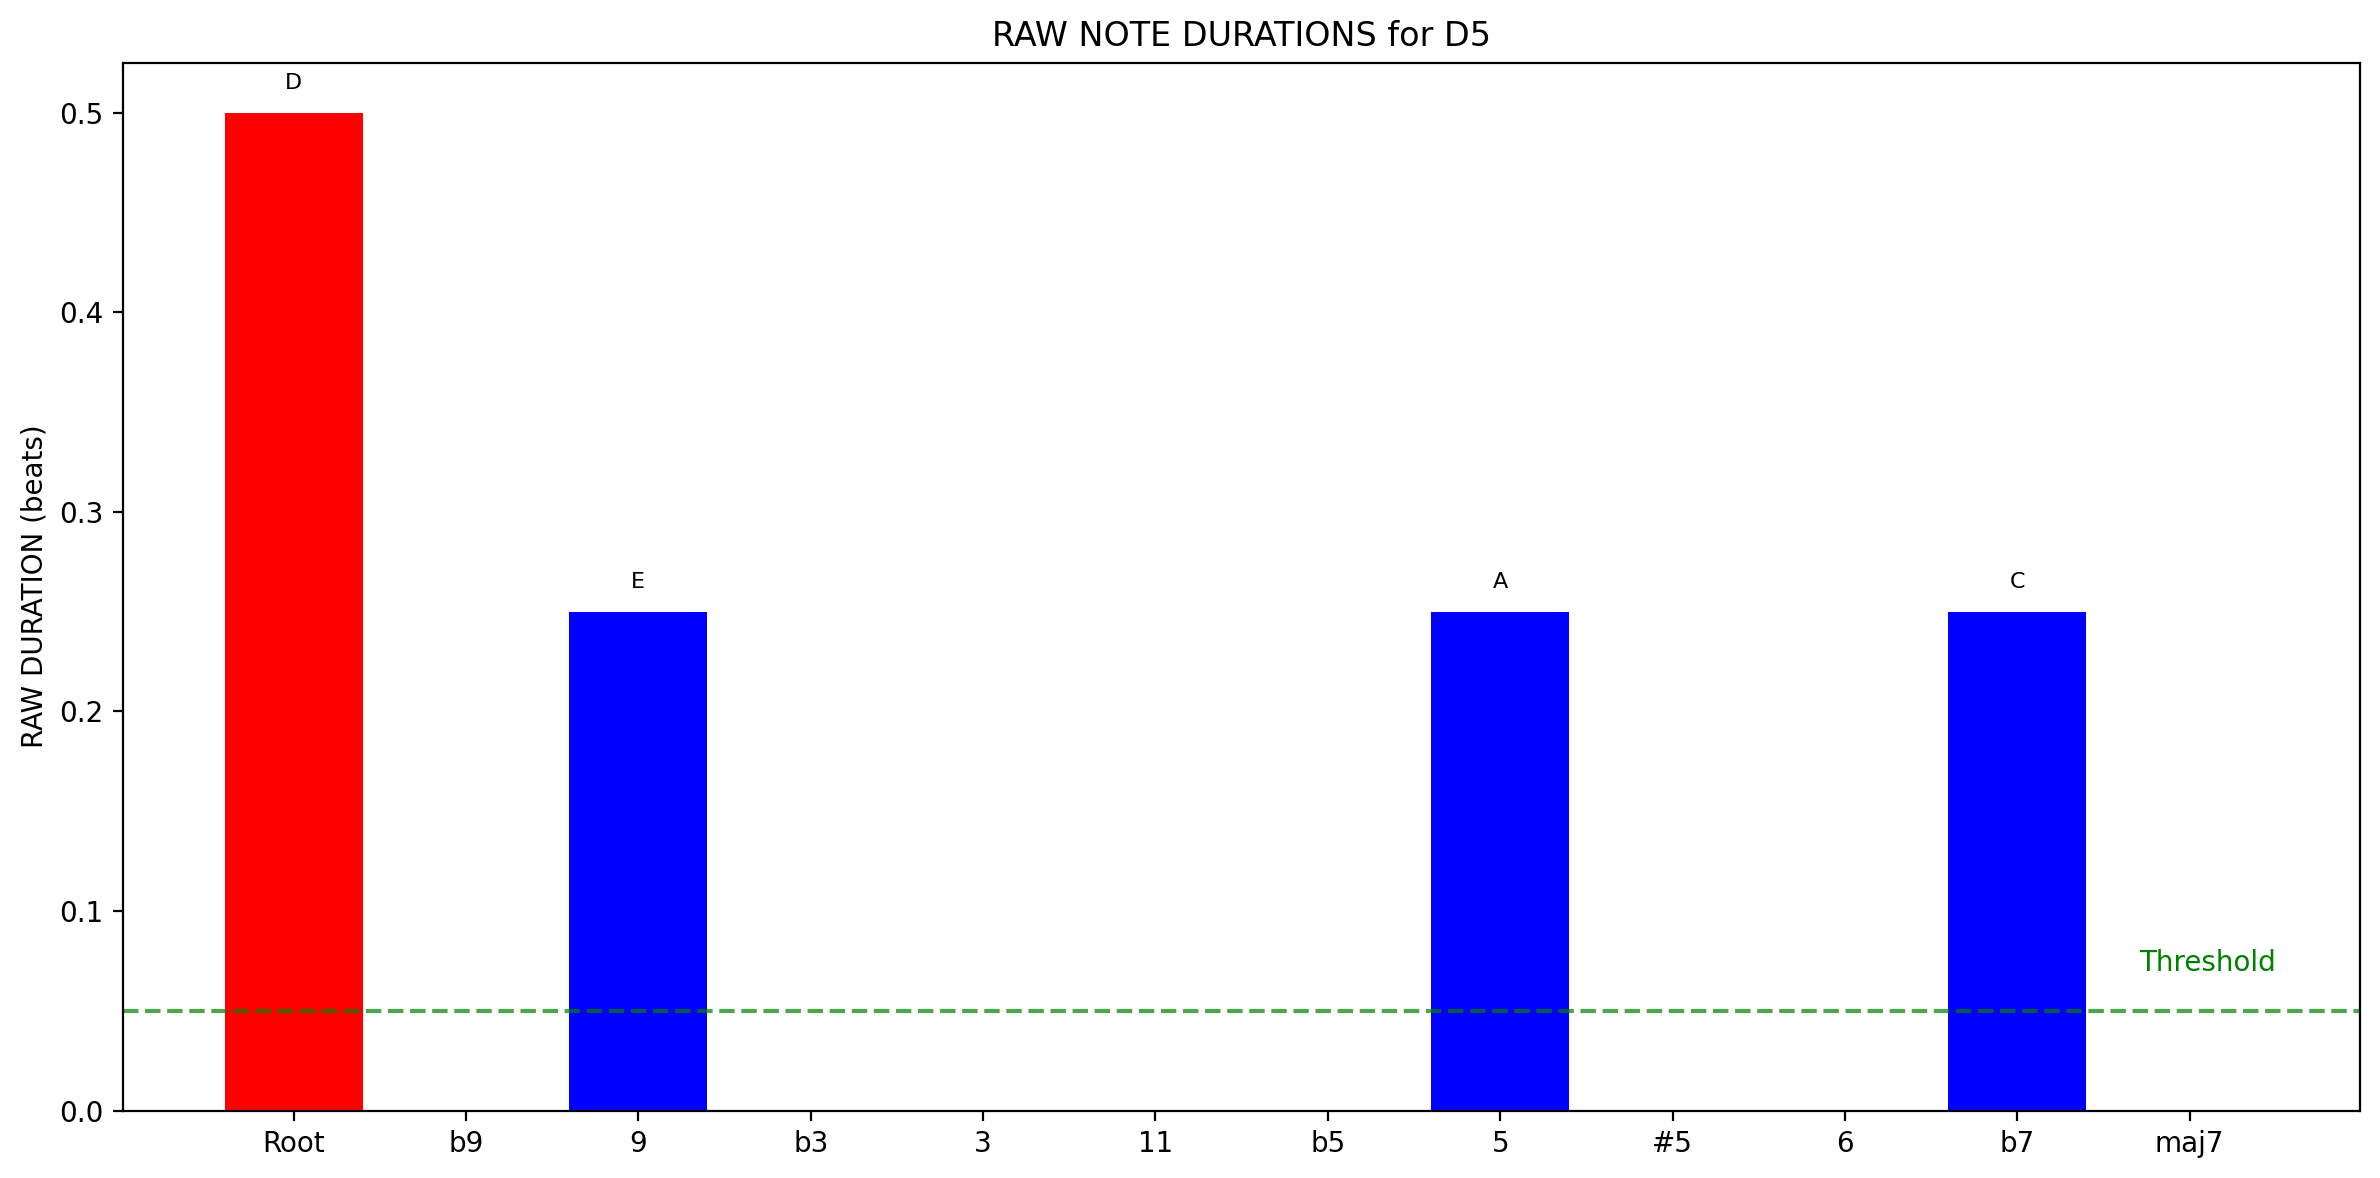


RAW DURATIONS BY INTERVAL (NO NORMALIZATION):
Interval Name   Duration   Notes
------------------------------------------------------------
0        Root   0.500      D
2        9      0.250      E
7        5      0.250      A
10       b7     0.250      C

CHORD PROGRESSION SUMMARY (TIME-WINDOWED):
Bar    Chords
------------------------------------------------------------
1      Gm9
2      C#dim → C#maj7 → D7sus4 → Dm9
3      G# → G# → Gm7 → Gdim7
4      Gdim7 → C#dim → C# → Dm7 → D5


In [ ]:
# Cell 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
import music21
from music21 import converter, chord, note, stream, pitch
from collections import Counter
import os

# Cell 2: Define chord structures with their characteristic intervals
CHORD_TYPES = {
    # Basic triads
    "": {  # Major triad
        "intervals": [0, 4, 7],
        "required": [0, 4]
    },
    "m": {  # Minor triad
        "intervals": [0, 3, 7],
        "required": [0, 3]
    },
    "dim": {  # Diminished triad
        "intervals": [0, 3, 6],
        "required": [0, 3, 6]
    },
    "aug": {  # Augmented triad
        "intervals": [0, 4, 8],
        "required": [0, 4, 8]
    },
    
    # Seventh chords
    "7": {  # Dominant seventh
        "intervals": [0, 4, 7, 10],
        "required": [0, 4, 10]
    },
    "maj7": {  # Major seventh
        "intervals": [0, 4, 7, 11],
        "required": [0, 4, 11]
    },
    "m7": {  # Minor seventh
        "intervals": [0, 3, 7, 10],
        "required": [0, 3, 10]
    },
    "dim7": {  # Diminished seventh
        "intervals": [0, 3, 6, 9],
        "required": [0, 3, 9]
    },
    "m7b5": {  # Half-diminished seventh
        "intervals": [0, 3, 6, 10],
        "required": [0, 3, 6, 10]
    },
    
    # Extended chords
    "9": {  # Dominant ninth
        "intervals": [0, 4, 7, 10, 2],
        "required": [0, 4, 10, 2]
    },
    "maj9": {  # Major ninth
        "intervals": [0, 4, 7, 11, 2],
        "required": [0, 4, 11, 2]
    },
    "m9": {  # Minor ninth
        "intervals": [0, 3, 7, 10, 2],
        "required": [0, 3, 10, 2]
    },
    
    # Altered chords
    "7b9": {  # Dominant seventh flat ninth
        "intervals": [0, 4, 7, 10, 1],
        "required": [0, 4, 10, 1]
    },
    "7#9": {  # Dominant seventh sharp ninth
        "intervals": [0, 4, 7, 10, 3],
        "required": [0, 4, 10, 3]
    },
    "7#11": {  # Dominant seventh sharp eleventh
        "intervals": [0, 4, 7, 10, 6],
        "required": [0, 4, 10, 6]
    },
    
    # Suspended chords
    "sus4": {  # Suspended fourth
        "intervals": [0, 5, 7],
        "required": [0, 5]
    },
    "7sus4": {  # Dominant seventh suspended fourth
        "intervals": [0, 5, 7, 10],
        "required": [0, 5, 10]
    }
}

# Cell 3: Define function to load MIDI notes
def load_midi_notes(midi_path, source_name="unknown"):
    """Load notes from a MIDI file with source labeling"""
    print(f"Loading MIDI file: {midi_path}")
    
    try:
        # Load MIDI file
        midi = converter.parse(midi_path)
        
        # Extract notes with pitch information
        all_notes = []
        for part in midi.parts:
            for note_obj in part.flatten().notesAndRests:
                if isinstance(note_obj, note.Note):
                    all_notes.append({
                        'start': float(note_obj.offset),
                        'end': float(note_obj.offset + note_obj.duration.quarterLength),
                        'pitch': note_obj.pitch.midi,
                        'name': note_obj.pitch.name,
                        'pitch_class': note_obj.pitch.pitchClass,
                        'velocity': note_obj.volume.velocity if hasattr(note_obj.volume, 'velocity') else 64,
                        'source': source_name
                    })
                elif isinstance(note_obj, chord.Chord):
                    for p in note_obj.pitches:
                        all_notes.append({
                            'start': float(note_obj.offset),
                            'end': float(note_obj.offset + note_obj.duration.quarterLength),
                            'pitch': p.midi,
                            'name': p.name,
                            'pitch_class': p.pitchClass,
                            'velocity': note_obj.volume.velocity if hasattr(note_obj.volume, 'velocity') else 64,
                            'source': source_name
                        })
        
        # Sort notes by start time
        all_notes.sort(key=lambda x: x['start'])
        print(f"Extracted {len(all_notes)} notes from {midi_path}")
        
        return all_notes
    
    except Exception as e:
        print(f"Error loading MIDI file {midi_path}: {e}")
        return []

# Cell 4: Function to visualize notes in a bar with enhanced display
def visualize_notes_in_bars(notes, num_bars=1, beats_per_bar=4, start_bar=0):
    """
    Visualize notes in the specified bars with enhanced display
    """
    # Calculate start and end beats
    start_beat = start_bar * beats_per_bar
    end_beat = (start_bar + num_bars) * beats_per_bar
    
    # Filter notes within the specified bars
    bar_notes = [n for n in notes if n['start'] < end_beat and n['end'] > start_beat]
    
    if not bar_notes:
        print(f"No notes found in bars {start_bar+1} to {start_bar+num_bars}")
        return
    
    # Set up the plot
    plt.figure(figsize=(15, 8))
    
    # Plot notes as rectangles
    for note_data in bar_notes:
        # Trim notes to the visible range
        start = max(note_data['start'], start_beat)
        end = min(note_data['end'], end_beat)
        
        # Determine color based on source
        color = 'blue' if note_data['source'] == 'harmony' else 'red'
        alpha = min(1.0, note_data['velocity'] / 127 + 0.3) # Adjust transparency by velocity
        
        # Plot the note
        plt.barh(
            note_data['pitch'], 
            end - start, 
            left=start, 
            height=0.8, 
            color=color, 
            alpha=alpha
        )
        
        # Add note name for longer notes
        if end - start > 0.5:
            plt.text(
                start + 0.1, 
                note_data['pitch'] + 0.3, 
                note_data['name'], 
                fontsize=8,
                color='white' if alpha > 0.6 else 'black'
            )
    
    # Add bar lines
    for bar in range(start_bar, start_bar + num_bars + 1):
        bar_pos = bar * beats_per_bar
        plt.axvline(x=bar_pos, color='black', linestyle='--', alpha=0.5)
        if bar < start_bar + num_bars:  # Add bar numbers
            plt.text(bar_pos + 0.1, plt.ylim()[1] - 3, f"Bar {bar+1}", fontsize=10)
    
    # Add beat markers
    for beat in range(int(start_beat), int(end_beat) + 1):
        plt.axvline(x=beat, color='gray', linestyle=':', alpha=0.3)
    
    # Set labels and title
    plt.xlabel('Beat Position')
    plt.ylabel('MIDI Pitch')
    plt.title(f'Notes in Bars {start_bar+1} to {start_bar+num_bars}')
    
    # Set y-axis to show note names
    yticks = range(0, 128, 12)
    ylabels = [pitch.Pitch(p).nameWithOctave for p in yticks]
    plt.yticks(yticks, ylabels)
    
    # Set x-axis ticks to show beats
    plt.xticks(range(int(start_beat), int(end_beat) + 1))
    
    # Add legend
    plt.scatter([], [], color='red', label='Bass')
    plt.scatter([], [], color='blue', label='Harmony')
    plt.legend()
    
    # Show grid and plot
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Cell 5: Improved chord identification from intervals
def identify_chord_from_intervals(intervals):
    """
    Identify chord type from intervals, with special focus on extensions
    
    Args:
        intervals: List of intervals relative to root
    
    Returns:
        String describing the chord type
    """
    # First check for diminished chords
    if 0 in intervals and 3 in intervals and 6 in intervals:
        if 9 in intervals:
            return "dim7"
        if 10 in intervals:
            return "m7b5"
        return "dim"
    
    # Check exact match for specific chord types
    for chord_type, data in CHORD_TYPES.items():
        required_intervals = data["required"]
        
        # All required intervals must be present
        if all(req in intervals for req in required_intervals):
            # For cases where multiple chord types might match, prioritize:
            # 1. Extended chords (9, 11, 13)
            # 2. Seventh chords
            # 3. Triads
            if chord_type in ["9", "maj9", "m9", "7b9", "7#9", "7#11"]:
                return chord_type
    
    # Second pass for seventh chords
    for chord_type in ["7", "maj7", "m7", "7sus4"]:
        data = CHORD_TYPES[chord_type]
        if all(req in intervals for req in data["required"]):
            return chord_type
    
    # Third pass for triads
    for chord_type in ["", "m", "aug", "sus4"]:
        data = CHORD_TYPES[chord_type]
        if all(req in intervals for req in data["required"]):
            return chord_type
    
    # If we have a bare minimum, try to find the closest match
    if 0 in intervals:
        # Check for key intervals
        has_minor_third = 3 in intervals
        has_major_third = 4 in intervals
        has_perfect_fifth = 7 in intervals
        has_diminished_fifth = 6 in intervals
        has_augmented_fifth = 8 in intervals
        has_minor_seventh = 10 in intervals
        has_major_seventh = 11 in intervals
        has_ninth = 2 in intervals
        has_flat_ninth = 1 in intervals
        
        # Identify based on key intervals
        if has_major_third:
            if has_augmented_fifth:
                return "aug"
            if has_minor_seventh and has_flat_ninth:
                return "7b9"
            if has_minor_seventh and has_ninth:
                return "9"
            if has_minor_seventh:
                return "7"
            if has_major_seventh and has_ninth:
                return "maj9"
            if has_major_seventh:
                return "maj7"
            return ""  # Major triad
        
        elif has_minor_third:
            if has_diminished_fifth and has_minor_seventh:
                return "m7b5"
            if has_diminished_fifth:
                return "dim"
            if has_minor_seventh and has_ninth:
                return "m9"
            if has_minor_seventh:
                return "m7"
            return "m"  # Minor triad
        
        elif 5 in intervals:  # No third but has fourth
            if has_minor_seventh:
                return "7sus4"
            return "sus4"
    
    # If still no match, return power chord (root + fifth) or unrecognized
    if 7 in intervals:
        return "5"  # Power chord
    
    return ""  # Unrecognized or incomplete

def get_interval_name(interval):
    """Get a readable name for an interval number"""
    interval_names = {
        0: "Root",
        1: "b9",
        2: "9",
        3: "b3",
        4: "3",
        5: "11",
        6: "b5",
        7: "5",
        8: "#5",
        9: "6",
        10: "b7",
        11: "7"
    }
    return interval_names.get(interval, f"Int{interval}")

# Cell 6: Fixed function - uses RAW WEIGHTS with NO NORMALIZATION
# Cell 6: Enhanced visualization of time windows with RAW WEIGHTS
def analyze_time_windows(notes, start_bar, beats_per_bar=4):
    """
    Analyze exactly which notes are active during each bass note's duration
    using RAW, UNNORMALIZED weights with improved visualizations
    """
    # Calculate bar boundaries
    start_beat = start_bar * beats_per_bar
    end_beat = (start_bar + 1) * beats_per_bar
    
    # Get notes in this bar
    bar_notes = [n for n in notes if n['end'] > start_beat and n['start'] < end_beat]
    
    # Separate bass and harmony
    bass_notes = [n for n in bar_notes if n['source'] == 'bass']
    harmony_notes = [n for n in bar_notes if n['source'] == 'harmony']
    
    # Sort bass notes by start time
    bass_notes.sort(key=lambda x: x['start'])
    
    # Debug print active bass notes
    print(f"\nBass notes in bar {start_bar+1}:")
    for bn in bass_notes:
        print(f"  {bn['name']} (PC {bn['pitch_class']}): {bn['start']:.2f}-{bn['end']:.2f}")
    
    # 1. FIRST VISUALIZATION: Show all notes in the bar with chord windows highlighted
    plt.figure(figsize=(15, 8))
    
    # Plot all notes as rectangles
    for note_data in bar_notes:
        # Trim notes to the visible range
        start = max(note_data['start'], start_beat)
        end = min(note_data['end'], end_beat)
        
        # Determine color based on source
        color = 'blue' if note_data['source'] == 'harmony' else 'red'
        alpha = min(1.0, note_data['velocity'] / 127 + 0.3) # Adjust transparency by velocity
        
        # Plot the note
        plt.barh(
            note_data['pitch'], 
            end - start, 
            left=start, 
            height=0.8, 
            color=color, 
            alpha=alpha
        )
        
        # Add note name for all notes - improved visibility
        plt.text(
            start + 0.05, 
            note_data['pitch'] + 0.3, 
            note_data['name'], 
            fontsize=8,
            color='black',
            bbox=dict(facecolor='white', alpha=0.7, pad=1)
        )
    
    # Highlight the bass note time windows
    for bn in bass_notes:
        window_start = max(bn['start'], start_beat)
        window_end = min(bn['end'], end_beat)
        
        # Draw a semi-transparent rectangle covering the window
        plt.axvspan(window_start, window_end, alpha=0.2, color='yellow')
        
        # Add chord name at the top
        chord_name = f"{bn['name']} chord window"
        plt.text(
            window_start + (window_end - window_start)/2, 
            plt.ylim()[1] - 2,
            chord_name,
            ha='center',
            fontsize=9,
            bbox=dict(facecolor='yellow', alpha=0.5, pad=2)
        )
    
    # Add bar lines
    bar_pos = start_bar * beats_per_bar
    plt.axvline(x=bar_pos, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=end_beat, color='black', linestyle='--', alpha=0.5)
    plt.text(bar_pos + 0.1, plt.ylim()[1] - 3, f"Bar {start_bar+1}", fontsize=10)
    
    # Add beat markers
    for beat in range(int(start_beat), int(end_beat) + 1):
        plt.axvline(x=beat, color='gray', linestyle=':', alpha=0.3)
    
    # Set labels and title
    plt.xlabel('Beat Position')
    plt.ylabel('MIDI Pitch')
    plt.title(f'Notes in Bar {start_bar+1} with Chord Windows Highlighted')
    
    # Set y-axis to show note names
    yticks = range(0, 128, 12)
    ylabels = [pitch.Pitch(p).nameWithOctave for p in yticks]
    plt.yticks(yticks, ylabels)
    
    # Set x-axis ticks to show beats
    plt.xticks(range(int(start_beat), int(end_beat) + 1))
    
    # Add legend
    plt.scatter([], [], color='red', label='Bass')
    plt.scatter([], [], color='blue', label='Harmony')
    plt.scatter([], [], color='yellow', alpha=0.5, s=100, label='Chord Window')
    plt.legend(loc='upper right')
    
    # Show grid and plot
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create a list to store results
    chord_windows = []
    
    # 2. ANALYZE EACH BASS NOTE TIME WINDOW
    for i, bass_note in enumerate(bass_notes):
        # Define precise time window
        window_start = max(bass_note['start'], start_beat)
        window_end = min(bass_note['end'], end_beat)
        root_pc = bass_note['pitch_class']
        
        # Find exactly which harmony notes are active during this window
        active_harmony = []
        for hn in harmony_notes:
            # Note must overlap with the current bass note's time window
            if hn['start'] < window_end and hn['end'] > window_start:
                overlap_start = max(window_start, hn['start'])
                overlap_end = min(window_end, hn['end'])
                overlap_duration = overlap_end - overlap_start
                
                active_harmony.append({
                    'name': hn['name'],
                    'pitch': hn['pitch'],
                    'pitch_class': hn['pitch_class'],
                    'duration': overlap_duration,
                    'interval': (hn['pitch_class'] - root_pc) % 12
                })
        
        # Calculate RAW duration for each interval
        interval_durations = {}
        interval_notes = {}
        for interval in range(12):
            # Root (interval 0) gets duration of bass note
            if interval == 0:
                interval_durations[interval] = window_end - window_start
                interval_notes[interval] = [bass_note['name']]
                continue
                
            # Other intervals get sum of all harmony note durations with that interval
            matching_notes = [n for n in active_harmony if n['interval'] == interval]
            if matching_notes:
                interval_durations[interval] = sum(n['duration'] for n in matching_notes)
                interval_notes[interval] = sorted(set(n['name'] for n in matching_notes))
        
        # Calculate intervals present for chord identification
        # Include even very small durations
        intervals_present = sorted(interval_durations.keys())
        
        # Identify chord
        chord_type = identify_chord_from_intervals(intervals_present)
        chord_name = f"{bass_note['name']}{chord_type}"
        
        # Store the result
        chord_windows.append({
            'start': window_start,
            'end': window_end,
            'duration': window_end - window_start,
            'root_pc': root_pc,
            'root_name': bass_note['name'],
            'intervals': intervals_present,
            'interval_durations': interval_durations,
            'chord_type': chord_type,
            'chord_name': chord_name,
            'active_notes': [hn['name'] for hn in active_harmony]
        })
        
        # 3. VISUALIZATION: Show notes specifically in this chord window
        plt.figure(figsize=(15, 8))
        
        # Only show notes active during this window
        window_notes = [bass_note] + [n for n in harmony_notes 
                                    if n['start'] < window_end and n['end'] > window_start]
        window_notes.sort(key=lambda x: x['pitch'])
        
        for note_data in window_notes:
            # Trim notes to the visible range
            start = max(note_data['start'], window_start)
            end = min(note_data['end'], window_end)
            
            # Determine color based on source
            color = 'blue' if note_data['source'] == 'harmony' else 'red'
            
            # Plot the note
            plt.barh(
                note_data['pitch'], 
                end - start, 
                left=start, 
                height=0.8, 
                color=color
            )
            
            # Add note name and interval for all notes
            interval = (note_data['pitch_class'] - root_pc) % 12
            interval_name = get_interval_name(interval)
            
            # More visible labels with white background
            plt.text(
                start + 0.05, 
                note_data['pitch'] + 0.3, 
                f"{note_data['name']} ({interval_name})", 
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8, pad=1)
            )
        
        # Add window boundaries
        plt.axvline(x=window_start, color='black', linestyle='-', alpha=0.7)
        plt.axvline(x=window_end, color='black', linestyle='-', alpha=0.7)
        
        # Add beat markers
        for beat in range(int(window_start), int(window_end) + 1):
            plt.axvline(x=beat, color='gray', linestyle=':', alpha=0.3)
        
        # Set labels and title
        plt.xlabel('Beat Position')
        plt.ylabel('MIDI Pitch')
        plt.title(f'Chord Window for {chord_name} (Beats {window_start:.2f}-{window_end:.2f})')
        
        # Set y-axis to show note names
        yticks = [n['pitch'] for n in window_notes]
        ylabels = [f"{n['name']} ({get_interval_name((n['pitch_class']-root_pc)%12)})" for n in window_notes]
        plt.yticks(yticks, ylabels)
        
        # Add legend
        plt.scatter([], [], color='red', label='Bass (Root)')
        plt.scatter([], [], color='blue', label='Harmony')
        plt.legend(loc='upper right')
        
        # Show grid and plot
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print the result for this time window
        print(f"\nBass note window {i+1}: {bass_note['name']} ({window_start:.2f}-{window_end:.2f})")
        print(f"  Active harmony notes: {[n['name'] for n in active_harmony]}")
        print(f"  Intervals: {intervals_present}")
        print(f"  Identified chord: {chord_name}")
        
        # 4. VISUALIZE RAW DURATIONS FOR ALL INTERVALS
        plt.figure(figsize=(12, 6))
        
        # Show RAW durations for all 12 intervals - include very small values
        interval_names = ["Root", "b9", "9", "b3", "3", "11", "b5", "5", "#5", "6", "b7", "maj7"]
        
        # Get RAW durations for all intervals (0 if not present)
        raw_durations = [interval_durations.get(i, 0) for i in range(12)]
        
        # Create colors (all intervals are colored for visibility)
        colors = ['lightgray'] * 12
        for i in range(12):
            if i in intervals_present:
                colors[i] = 'red' if i == 0 else 'blue'
        
        # Create the chart with ACTUAL RAW DURATIONS - NO NORMALIZATION
        bars = plt.bar(interval_names, raw_durations, color=colors)
        
        # Add a threshold line to show what's considered "significant"
        threshold = 0.05  # 0.05 beats (very small but still visible)
        plt.axhline(y=threshold, color='green', linestyle='--', alpha=0.7)
        plt.text(11.5, threshold + 0.02, "Threshold", color='green', ha='right')
        
        plt.ylabel('RAW DURATION (beats)')
        plt.title(f"RAW NOTE DURATIONS for {chord_name}")
        
        # Annotate ALL intervals with notes (including small values)
        for i in range(12):
            if i in interval_notes:
                note_str = ", ".join(interval_notes[i])
                
                # Make small values more visible by using text boxes
                if raw_durations[i] < threshold * 3:
                    plt.text(
                        i, 
                        raw_durations[i] + 0.01, 
                        note_str, 
                        ha='center', 
                        va='bottom',
                        fontsize=8,
                        bbox=dict(facecolor='white', alpha=0.9, pad=1),
                        rotation=45
                    )
                else:
                    plt.text(
                        i, 
                        raw_durations[i] + 0.01, 
                        note_str, 
                        ha='center', 
                        va='bottom',
                        fontsize=8
                    )
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed raw duration breakdown
        print("\nRAW DURATIONS BY INTERVAL (NO NORMALIZATION):")
        print(f"{'Interval':<8} {'Name':<6} {'Duration':<10} {'Notes'}")
        print("-" * 60)
        
        # Sort by duration (largest first) to see most important intervals
        sorted_intervals = sorted(
            [(i, interval_durations.get(i, 0)) for i in range(12)],
            key=lambda x: x[1],
            reverse=True
        )
        
        for interval, duration in sorted_intervals:
            if duration > 0 or interval in intervals_present:
                notes_str = ", ".join(interval_notes.get(interval, []))
                print(f"{interval:<8} {interval_names[interval]:<6} {duration:<10.3f} {notes_str}")
    
    # Return the list of chord windows
    return chord_windows

# Cell 7: Function to analyze a progression with time windows
def analyze_progression_with_time_windows(notes, start_bar, num_bars=4, beats_per_bar=4):
    """
    Analyze a progression of bars using time-sensitive chord recognition
    """
    # Visualize the entire section first
    visualize_notes_in_bars(notes, num_bars=num_bars, start_bar=start_bar, beats_per_bar=beats_per_bar)
    
    # Analyze each bar individually
    all_results = []
    for bar_idx in range(start_bar, start_bar + num_bars):
        print(f"\n=== Analyzing Bar {bar_idx+1} with Time Windows ===")
        bar_results = analyze_time_windows(notes, bar_idx, beats_per_bar=beats_per_bar)
        all_results.append(bar_results)
    
    # Summarize the progression
    print("\n" + "=" * 60)
    print("CHORD PROGRESSION SUMMARY (TIME-WINDOWED):")
    print("=" * 60)
    print(f"{'Bar':<6} {'Chords'}")
    print("-" * 60)
    
    for i, bar_results in enumerate(all_results):
        if bar_results:
            bar_num = start_bar + i + 1
            chord_names = [window['chord_name'] for window in bar_results]
            print(f"{bar_num:<6} {' → '.join(chord_names)}")
    
    print("=" * 60)
    
    return all_results

# Cell 8: Load your MIDI files and combine the notes
# Set the paths to your MIDI files - modify these as needed
bass_midi_path = "/workspace/src/chord_analysis/bass_extracted.mid"
harmony_midi_path = "/workspace/src/chord_analysis/harmony_extracted.mid"

# Check if files exist, otherwise try alternative paths
if not os.path.exists(bass_midi_path):
    alternative_path = "/workspace/src/midi_files/bass.mid"
    if os.path.exists(alternative_path):
        bass_midi_path = alternative_path
        print(f"Using alternative bass MIDI path: {bass_midi_path}")
    else:
        print(f"Warning: Could not find bass MIDI file at expected locations")

if not os.path.exists(harmony_midi_path):
    alternative_path = "/workspace/src/midi_files/harmony.mid"
    if os.path.exists(alternative_path):
        harmony_midi_path = alternative_path
        print(f"Using alternative harmony MIDI path: {harmony_midi_path}")
    else:
        print(f"Warning: Could not find harmony MIDI file at expected locations")

def identify_precise_chord(intervals):
    """
    Identify a SINGLE, PRECISE chord type based on strict interval matching
    
    Args:
        intervals (list): List of interval classes present
    
    Returns:
        str: A single, unambiguous chord type or empty string
    """
    # Prioritize most specific chord types first
    chord_hierarchy = [
        # Extended and altered chords (most specific)
        ("dim7", [0, 3, 6, 9]),     # Fully diminished seventh
        ("m7b5", [0, 3, 6, 10]),    # Half-diminished seventh
        ("7b9", [0, 4, 7, 10, 1]),  # Dominant seventh flat ninth
        ("7#9", [0, 4, 7, 10, 3]),  # Dominant seventh sharp ninth
        ("9", [0, 4, 7, 10, 2]),    # Dominant ninth
        ("m9", [0, 3, 7, 10, 2]),   # Minor ninth
        ("maj9", [0, 4, 7, 11, 2]), # Major ninth
        
        # Seventh chords
        ("dim", [0, 3, 6]),         # Diminished triad
        ("m7", [0, 3, 7, 10]),      # Minor seventh
        ("7", [0, 4, 7, 10]),       # Dominant seventh
        ("maj7", [0, 4, 7, 11]),    # Major seventh
        
        # Suspended chords
        ("7sus4", [0, 5, 7, 10]),   # Dominant seventh suspended
        ("sus4", [0, 5, 7]),        # Suspended fourth
        
        # Basic triads
        ("aug", [0, 4, 8]),         # Augmented triad
        ("m", [0, 3, 7]),           # Minor triad
        ("", [0, 4, 7])             # Major triad
    ]
    
    # Convert intervals to a set for efficient checking
    interval_set = set(intervals)
    
    # Find the first chord type that matches all its required intervals
    for chord_type, required_intervals in chord_hierarchy:
        if all(interval in interval_set for interval in required_intervals):
            return chord_type
    
    # If no match found, return an empty string
    return ""

def identify_precise_chord(intervals):
    """
    Identify a SINGLE, PRECISE chord type based on strict interval matching
    
    Args:
        intervals (list): List of interval classes present
    
    Returns:
        str: A single, unambiguous chord type or empty string
    """
    # Prioritize most specific chord types first
    chord_hierarchy = [
        # Extended and altered chords (most specific)
        ("dim7", [0, 3, 6, 9]),     # Fully diminished seventh
        ("m7b5", [0, 3, 6, 10]),    # Half-diminished seventh
        ("7b9", [0, 4, 7, 10, 1]),  # Dominant seventh flat ninth
        ("7#9", [0, 4, 7, 10, 3]),  # Dominant seventh sharp ninth
        ("9", [0, 4, 7, 10, 2]),    # Dominant ninth
        ("m9", [0, 3, 7, 10, 2]),   # Minor ninth
        ("maj9", [0, 4, 7, 11, 2]), # Major ninth
        
        # Seventh chords
        ("dim", [0, 3, 6]),         # Diminished triad
        ("m7", [0, 3, 7, 10]),      # Minor seventh
        ("7", [0, 4, 7, 10]),       # Dominant seventh
        ("maj7", [0, 4, 7, 11]),    # Major seventh
        
        # Suspended chords
        ("7sus4", [0, 5, 7, 10]),   # Dominant seventh suspended
        ("sus4", [0, 5, 7]),        # Suspended fourth
        
        # Basic triads
        ("aug", [0, 4, 8]),         # Augmented triad
        ("m", [0, 3, 7]),           # Minor triad
        ("", [0, 4, 7])             # Major triad
    ]
    
    # Convert intervals to a set for efficient checking
    interval_set = set(intervals)
    
    # Find the first chord type that matches all its required intervals
    for chord_type, required_intervals in chord_hierarchy:
        if all(interval in interval_set for interval in required_intervals):
            return chord_type
    
    # If no match found, return an empty string
    return ""

# Chord Identification Refinement Notebook

def identify_unique_chord(time_window_results):
    """
    Refine chord identification to ensure one unique chord per root
    
    Args:
        time_window_results (list): Results from time window analysis
    
    Returns:
        list: Refined chord identification results
    """
    refined_results = []
    
    for window in time_window_results:
        # Extract key information
        intervals = window['intervals']
        interval_durations = window['interval_durations']
        
        # Calculate normalized weights for intervals
        total_duration = sum(interval_durations.values())
        normalized_weights = {
            interval: duration / total_duration 
            for interval, duration in interval_durations.items()
        }
        
        # Define weight thresholds for chord qualities
        def classify_chord_by_weights(normalized_weights):
            """
            Classify chord based on normalized interval weights
            """
            # Key interval thresholds
            third_intervals = {3: 'm', 4: ''}  # minor or major third
            fifth_intervals = {6: 'dim', 7: '', 8: 'aug'}  # diminished, perfect, augmented
            seventh_intervals = {10: '7', 11: 'maj7'}  # minor or major seventh
            ninth_intervals = {1: 'b9', 2: '9'}  # flat or natural ninth
            
            # Find most significant intervals for each category
            max_third = max((normalized_weights.get(i, 0), i) for i in third_intervals.keys())[1]
            max_fifth = max((normalized_weights.get(i, 0), i) for i in fifth_intervals.keys())[1]
            
            # Optional seventh and ninth
            max_seventh = max((normalized_weights.get(i, 0), i) for i in seventh_intervals.keys(), default=(0, None))[1]
            max_ninth = max((normalized_weights.get(i, 0), i) for i in ninth_intervals.keys(), default=(0, None))[1]
            
            # Construct chord type
            chord_type = third_intervals.get(max_third, '')
            chord_type += fifth_intervals.get(max_fifth, '')
            
            # Add seventh if significant
            if max_seventh:
                chord_type += seventh_intervals.get(max_seventh, '')
            
            # Add ninth if significant
            if max_ninth and normalized_weights.get(max_ninth, 0) > 0.1:  # 10% threshold
                chord_type += ninth_intervals.get(max_ninth, '')
            
            return chord_type
        
        # Get the unique chord type
        chord_type = classify_chord_by_weights(normalized_weights)
        
        # Update the window result
        updated_window = window.copy()
        updated_window['refined_chord_type'] = chord_type
        updated_window['normalized_weights'] = normalized_weights
        
        refined_results.append(updated_window)
    
    return refined_results

# Example usage in the notebook
def apply_unique_chord_identification(original_results):
    """
    Apply unique chord identification to the original time window results
    """
    refined_results = identify_unique_chord(original_results)
    
    # Print detailed results
    print("\n=== Refined Chord Identification ===")
    for result in refined_results:
        print(f"\nRoot: {result['root_name']}")
        print(f"Original Chord: {result['chord_name']}")
        print(f"Refined Chord: {result['root_name']}{result['refined_chord_type']}")
        
        # Print normalized weights for transparency
        print("Normalized Interval Weights:")
        for interval, weight in sorted(result['normalized_weights'].items(), key=lambda x: x[1], reverse=True):
            if weight > 0.05:  # Only show significant weights
                print(f"  {get_interval_name(interval)}: {weight:.3f}")
    
    return refined_results

# Modify the main analysis to use this approach
def analyze_progression_with_unique_chords(notes, start_bar, num_bars=4, beats_per_bar=4):
    """
    Analyze progression with unique chord identification
    """
    # First do the original time window analysis
    original_results = analyze_progression_with_time_windows(notes, start_bar, num_bars, beats_per_bar)
    
    # Then apply unique chord identification
    refined_results = [
        apply_unique_chord_identification(bar_results) 
        for bar_results in original_results
    ]
    
    return refined_results



# Load notes from the MIDI files
bass_notes = load_midi_notes(bass_midi_path, source_name='bass')
harmony_notes = load_midi_notes(harmony_midi_path, source_name='harmony')

# Combine the notes
combined_notes = bass_notes + harmony_notes
combined_notes.sort(key=lambda x: x['start'])

print(f"Combined {len(bass_notes)} bass notes and {len(harmony_notes)} harmony notes")

# Optional: Add to the end of your existing script
refined_progression = analyze_progression_with_unique_chords(combined_notes, start_bar=0, num_bars=4)

# Cell 9: Analyze the first 4 bars with time-window approach
# print("\n=== Analyzing First 4 Bars with Time Windows ===")
# first_4_bars = analyze_progression_with_time_windows(combined_notes, start_bar=0, num_bars=4)


